In [2]:
from src.load_balancer.simulation import simulation_cli
import numpy as np

In [3]:
sim = await simulation_cli(num_servers=2,server_buffer_size=2,server_mu=0.04,lambda_=50,simulation_time=3,routing_fn='shortest_queue')


00:00:045 | INFO | [WS1] ✅ Processed request   0 (0.04s)
00:00:078 | INFO | [WS1] ✅ Processed request   1 (0.03s)
00:00:088 | INFO | [WS1] ✅ Processed request   2 (0.01s)
00:00:095 | INFO | [WS2] ✅ Processed request   3 (0.02s)
00:00:117 | INFO | [WS1] ✅ Processed request   4 (0.03s)
00:00:149 | INFO | [WS1] ✅ Processed request   5 (0.03s)
00:00:188 | INFO | [WS1] ✅ Processed request   6 (0.04s)



Start symulacji - polityka route_shortest_queue


00:00:261 | INFO | [WS1] ✅ Processed request   7 (0.04s)
00:00:307 | INFO | [WS2] ✅ Processed request  10 (0.01s)
00:00:380 | INFO | [WS2] ✅ Processed request  11 (0.02s)
00:00:474 | INFO | [WS1] ❌ Rejected  request  16 (queue full)
00:00:482 | INFO | [WS1] ❌ Rejected  request  17 (queue full)
00:00:483 | INFO | [WS2] ✅ Processed request  12 (0.07s)
00:00:514 | INFO | [WS1] ❌ Rejected  request  19 (queue full)
00:00:554 | INFO | [WS1] ❌ Rejected  request  20 (queue full)
00:00:560 | INFO | [WS1] ❌ Rejected  request  21 (queue full)
00:00:573 | INFO | [WS1] ❌ Rejected  request  22 (queue full)
00:00:577 | INFO | [WS1] ✅ Processed request   8 (0.30s)
00:00:632 | INFO | [WS1] ❌ Rejected  request  24 (queue full)
00:00:667 | INFO | [WS1] ❌ Rejected  request  25 (queue full)
00:00:702 | INFO | [WS2] ✅ Processed request  13 (0.22s)
00:00:727 | INFO | [WS1] ✅ Processed request   9 (0.15s)
00:00:750 | INFO | [WS2] ✅ Processed request  15 (0.05s)
00:00:769 | INFO | [WS1] ✅ Processed request  14


Polityka: route_shortest_queue
Przetworzone zgłoszenia: 119
Odrzucone zgłoszenia: 36


In [4]:
import json
import pandas as pd

def process_queue_data(file_path):
    with open(file_path) as file:
        data = json.load(file)
    
    data_df = pd.DataFrame(data)
    
    def convert_to_ms(timestamp):
        m, s, ms = timestamp.split(':')
        total_ms = (int(m) * 60 * 1000) + (int(s) * 1000) + int(ms)
        return round(total_ms, 5)
    
    data_df['ts_in_ms'] = data_df['ts'].apply(convert_to_ms)
    
    queue_count = {}
    
    data_df['currently_in_queue'] = 0

    for index, row in data_df.iterrows():
        source = row['source']
        status = row['status']
        
        if source not in queue_count:
            queue_count[source] = 0
        
        if status == 'queued':
            queue_count[source] += 1
        elif status == 'processed':
            queue_count[source] -= 1
        
        data_df.at[index, 'currently_in_queue'] = queue_count[source]
    
    queued_df = data_df[data_df['status'] == 'queued']
    processed_df = data_df[data_df['status'] == 'processed']
    
    merged_df = pd.merge(queued_df, processed_df, on='request', suffixes=('_queued', '_processed'))
    
    merged_df['processing_time_ms'] = merged_df['ts_in_ms_processed'] - merged_df['ts_in_ms_queued']
    
    result = merged_df[['request', 'ts_queued', 'ts_processed', 'processing_time_ms', 'source_queued']]
    rejects = data_df[data_df['status'] == 'rejected']
    
    return data_df, result, rejects

# Example usage:
file_path = '.logs/route_shortest_queue_0.json'
data_df, result, rejects = process_queue_data(file_path)

print(result)
print(rejects)


     request  ts_queued ts_processed  processing_time_ms source_queued
0          0  00:00:000    00:00:045                  45           WS1
1          1  00:00:020    00:00:078                  58           WS1
2          2  00:00:047    00:00:088                  41           WS1
3          4  00:00:085    00:00:117                  32           WS1
4          5  00:00:117    00:00:149                  32           WS1
..       ...        ...          ...                 ...           ...
114      141  00:02:697    00:02:735                  38           WS2
115      143  00:02:720    00:02:777                  57           WS2
116      145  00:02:787    00:02:805                  18           WS2
117      152  00:02:938    00:02:999                  61           WS2
118      153  00:02:961    00:03:007                  46           WS2

[119 rows x 5 columns]
            ts source  request    status  ts_in_ms  currently_in_queue
17   00:00:474    WS1       16  rejected       474   

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/2483140216.py:33: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'Buffer Levels for {source}, \nAVG queue fillage - {avg_queue_p}%\nstrat {strat} for $\mu$ = {mu}')


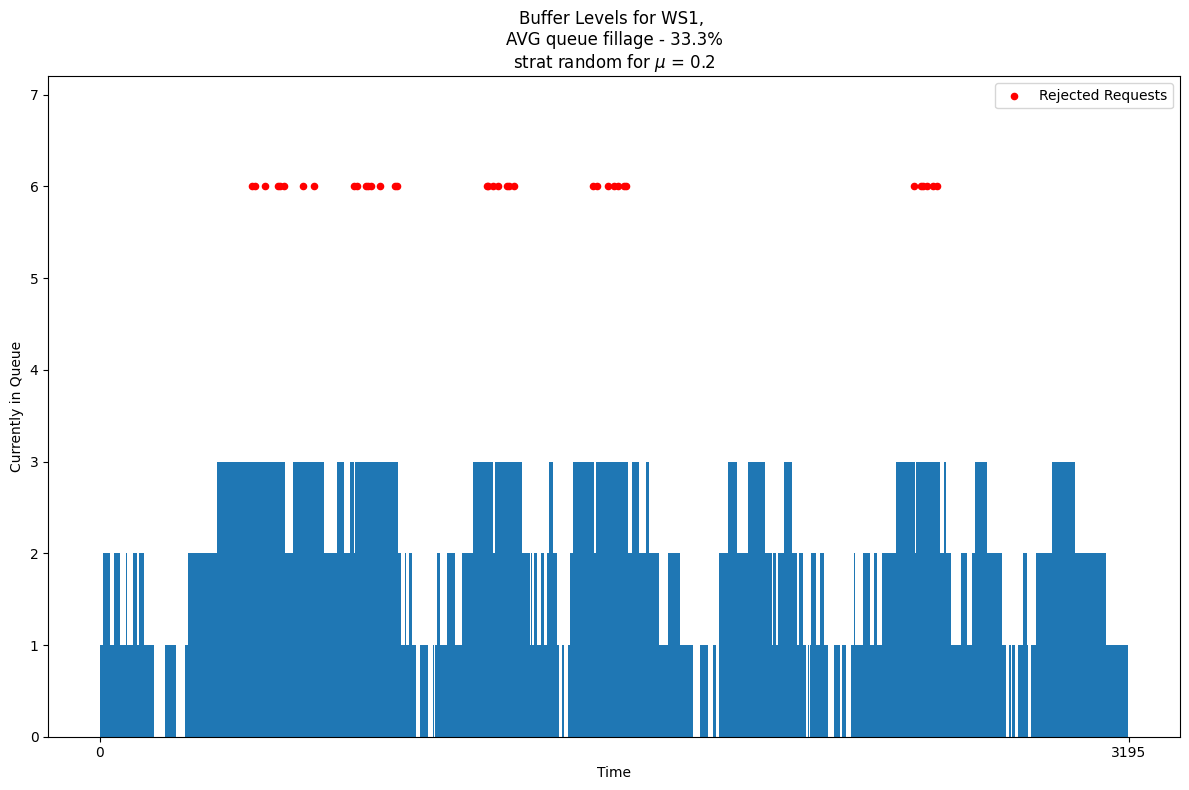

{'WS1': np.float64(33.3)}


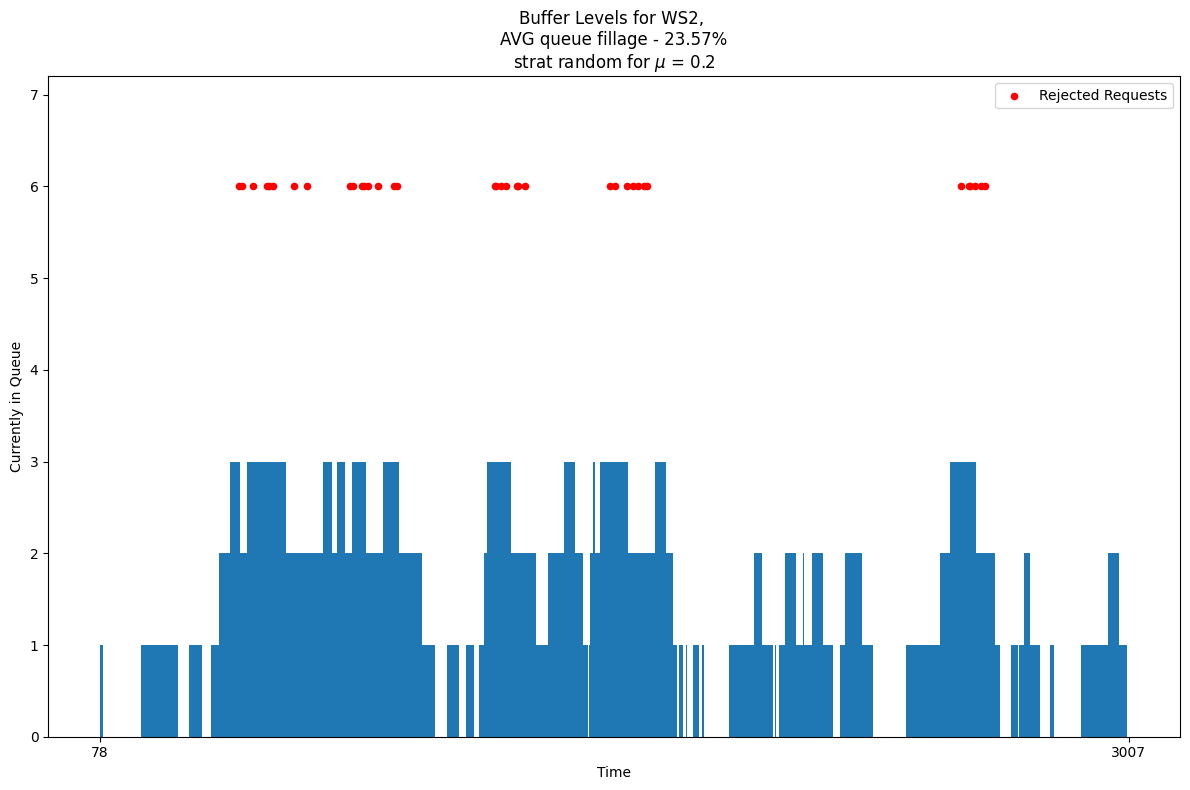

{'WS1': np.float64(33.3), 'WS2': np.float64(23.57)}


{'WS1': np.float64(33.3), 'WS2': np.float64(23.57)}

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_buffer_levels(data_df, rejects, max_buffer,strat,mu):

    # Get unique sources from the DataFrame
    unique_sources = data_df['source'].unique()
    avg_queues_p = {}
    # Iterate through each source to create the plots
    for source in unique_sources:
        temp_sum = 0
        df_a = data_df[data_df['source'] == source]
        for idx in range(df_a.shape[0]-1):
            temp_sum += (df_a['ts_in_ms'].values[idx+1] - df_a['ts_in_ms'].values[idx]) * df_a['currently_in_queue'].values[idx]
        avg_queue_p = np.round(temp_sum / df_a['ts_in_ms'].values[-1] / max_buffer *100,2)
        avg_queues_p[f'{source}'] = avg_queue_p
        # Filter the data for the current source
        source_data = data_df[data_df['source'] == source]
        fig = plt.figure(figsize=(12, 8))
        
        # Step plot for currently in queue
        plt.step(source_data['ts_in_ms'], source_data['currently_in_queue'], where='mid', alpha=0)
        plt.fill_between(source_data['ts_in_ms'], source_data['currently_in_queue'], step='mid')

        # Set the limits for the y-axis
        plt.ylim(0, max_buffer*1.2)
        
        # Scatter plot for rejected requests
        plt.scatter(rejects['ts_in_ms'], np.ones(len(rejects)) * max_buffer, 
                    color='red', s=20, label='Rejected Requests')

        # Set title and labels
        plt.title(f'Buffer Levels for {source}, \nAVG queue fillage - {avg_queue_p}%\nstrat {strat} for $\mu$ = {mu}')
        plt.xlabel('Time')
        plt.ylabel('Currently in Queue')
        plt.legend()
        
        # Set x-axis ticks
        plt.xticks([np.min(source_data['ts_in_ms']), np.max(source_data['ts_in_ms'])])
        
        # Show the plot
        plt.tight_layout()
        plt.show()
        print(avg_queues_p)
        fig.savefig(f'plots/plt_{source}_{strat}_{mu}.jpg')
    return avg_queues_p
# Example usage
max_buffer = 6  # Set the maximum buffer level as needed
plot_buffer_levels(data_df, rejects, max_buffer,'random',0.2)


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


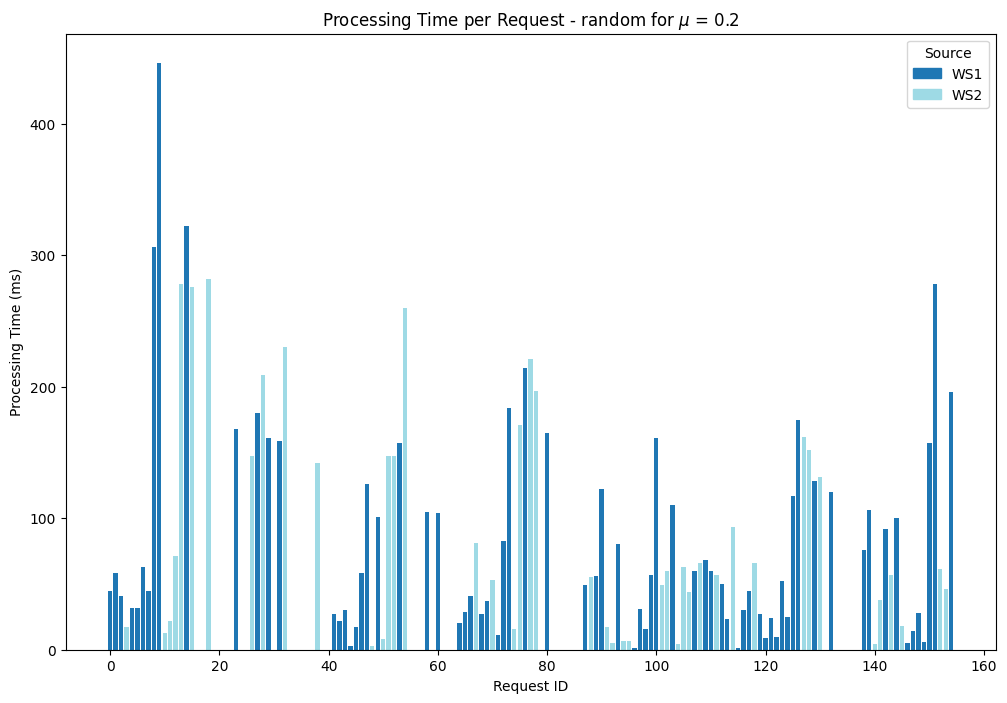

({'WS1': np.float64(86.27027027027027),
  'WS2': np.float64(94.5111111111111),
  'Global': np.float64(89.38655462184875)},
 {'WS1': np.float64(83.87373048624569),
  'WS2': np.float64(86.09208131208389),
  'Global': np.float64(86.09208131208389)})

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_processing_times(merged_df, strat, mu):
    unique_sources = merged_df['source_queued'].unique()
    avg_times = {}
    stds_times = {}
    for source in unique_sources:
        avg_times[f'{source}'] = result[result['source_queued']==source]['processing_time_ms'].mean()
        stds_times[f'{source}'] = result[result['source_queued']==source]['processing_time_ms'].std()
    avg_times['Global'] = result['processing_time_ms'].mean()
    stds_times['Global'] = result[result['source_queued']==source]['processing_time_ms'].std()
   
    num_sources = len(unique_sources)
    cmap = cm.get_cmap('tab20', num_sources)  
    color_mapping = {source: cmap(i) for i, source in enumerate(unique_sources)}

    colors = merged_df['source_queued'].map(color_mapping)

    fig = plt.figure(figsize=[12, 8])
    plt.bar(merged_df['request'], merged_df['processing_time_ms'], color=colors)

    plt.xlabel('Request ID')
    plt.ylabel('Processing Time (ms)')
    plt.title(fr'Processing Time per request - {strat} for $\mu$ = {mu}')
    

    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[source]) for source in unique_sources]
    plt.legend(handles, unique_sources, title="Source")
    plt.show()
    fig.savefig(f'plots/plt_{strat}_{mu}.jpg')
    return avg_times, stds_times

plot_processing_times(result,'random', 0.2)


Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 455
Odrzucone zgłoszenia: 0


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


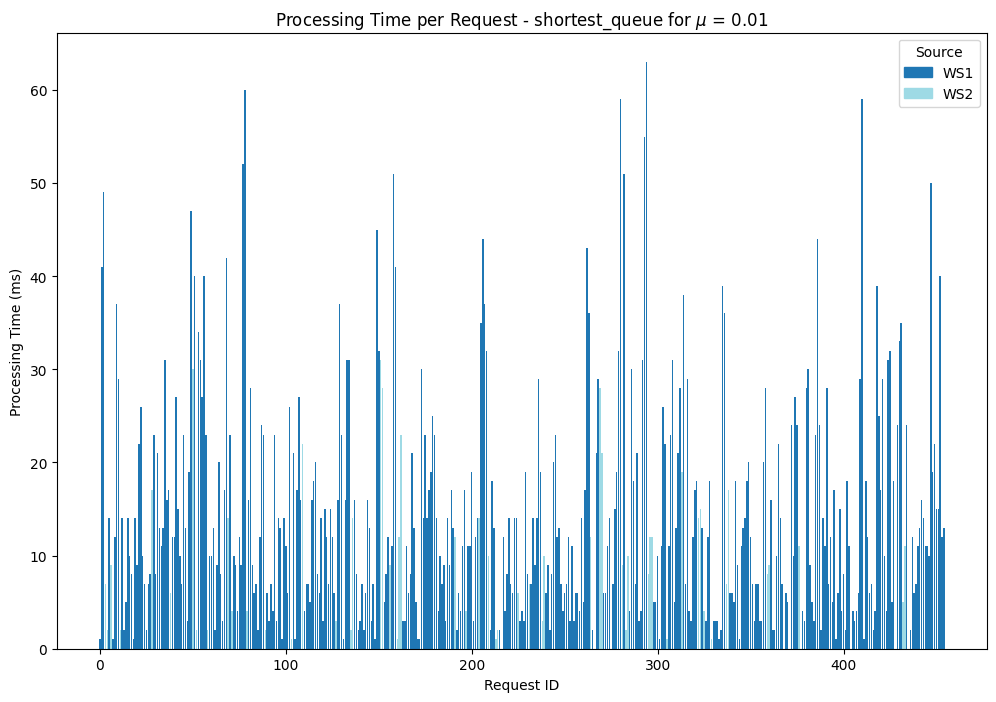

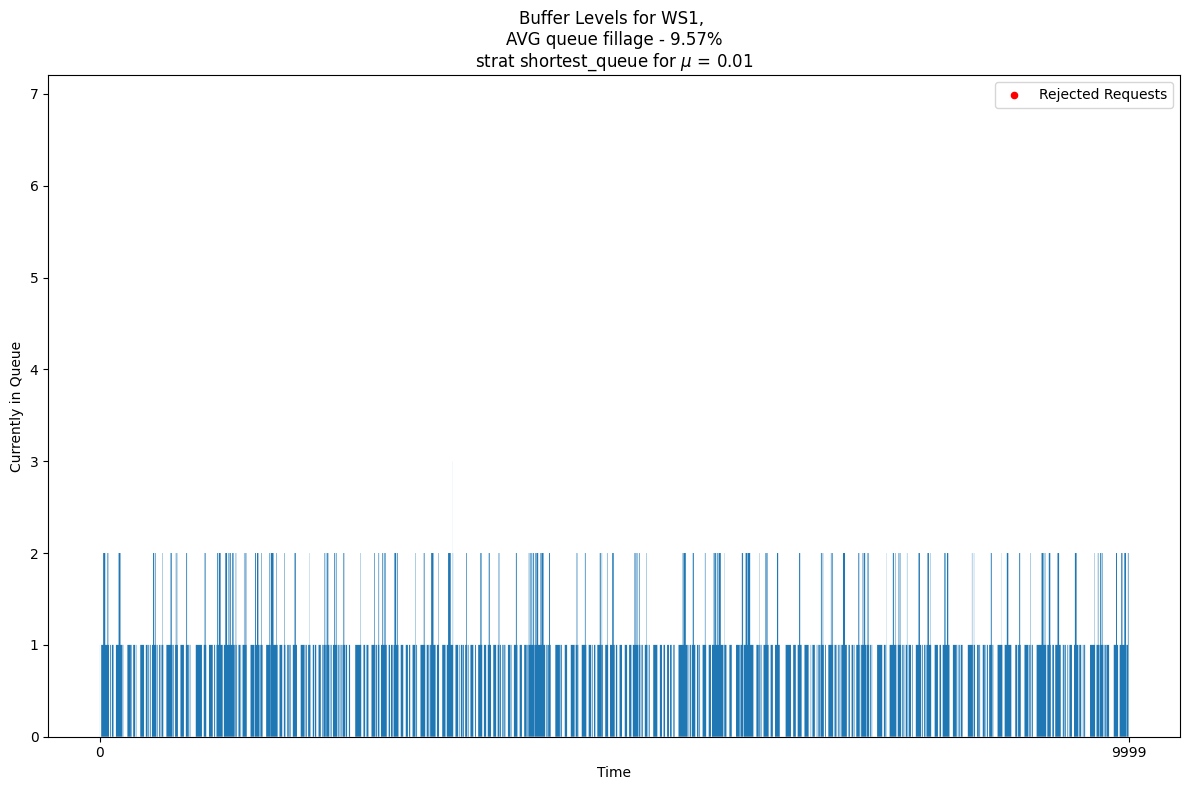

{'WS1': np.float64(9.57)}


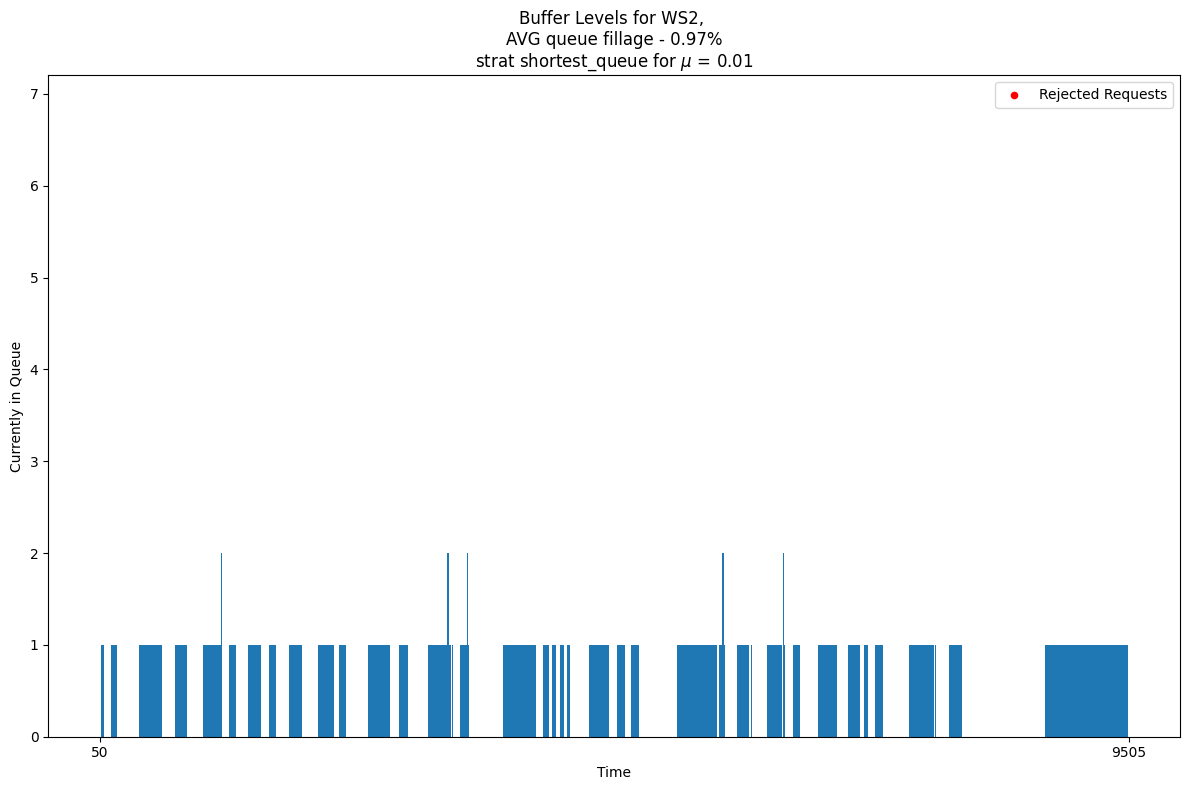

{'WS1': np.float64(9.57), 'WS2': np.float64(0.97)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 483
Odrzucone zgłoszenia: 0


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


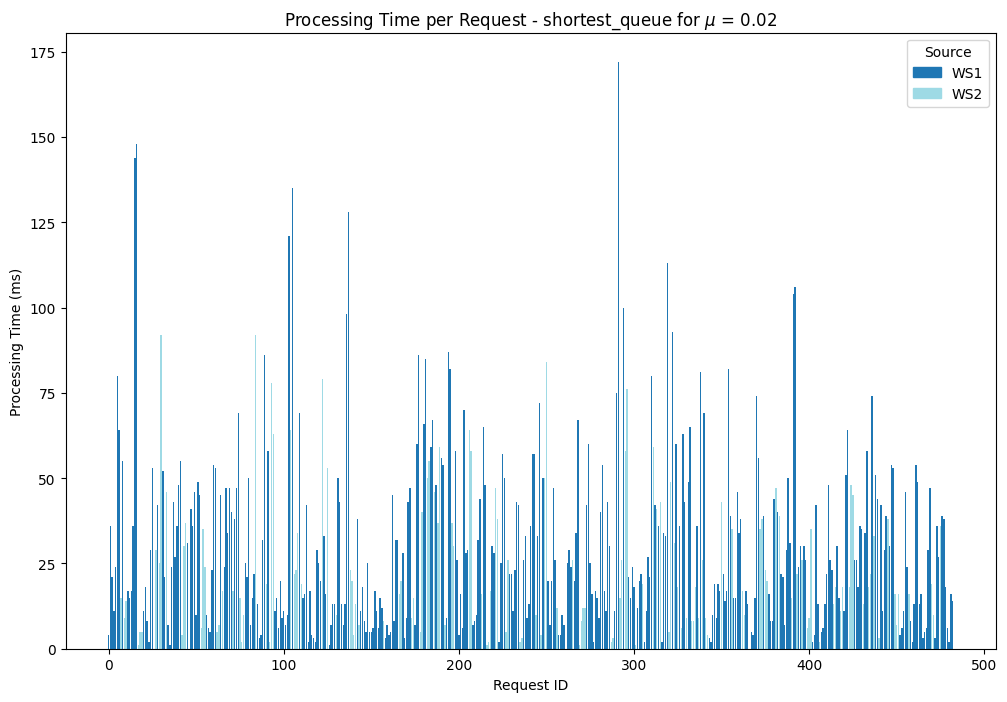

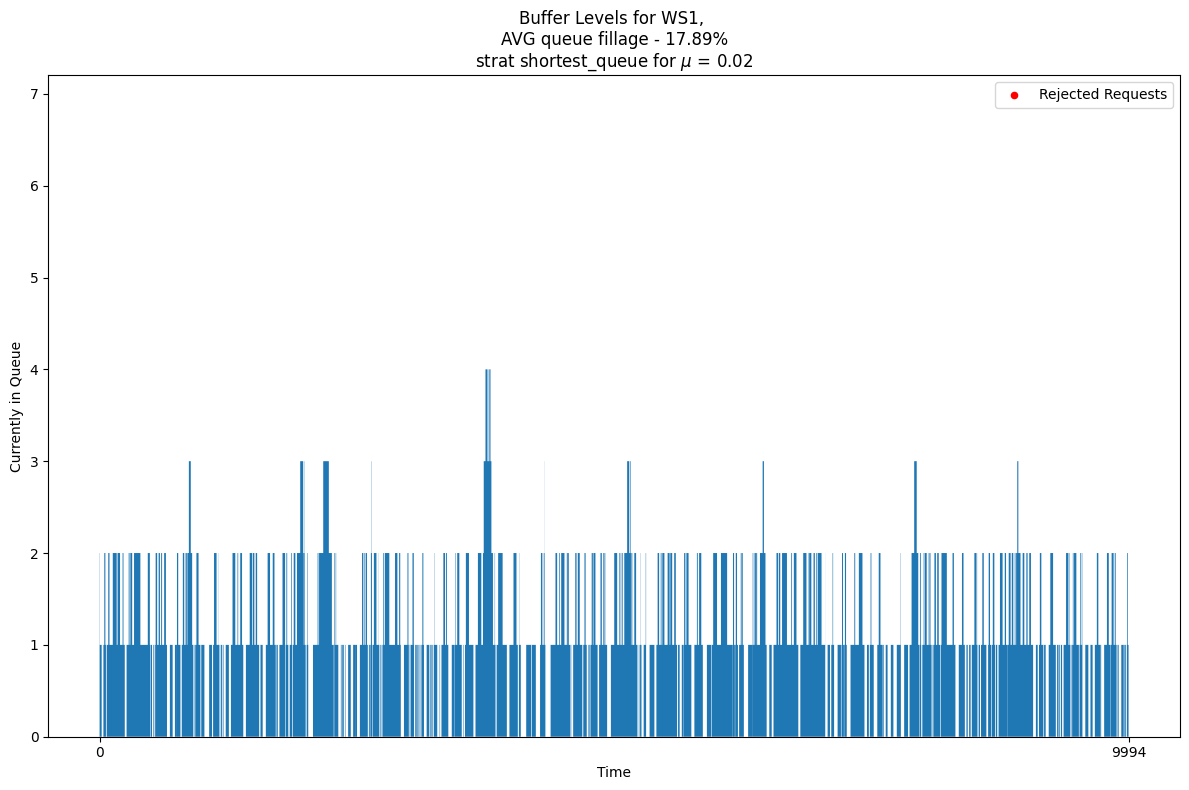

{'WS1': np.float64(17.89)}


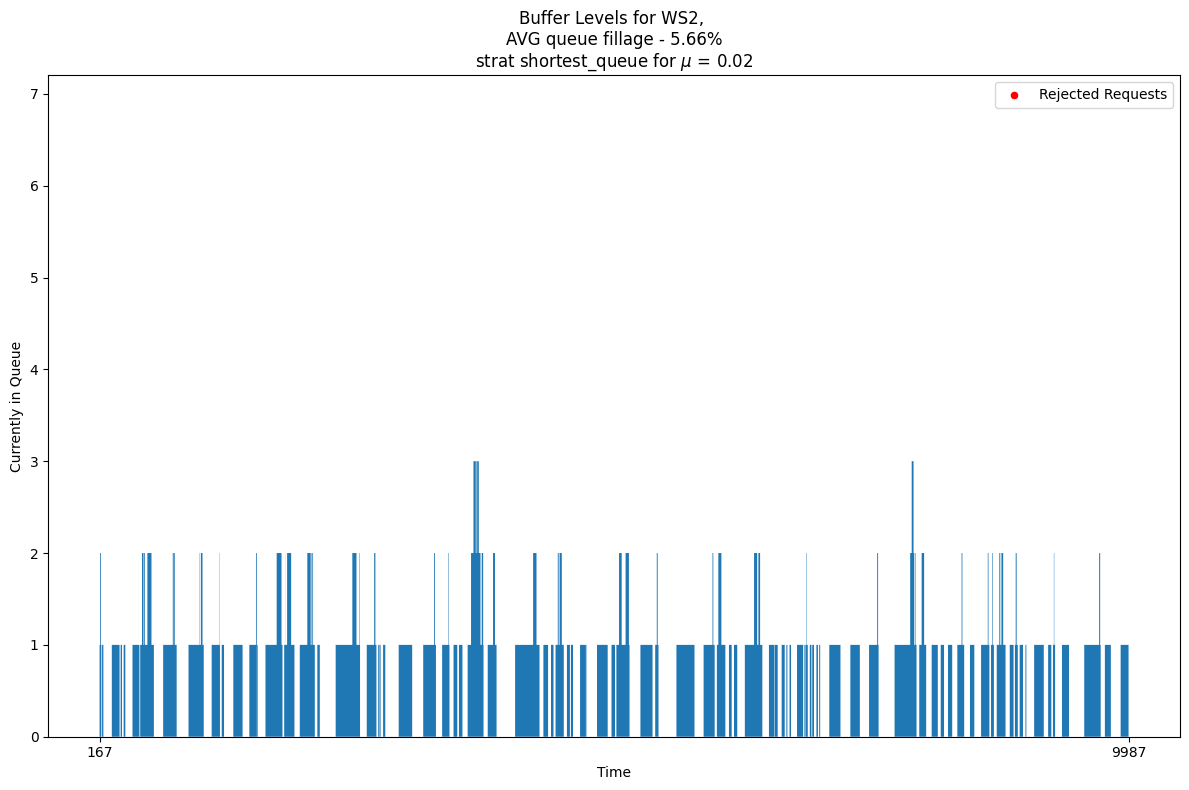

{'WS1': np.float64(17.89), 'WS2': np.float64(5.66)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 497
Odrzucone zgłoszenia: 0


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


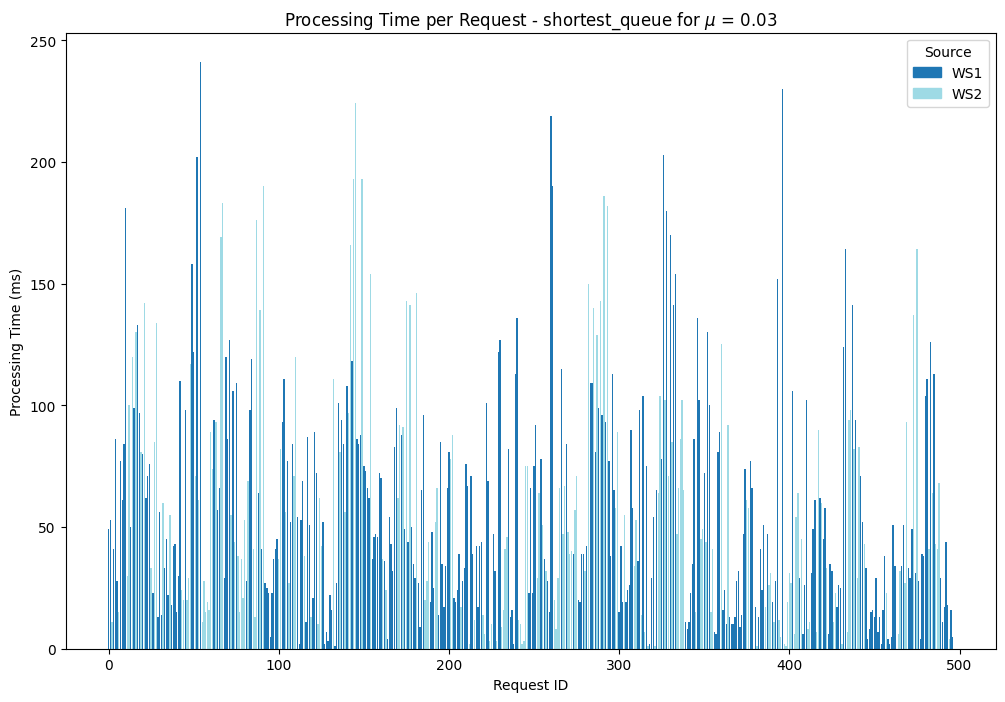

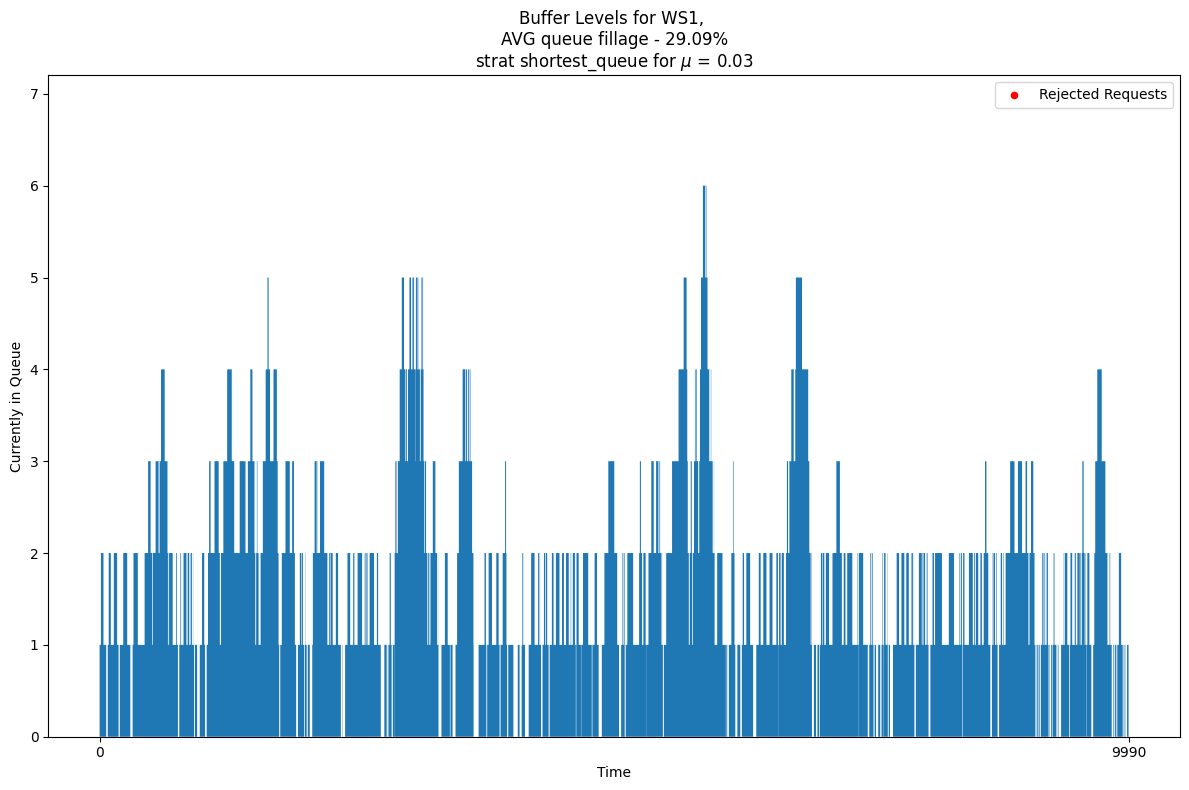

{'WS1': np.float64(29.09)}


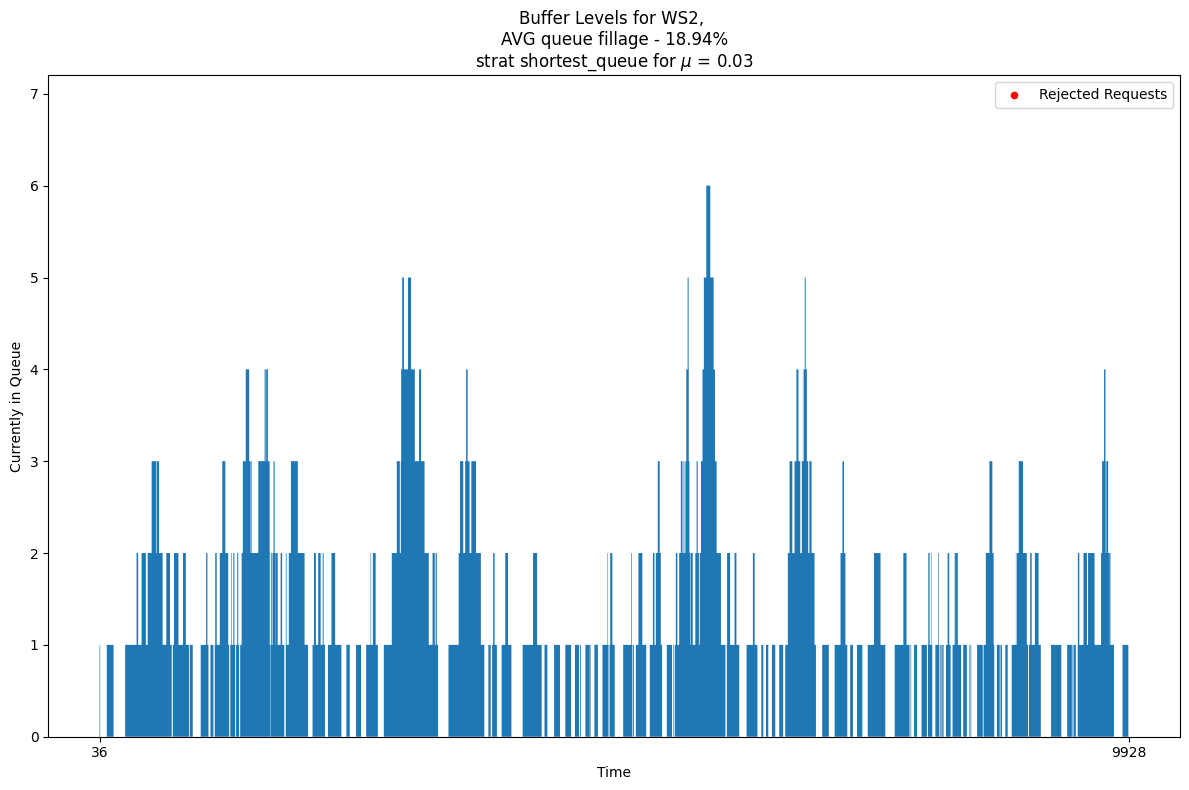

{'WS1': np.float64(29.09), 'WS2': np.float64(18.94)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 440
Odrzucone zgłoszenia: 28


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


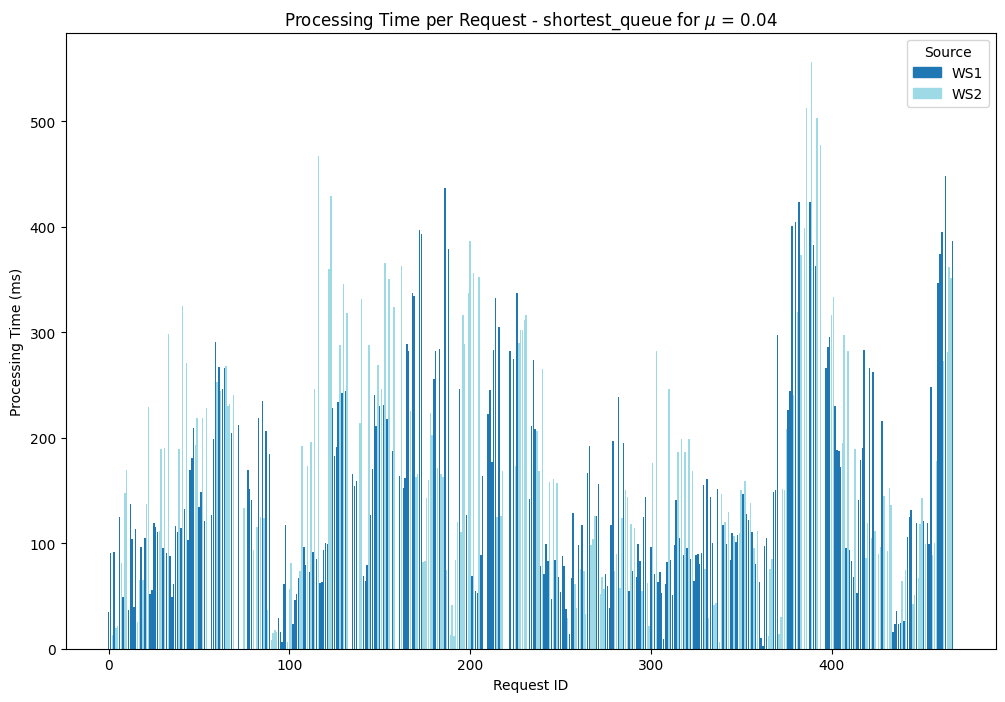

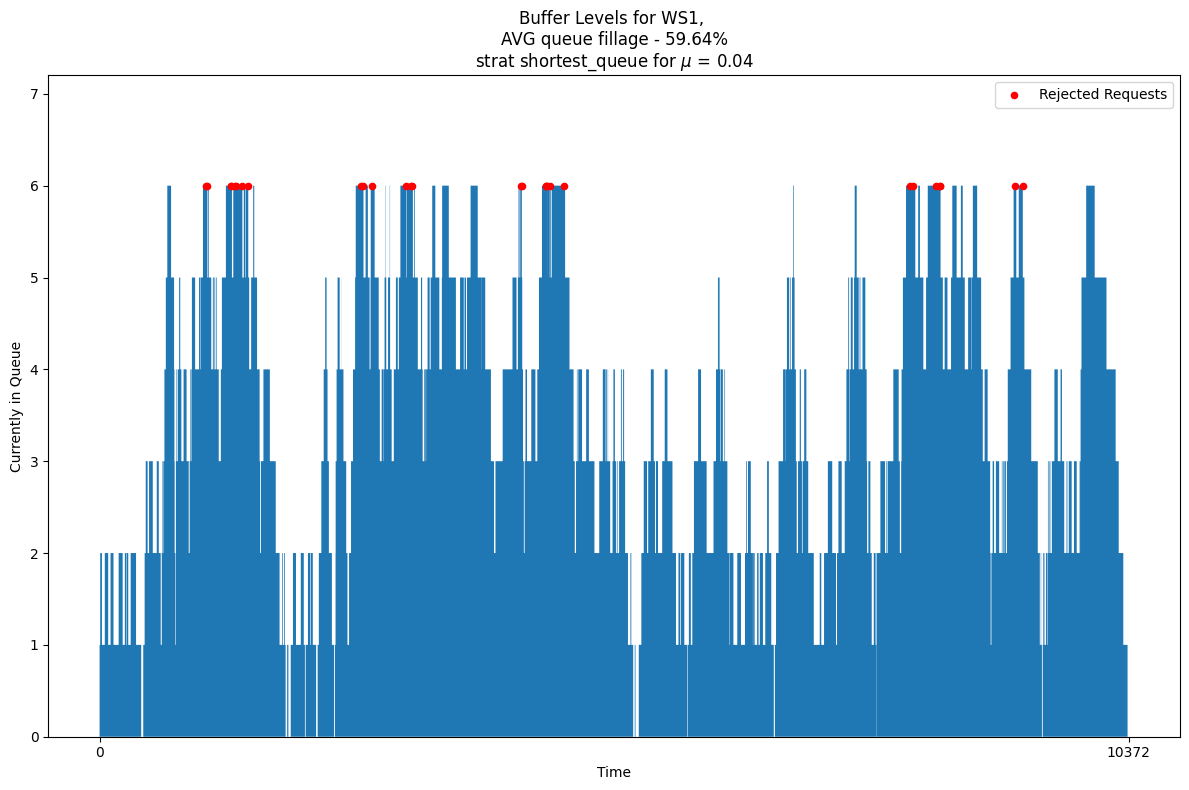

{'WS1': np.float64(59.64)}


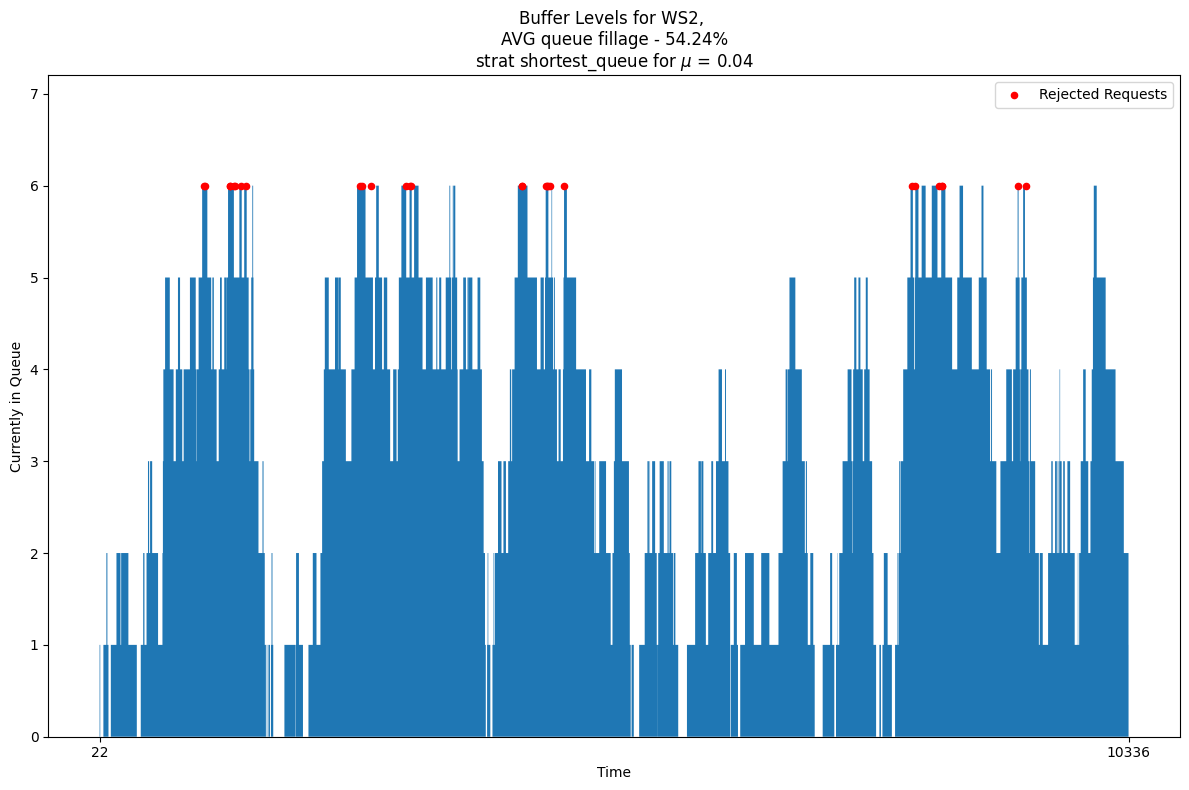

{'WS1': np.float64(59.64), 'WS2': np.float64(54.24)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 379
Odrzucone zgłoszenia: 111


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


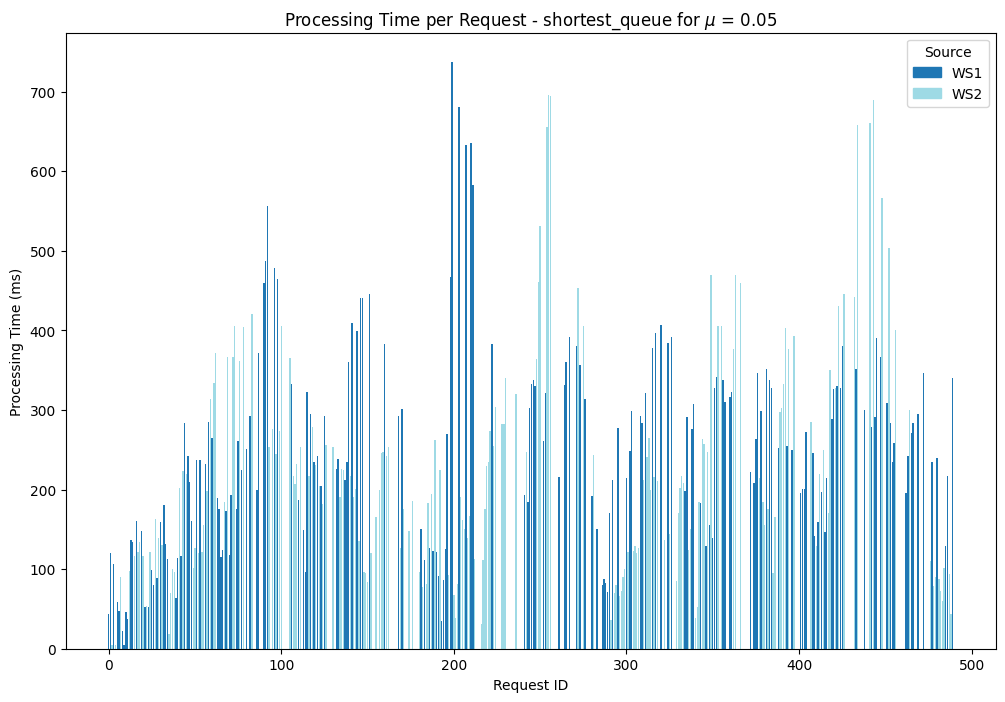

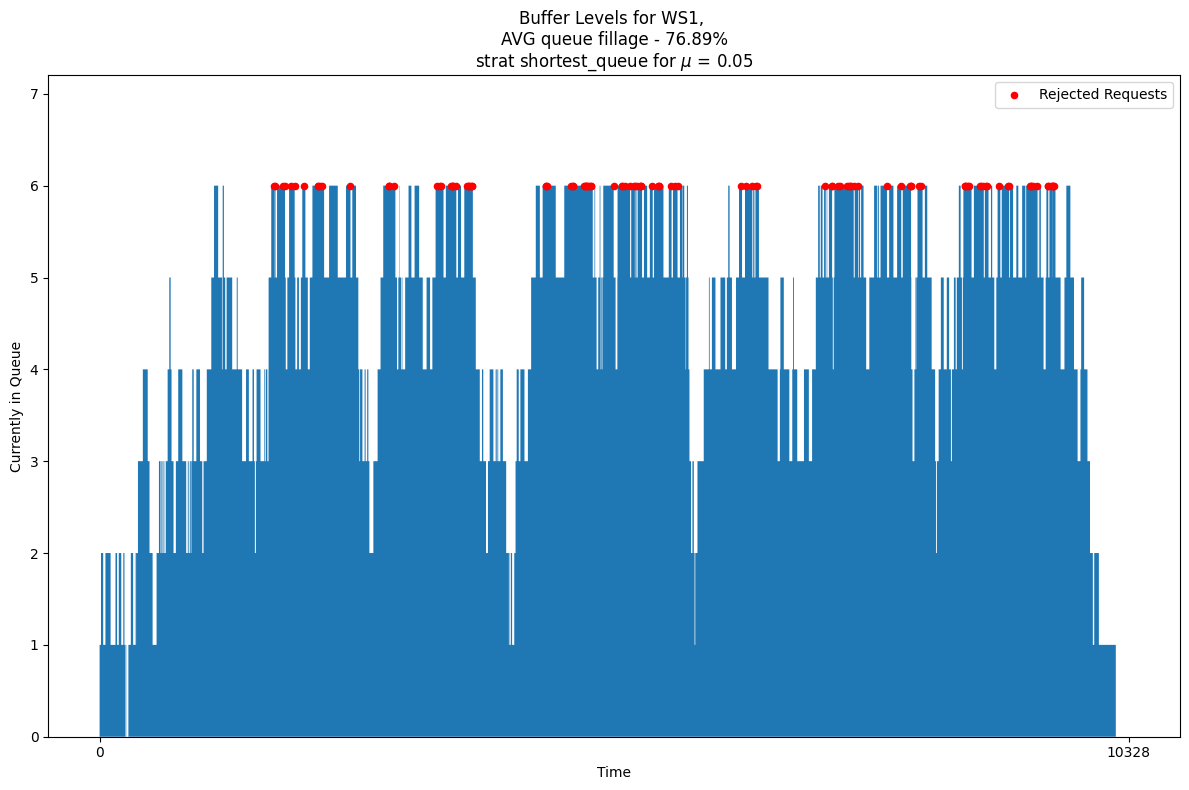

{'WS1': np.float64(76.89)}


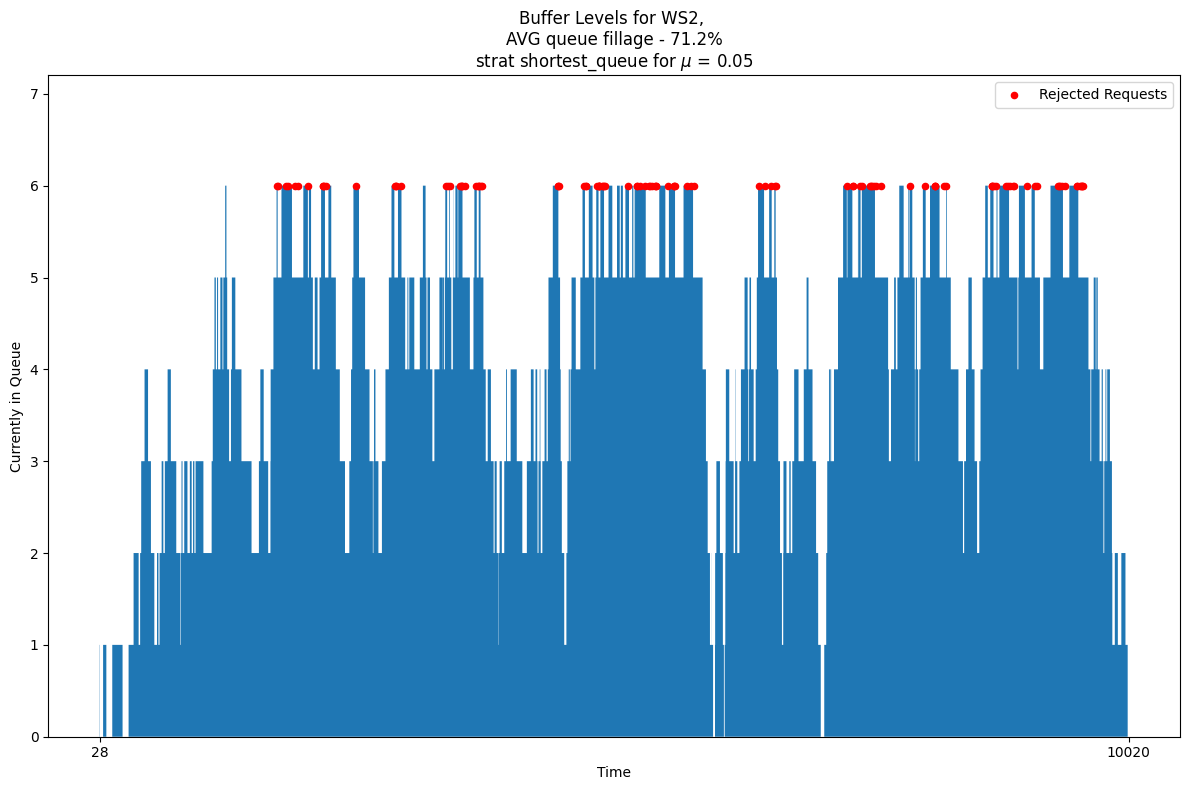

{'WS1': np.float64(76.89), 'WS2': np.float64(71.2)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 355
Odrzucone zgłoszenia: 134


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


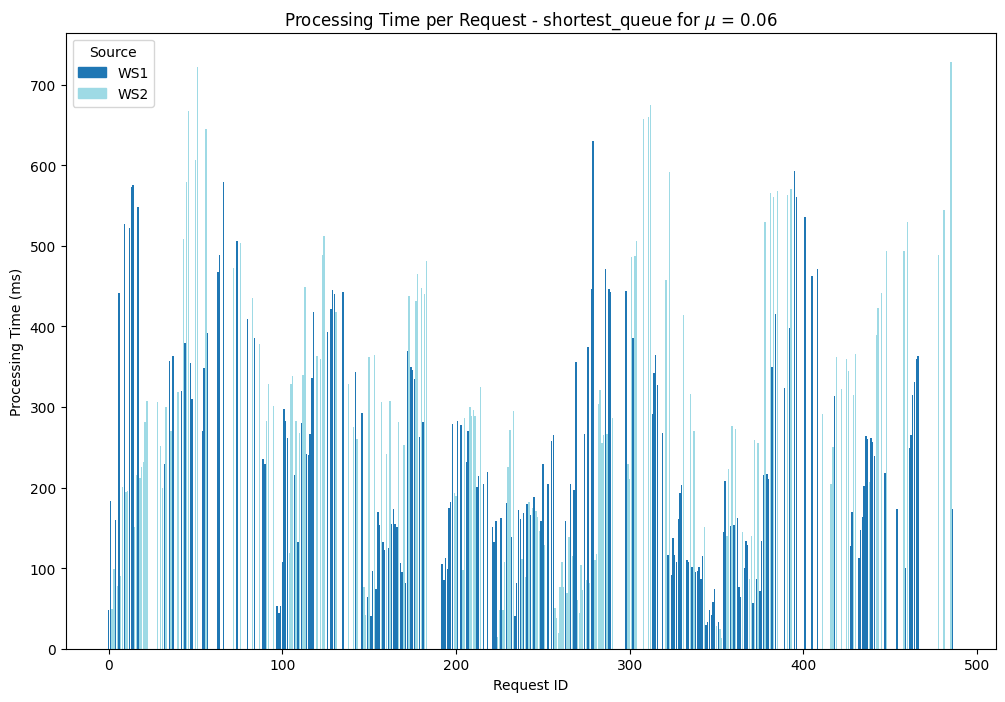

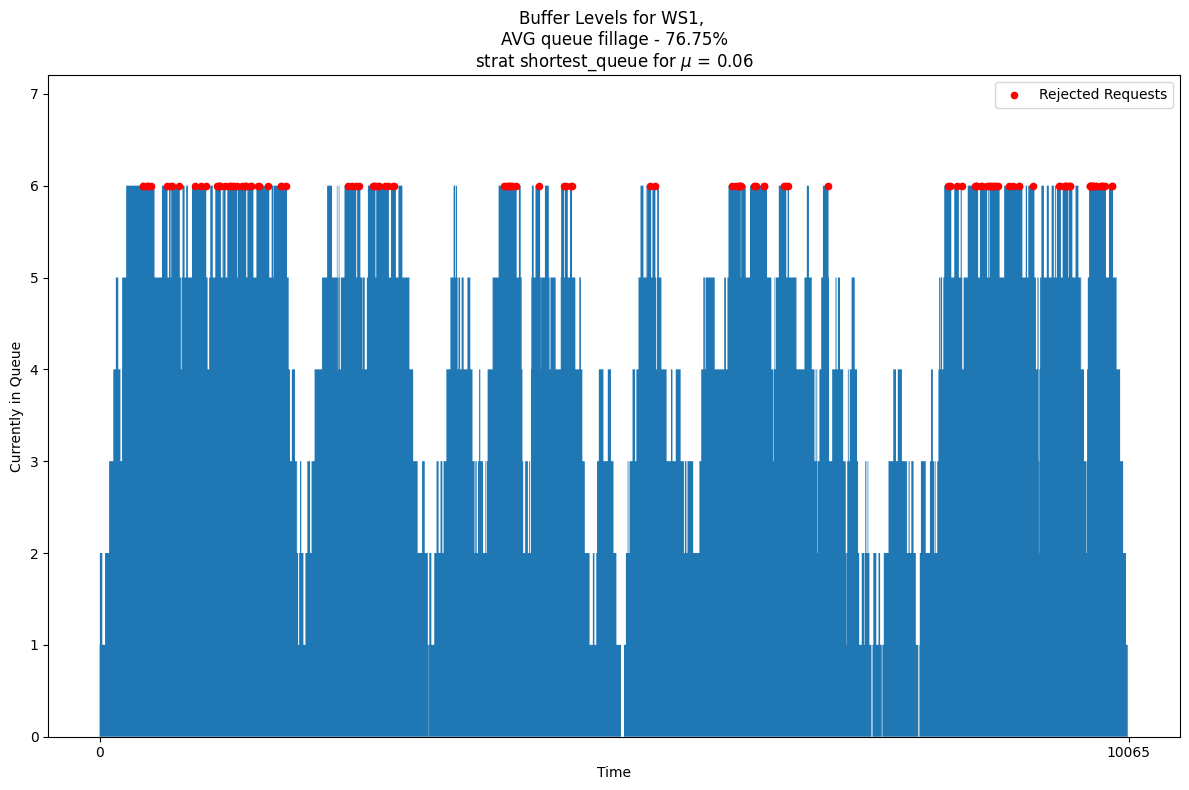

{'WS1': np.float64(76.75)}


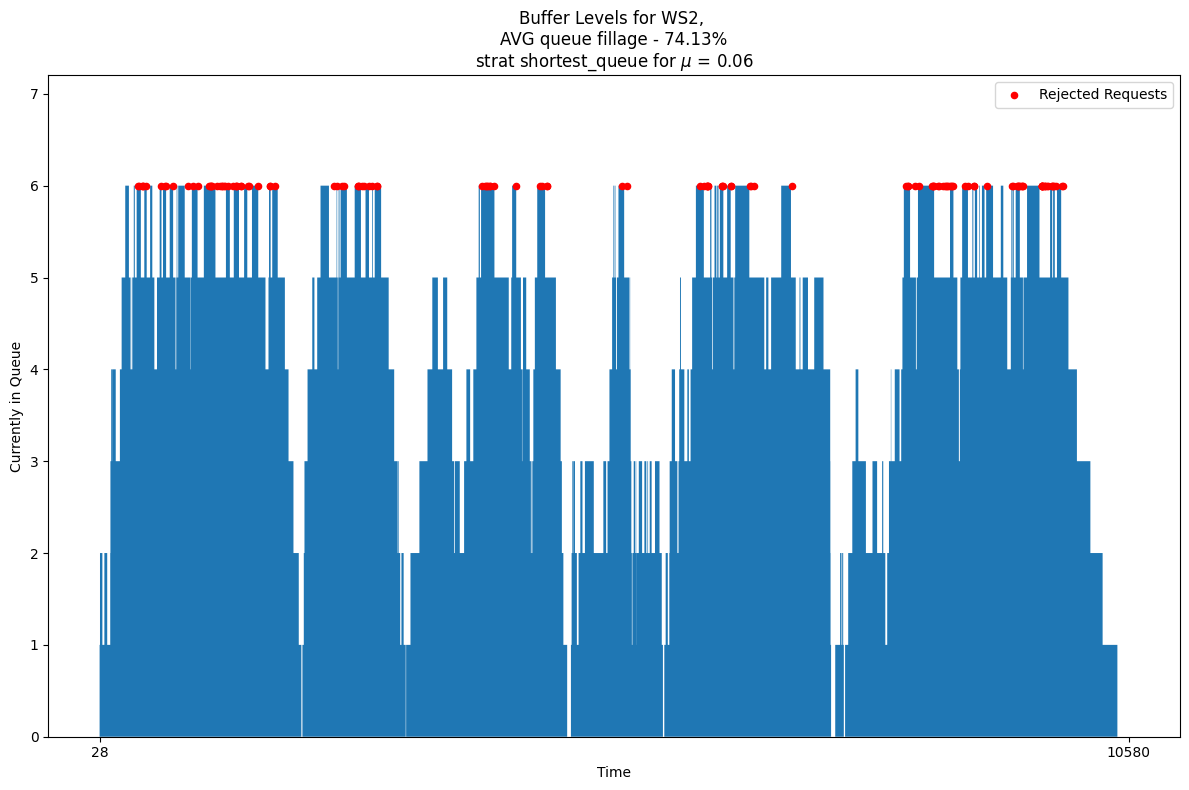

{'WS1': np.float64(76.75), 'WS2': np.float64(74.13)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 297
Odrzucone zgłoszenia: 180


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


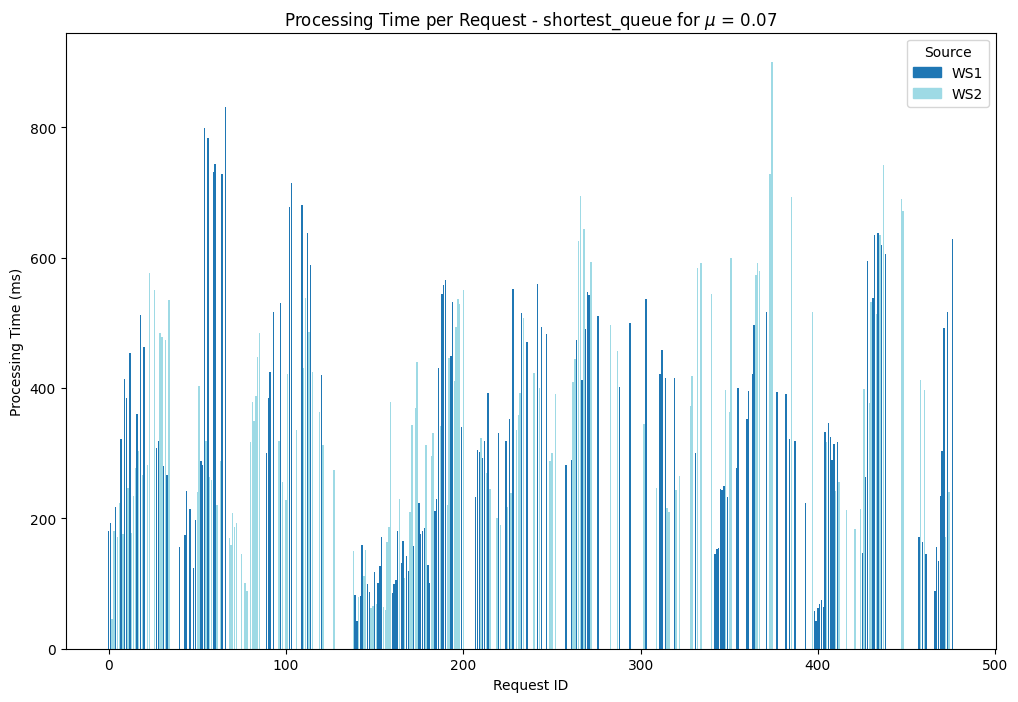

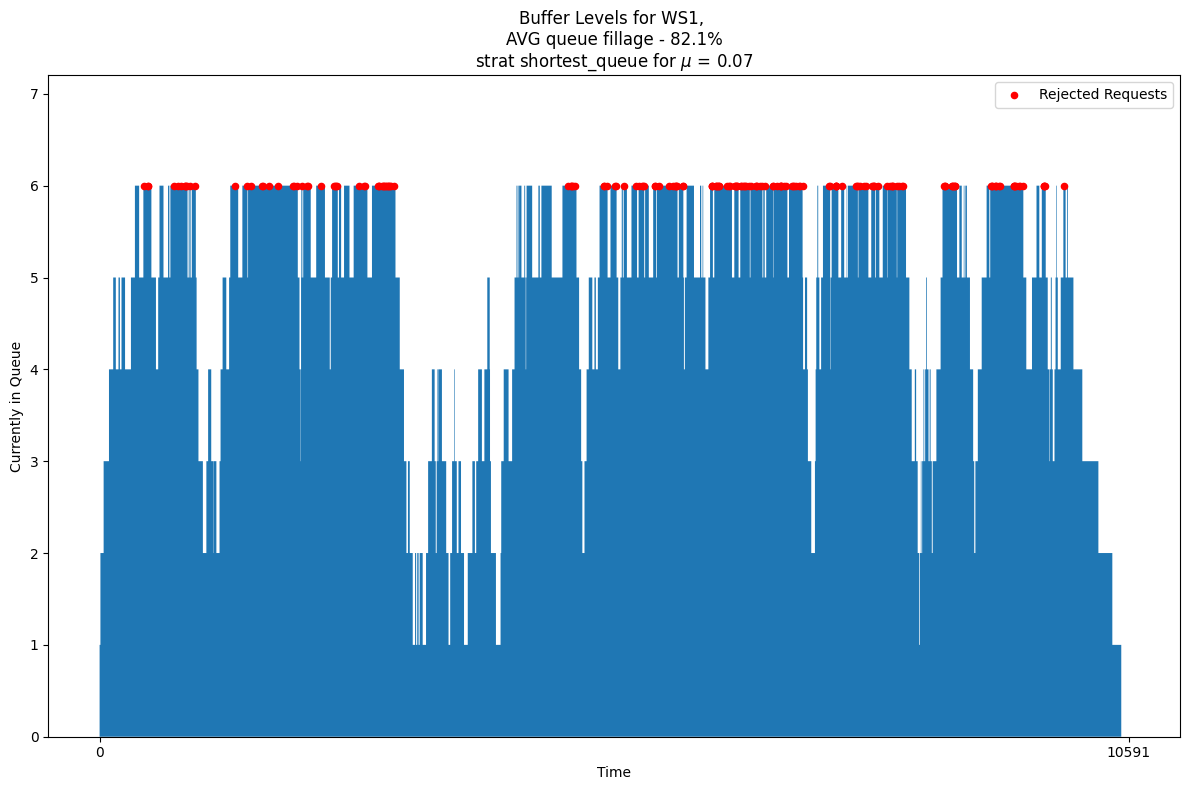

{'WS1': np.float64(82.1)}


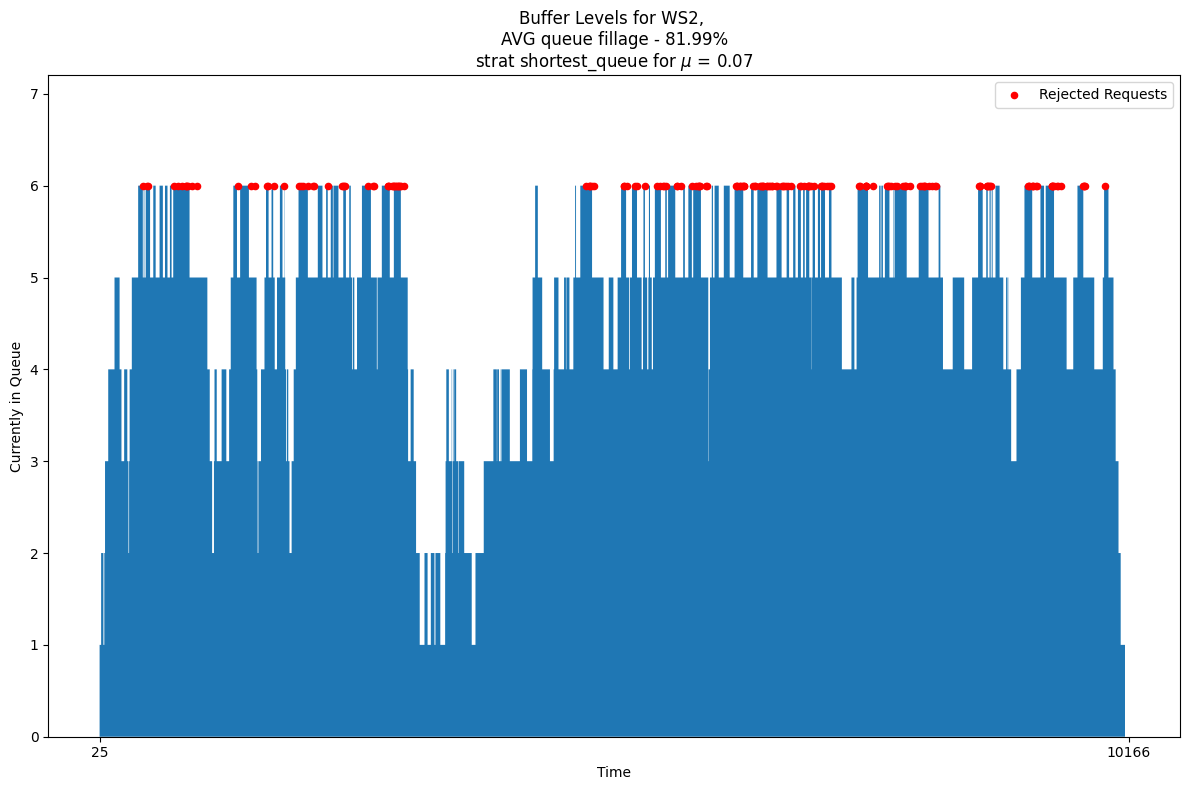

{'WS1': np.float64(82.1), 'WS2': np.float64(81.99)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 254
Odrzucone zgłoszenia: 214


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


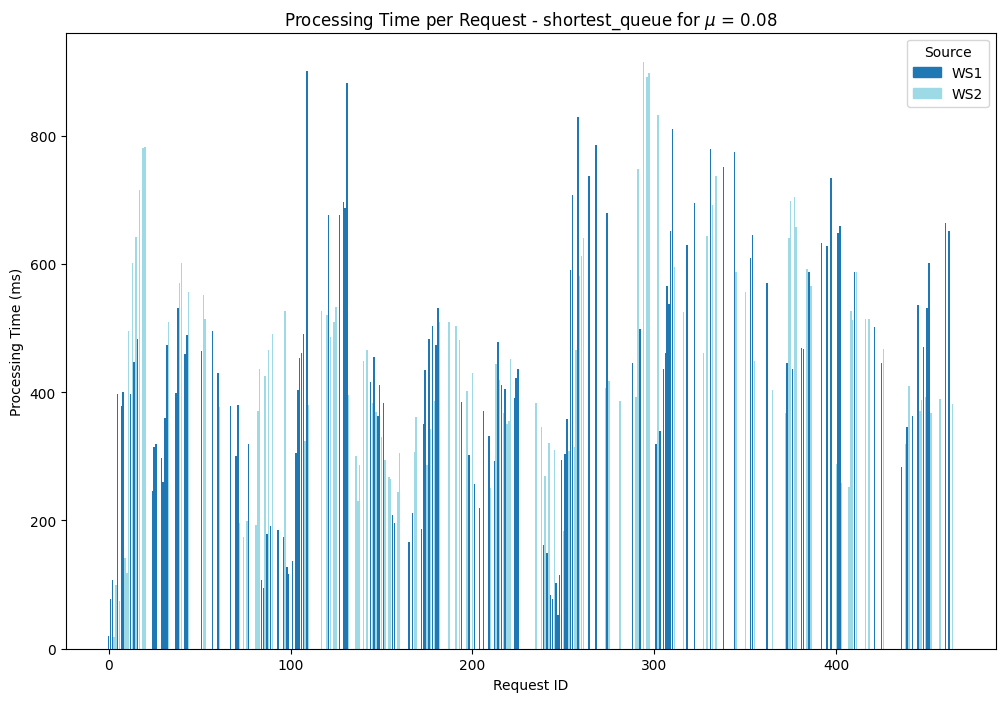

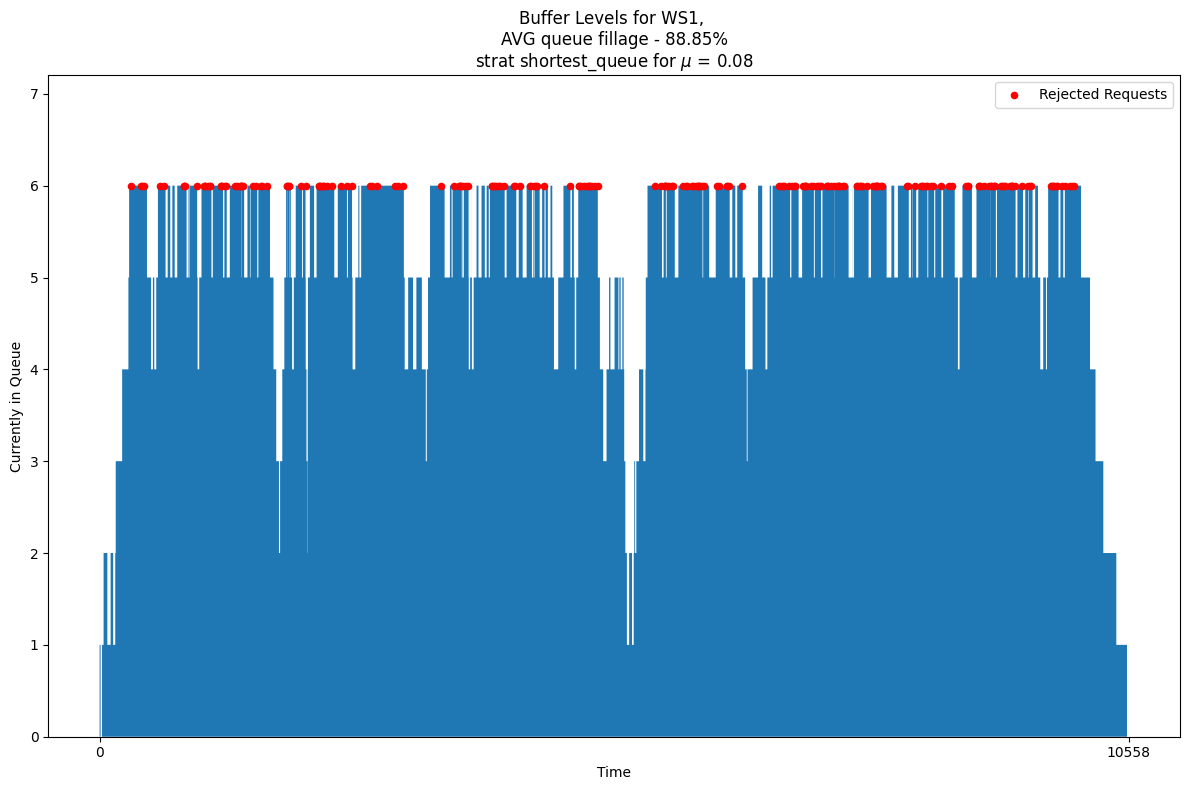

{'WS1': np.float64(88.85)}


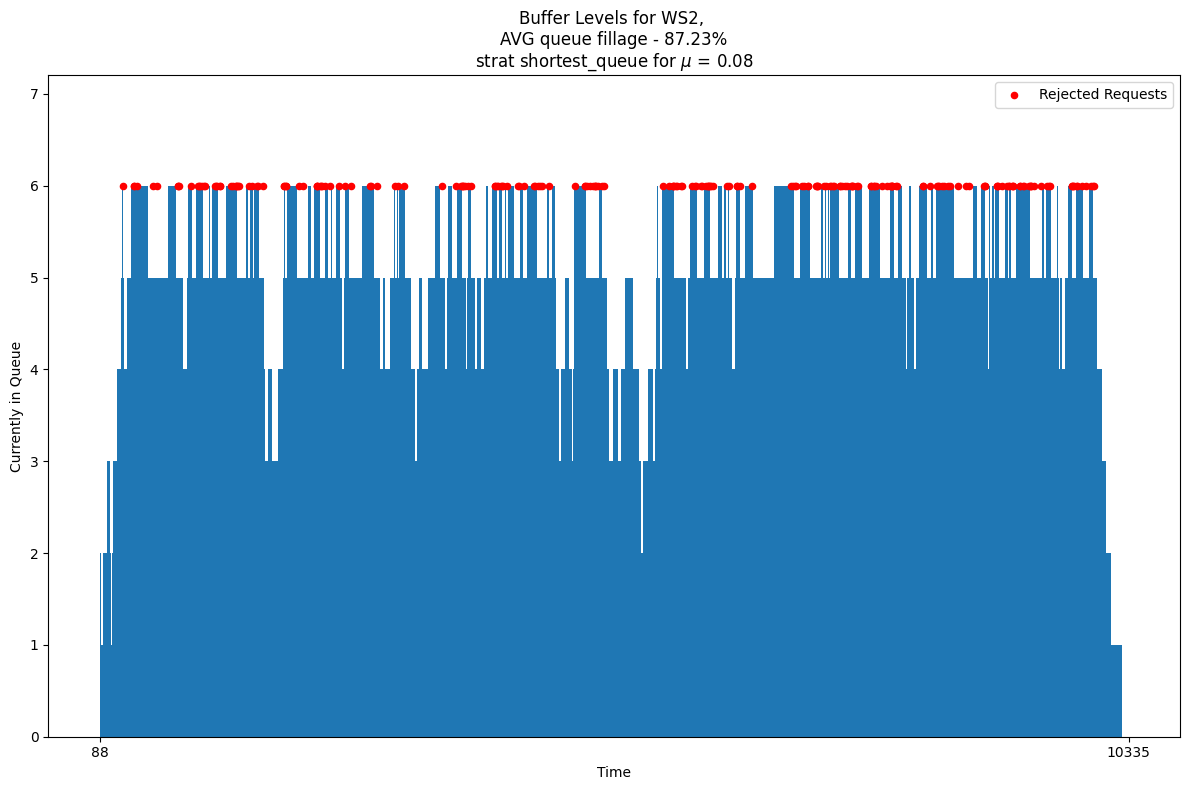

{'WS1': np.float64(88.85), 'WS2': np.float64(87.23)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 216
Odrzucone zgłoszenia: 242


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


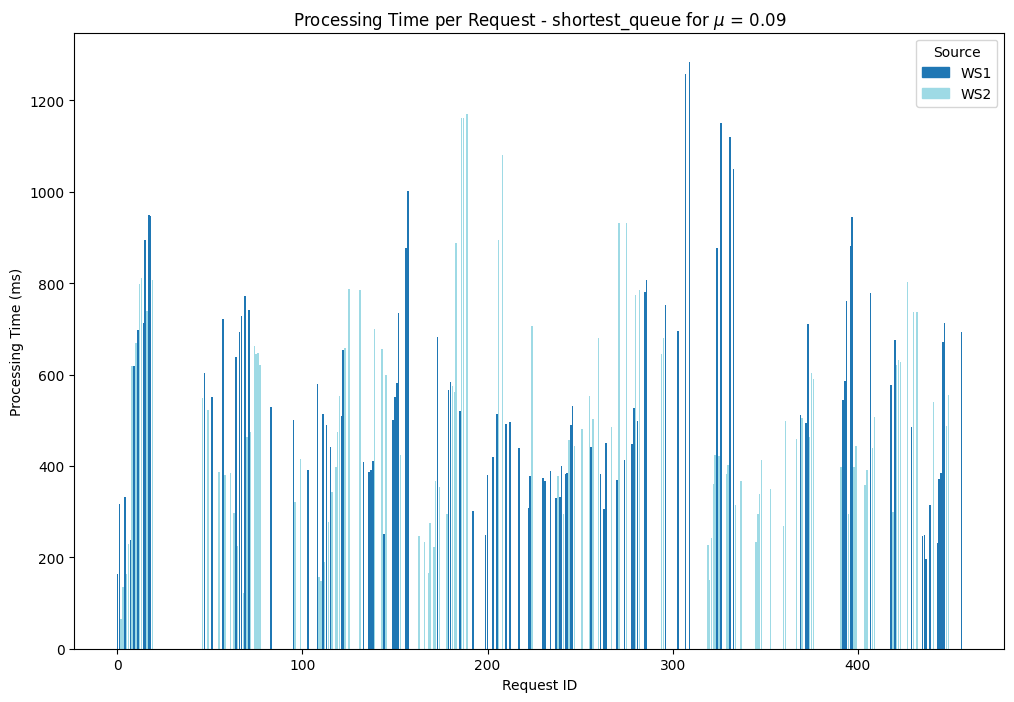

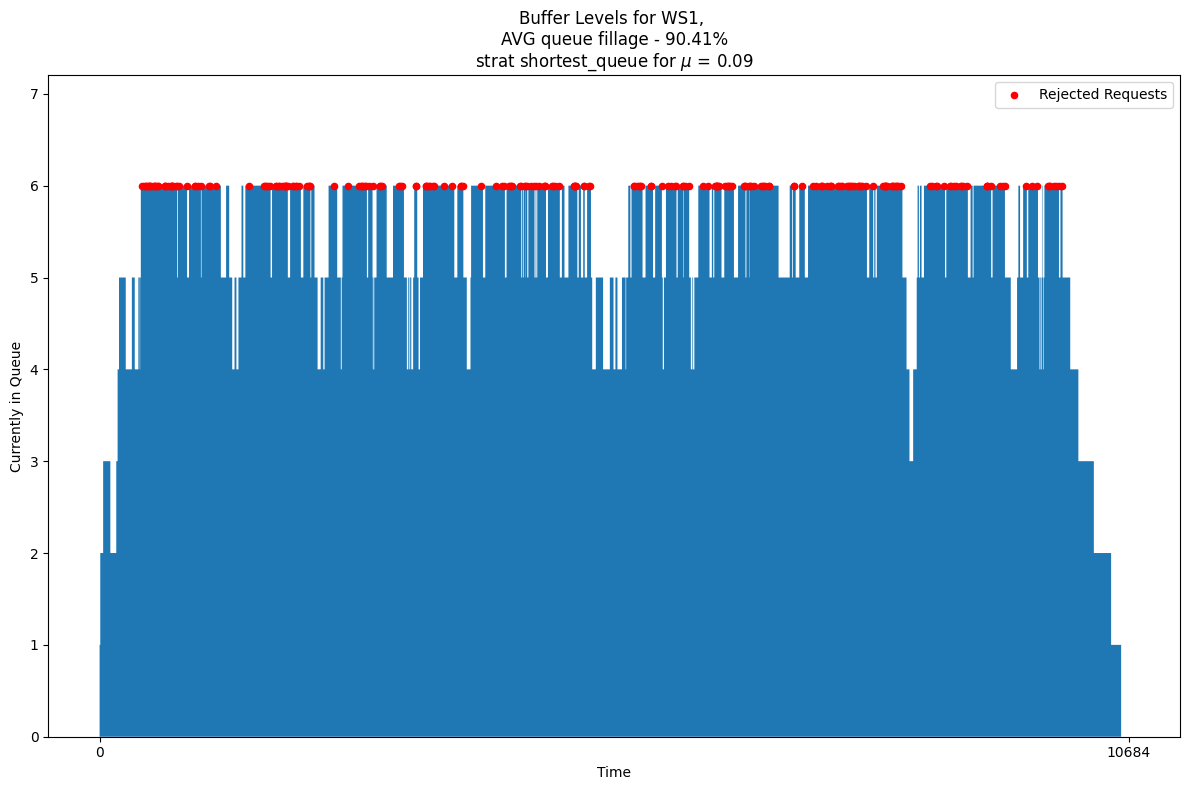

{'WS1': np.float64(90.41)}


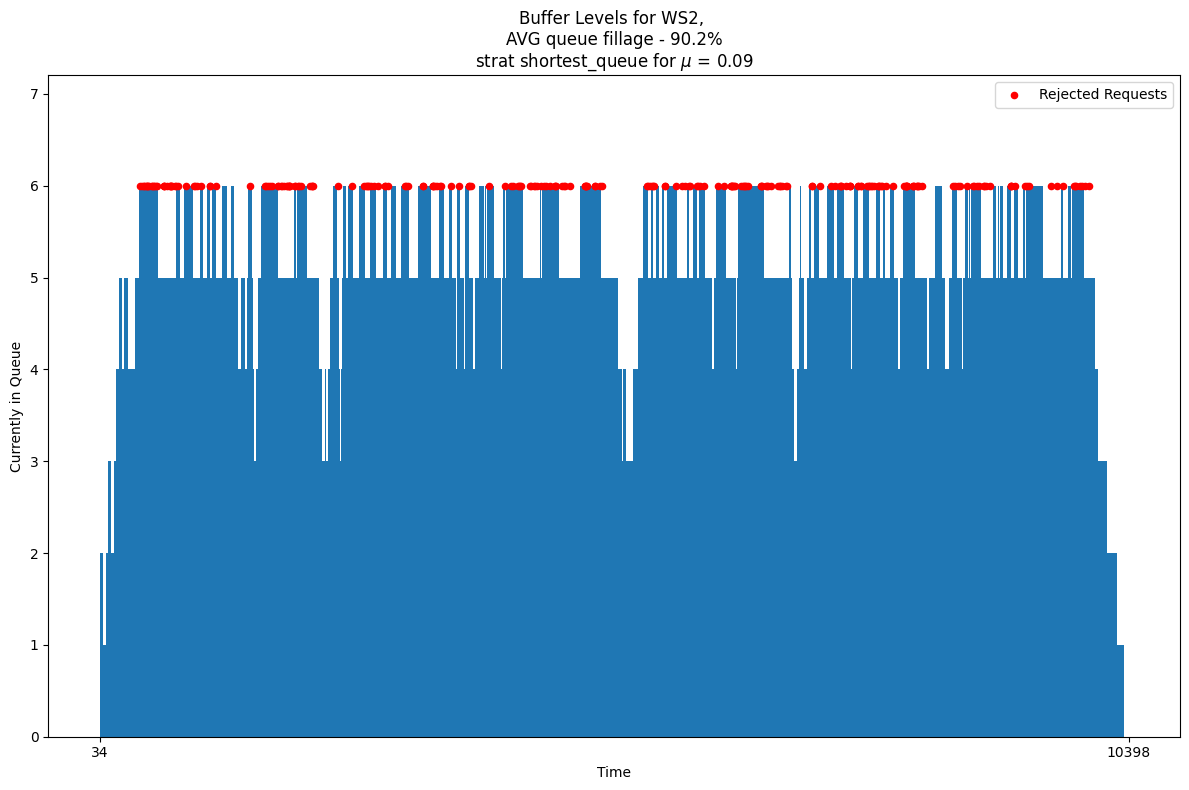

{'WS1': np.float64(90.41), 'WS2': np.float64(90.2)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 210
Odrzucone zgłoszenia: 249


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


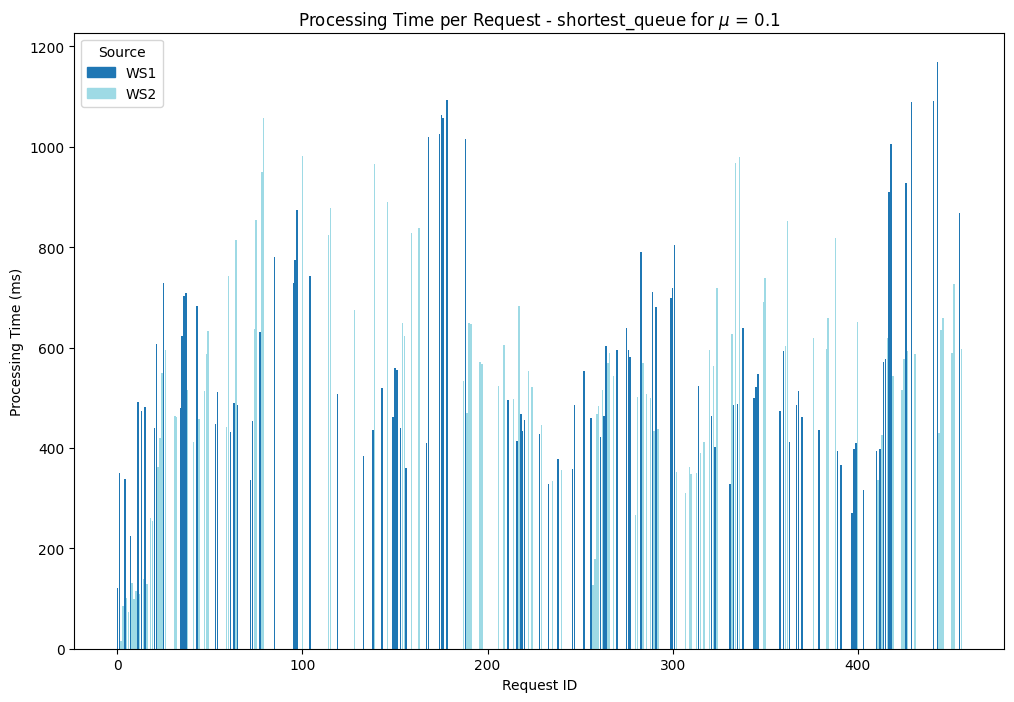

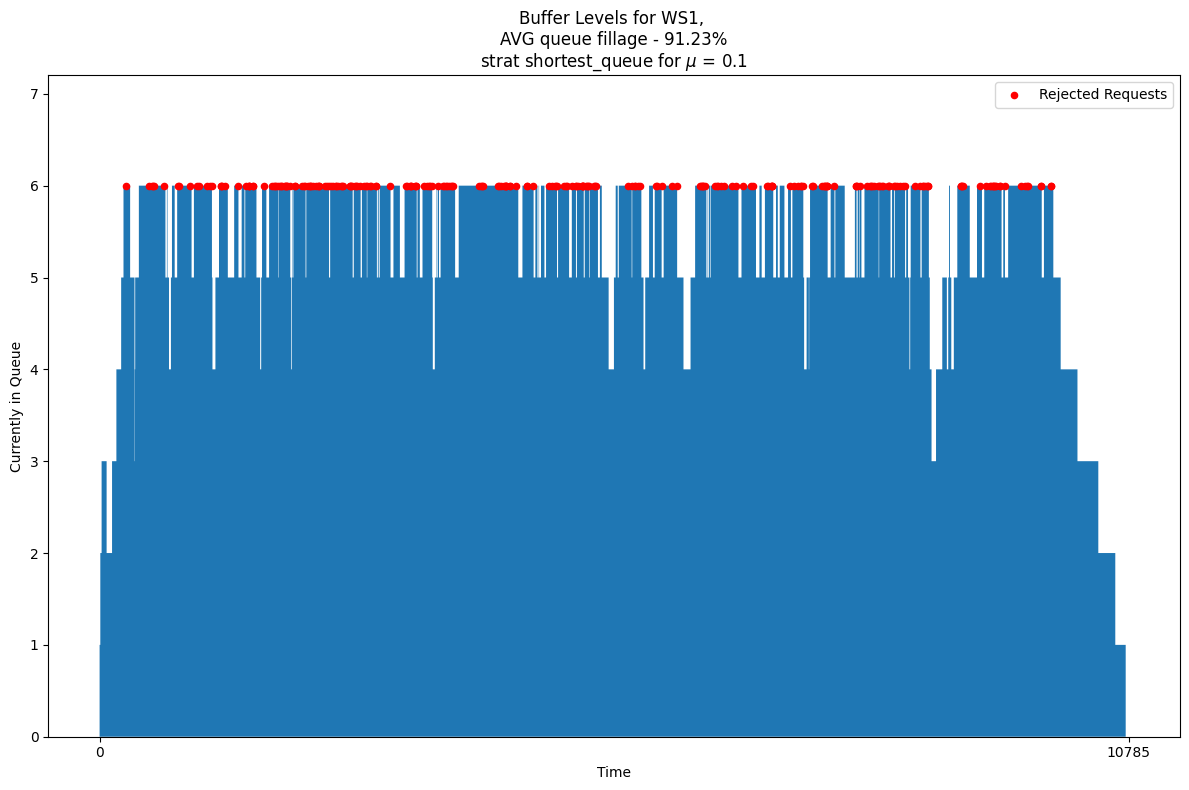

{'WS1': np.float64(91.23)}


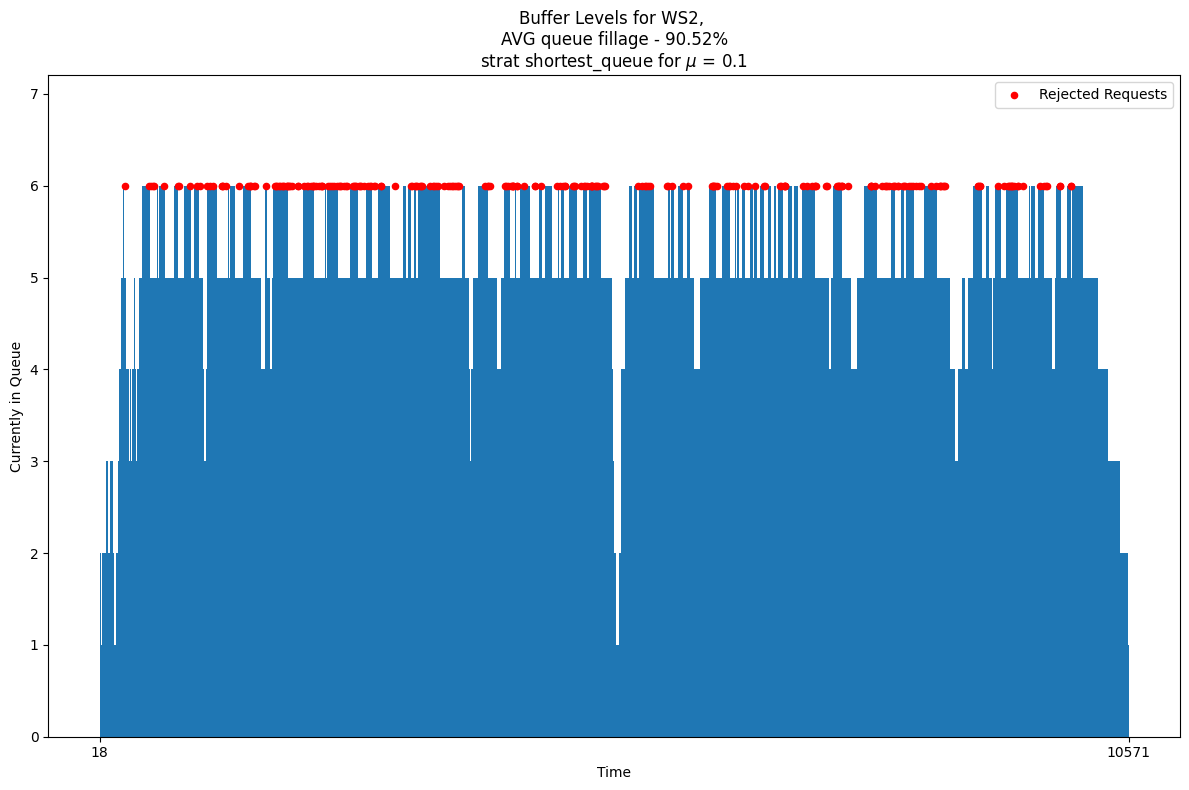

{'WS1': np.float64(91.23), 'WS2': np.float64(90.52)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 213
Odrzucone zgłoszenia: 272


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


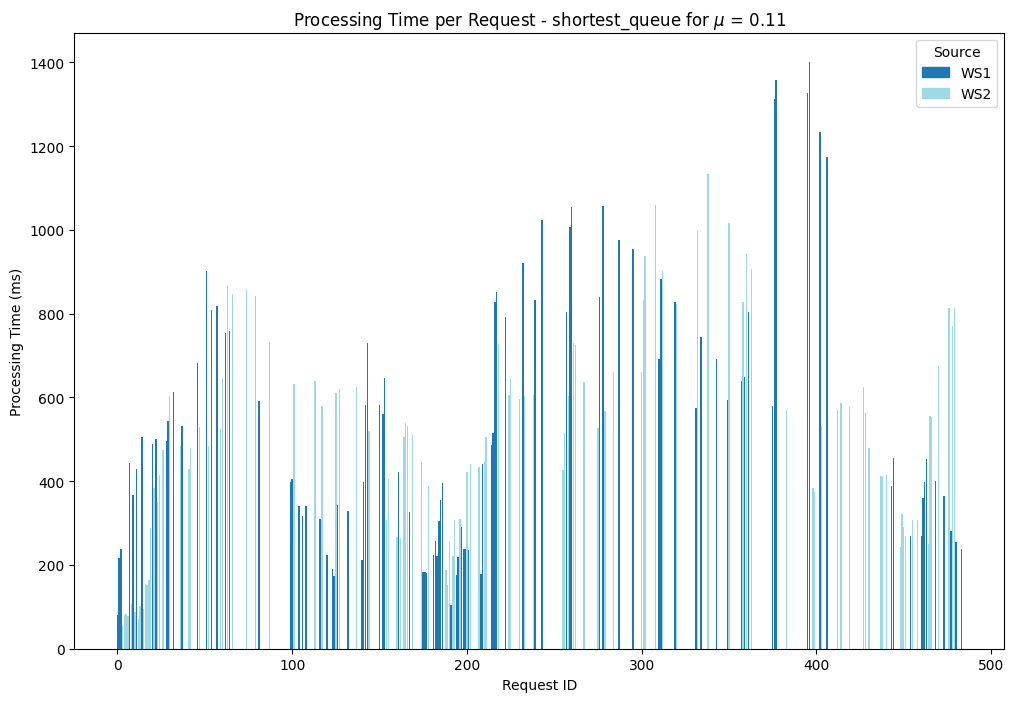

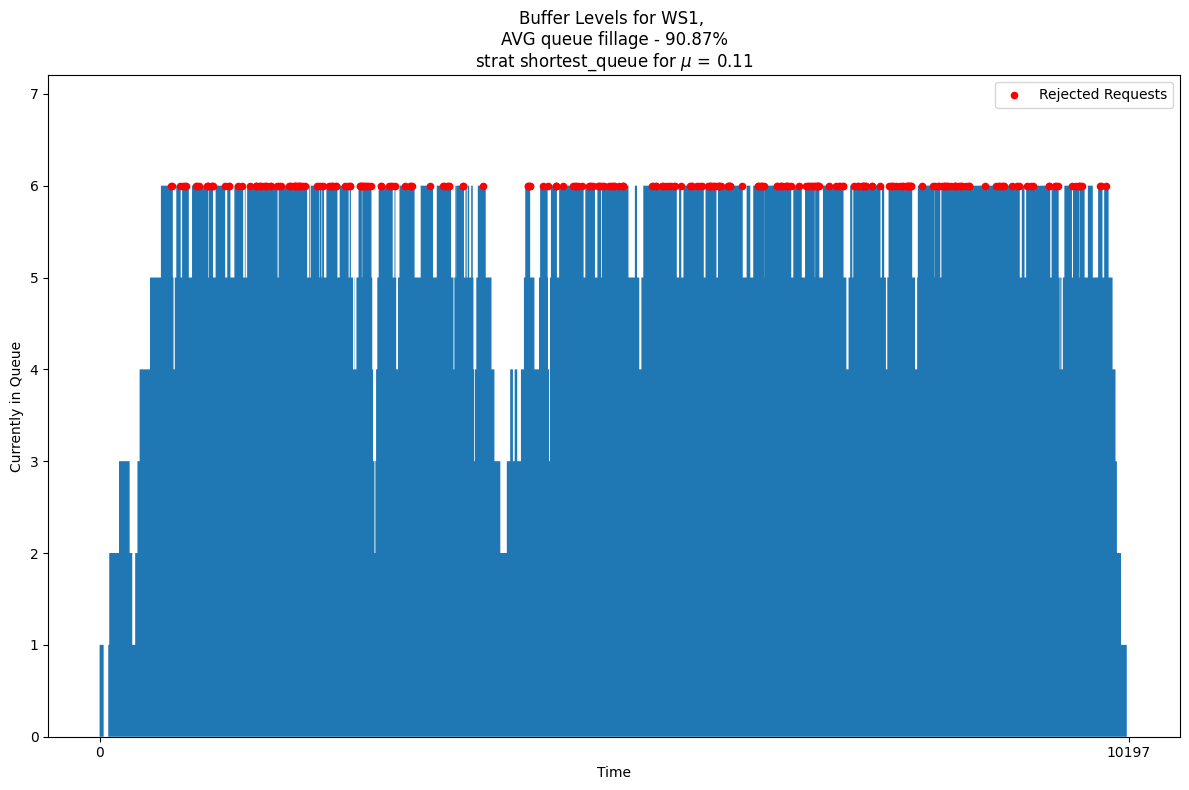

{'WS1': np.float64(90.87)}


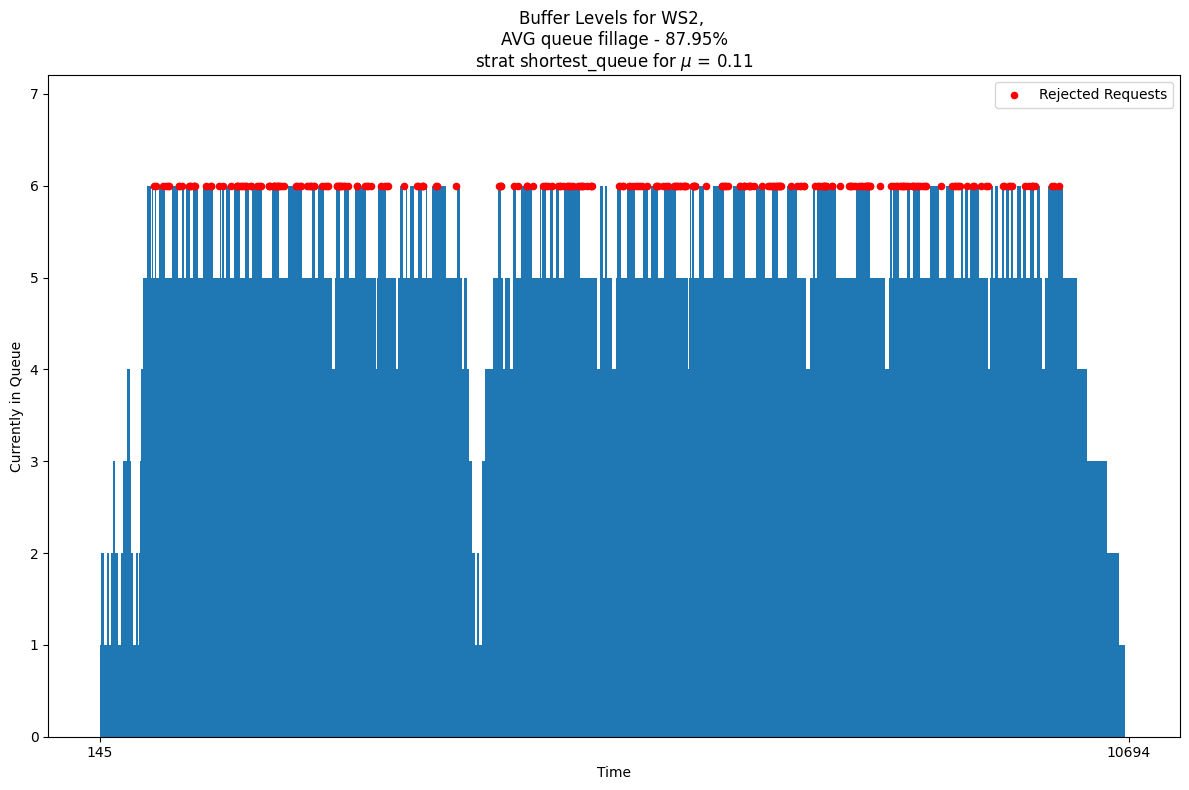

{'WS1': np.float64(90.87), 'WS2': np.float64(87.95)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 167
Odrzucone zgłoszenia: 345


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


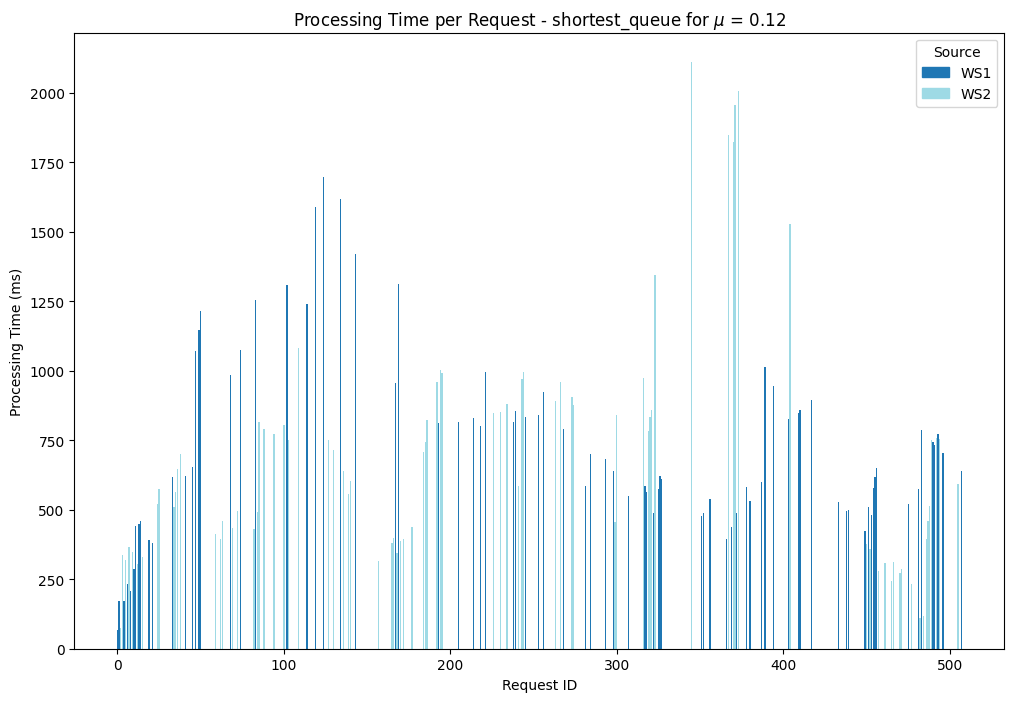

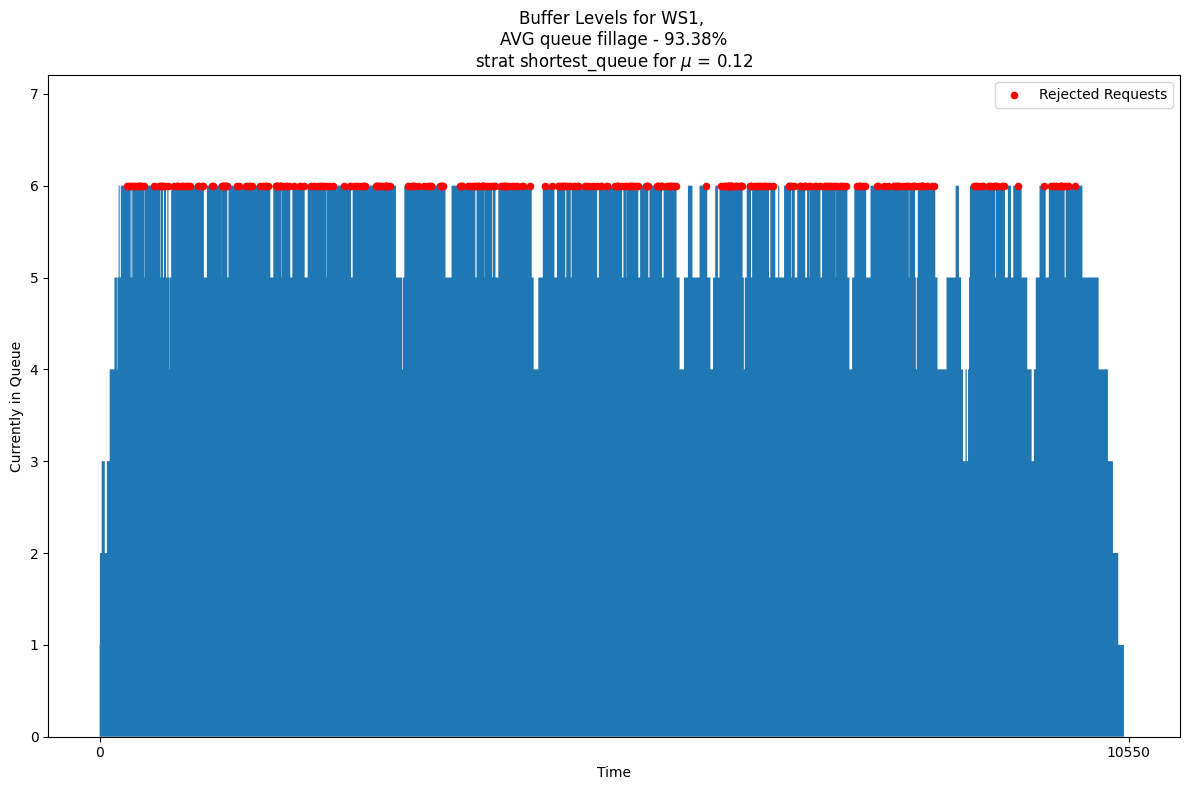

{'WS1': np.float64(93.38)}


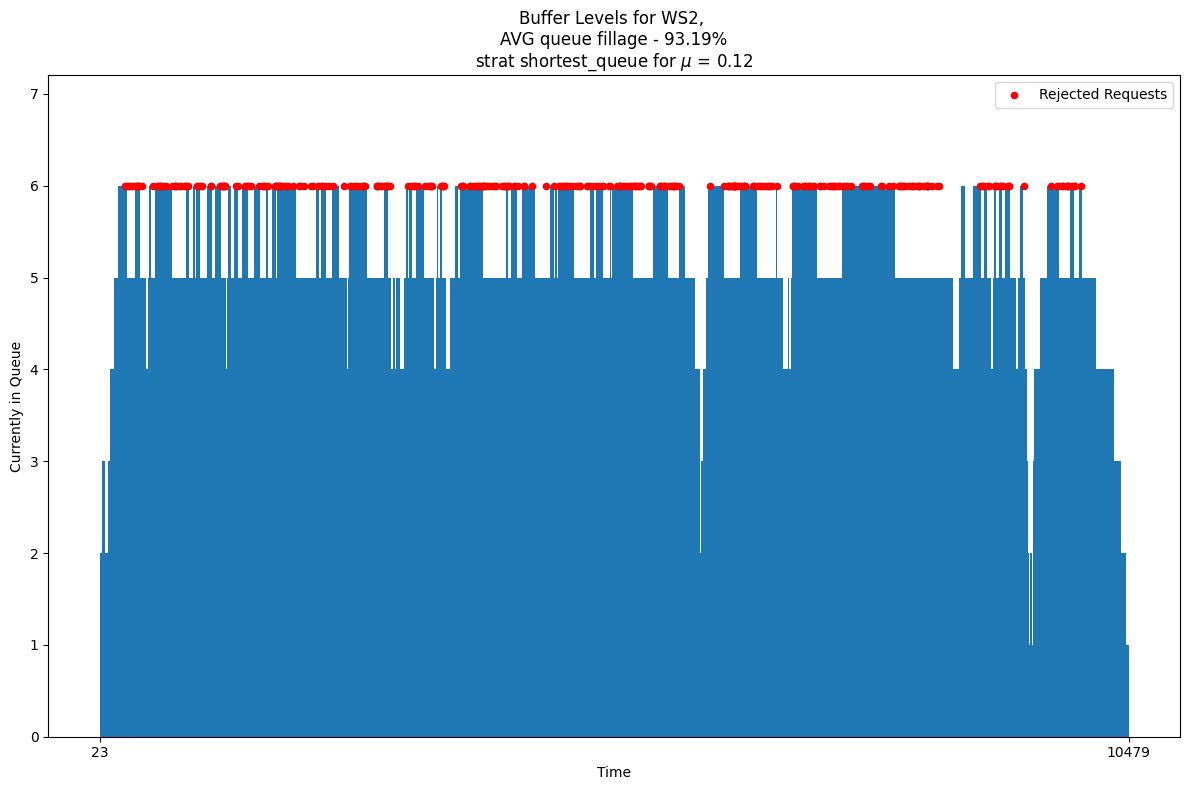

{'WS1': np.float64(93.38), 'WS2': np.float64(93.19)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 147
Odrzucone zgłoszenia: 324


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


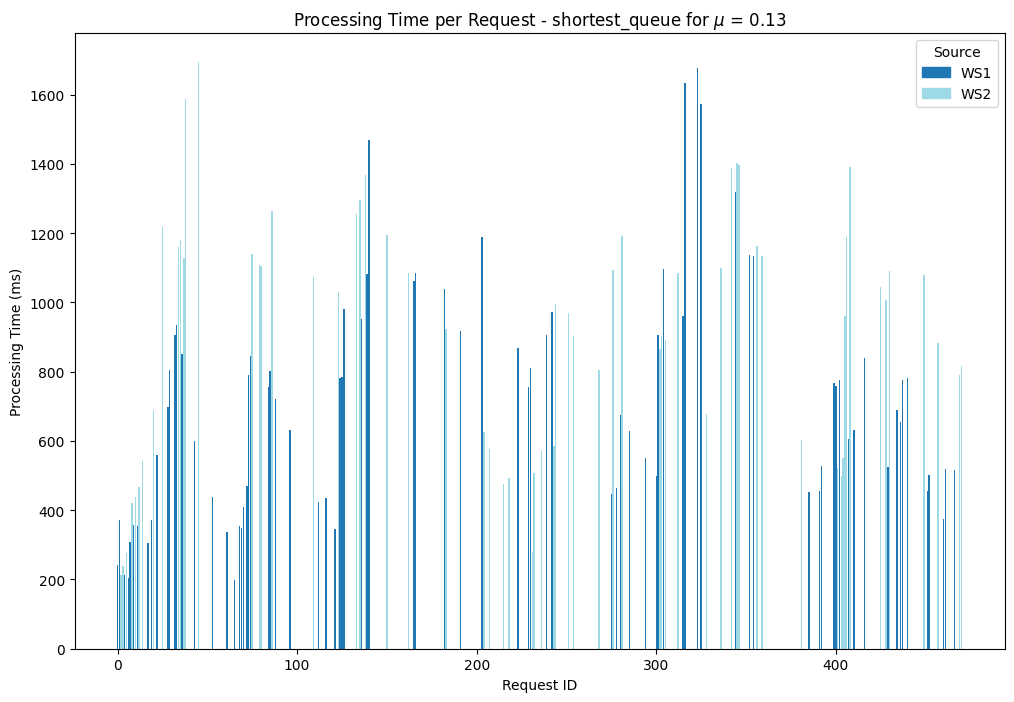

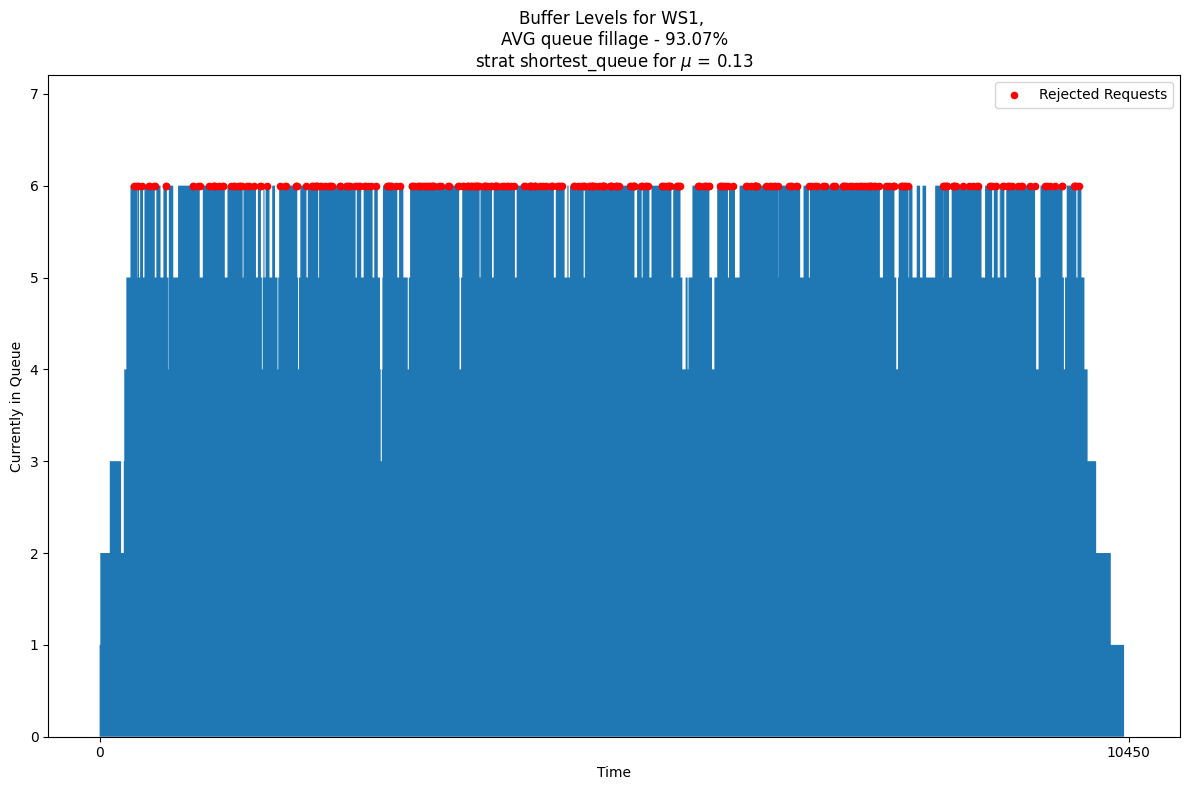

{'WS1': np.float64(93.07)}


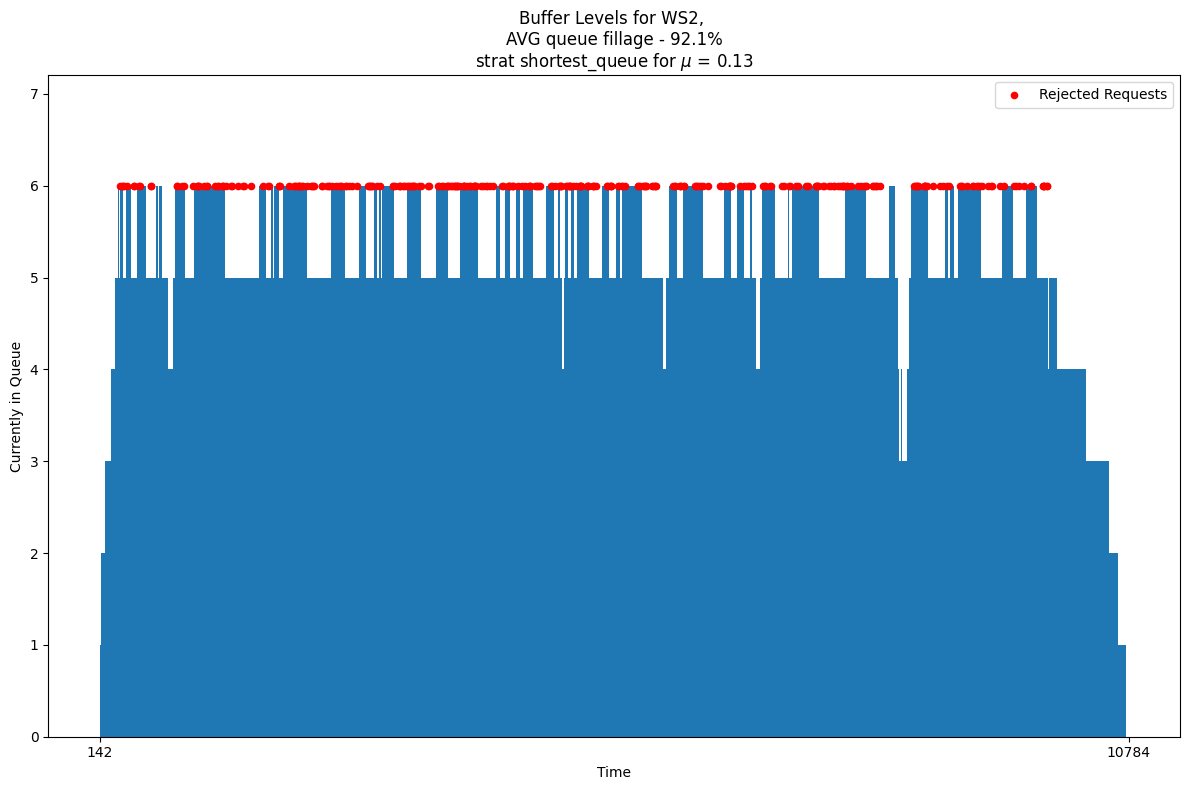

{'WS1': np.float64(93.07), 'WS2': np.float64(92.1)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 159
Odrzucone zgłoszenia: 328


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


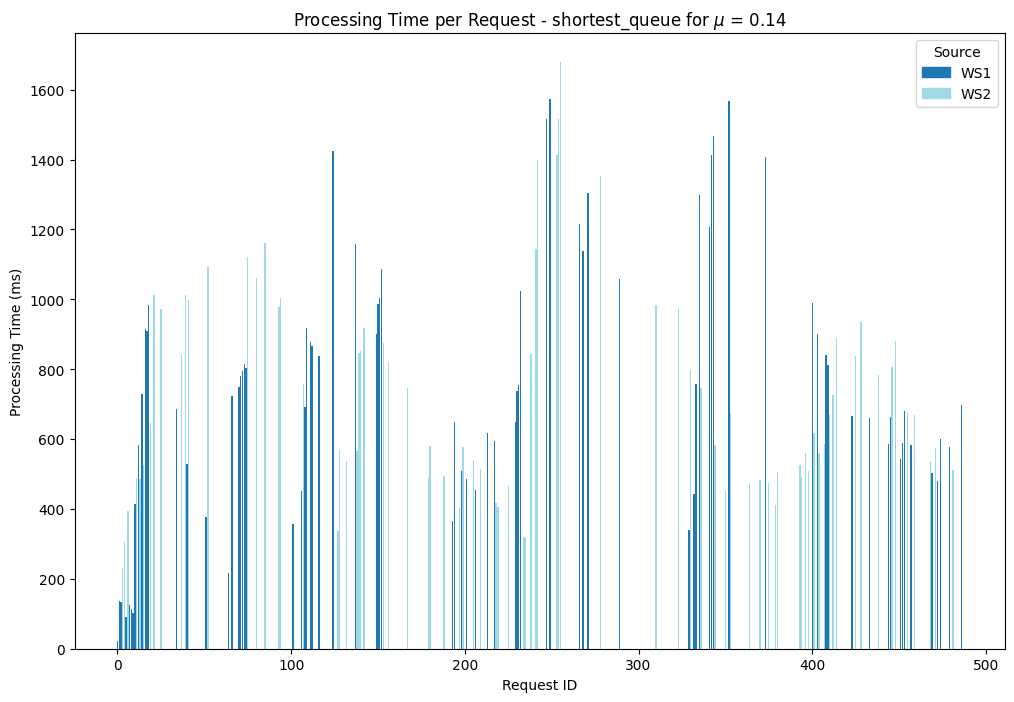

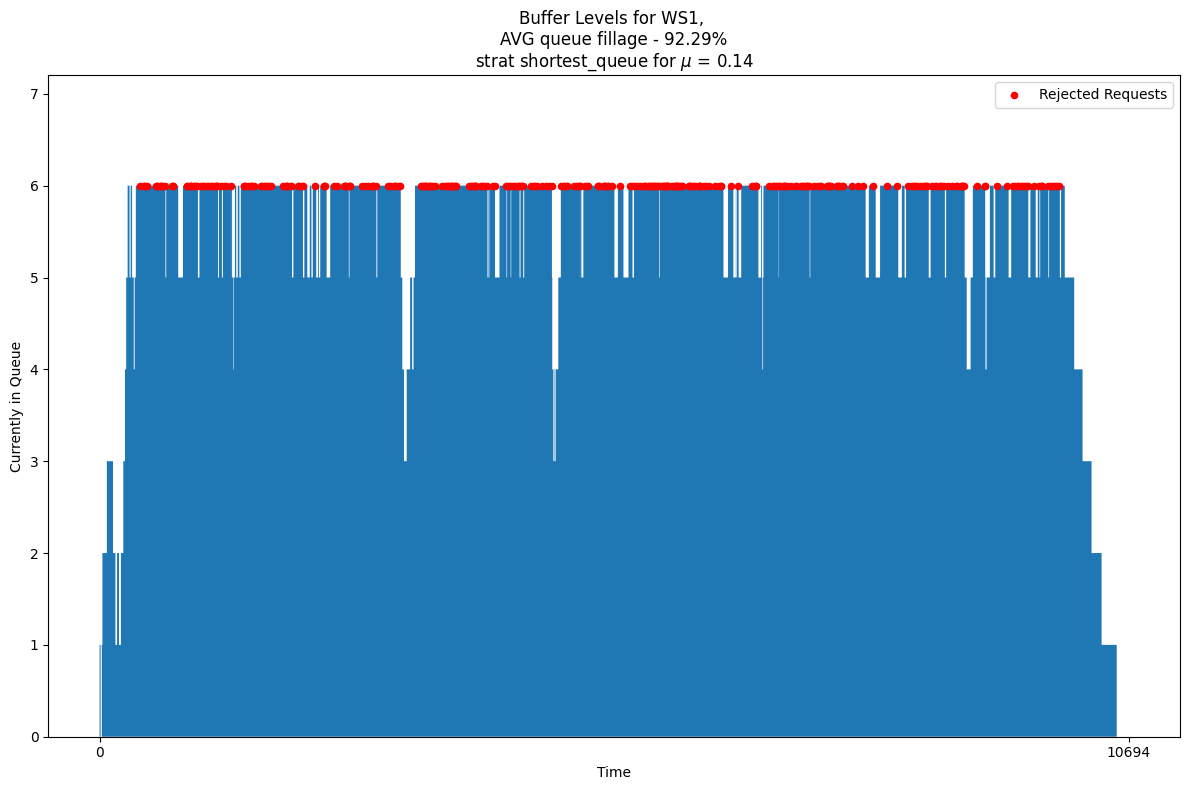

{'WS1': np.float64(92.29)}


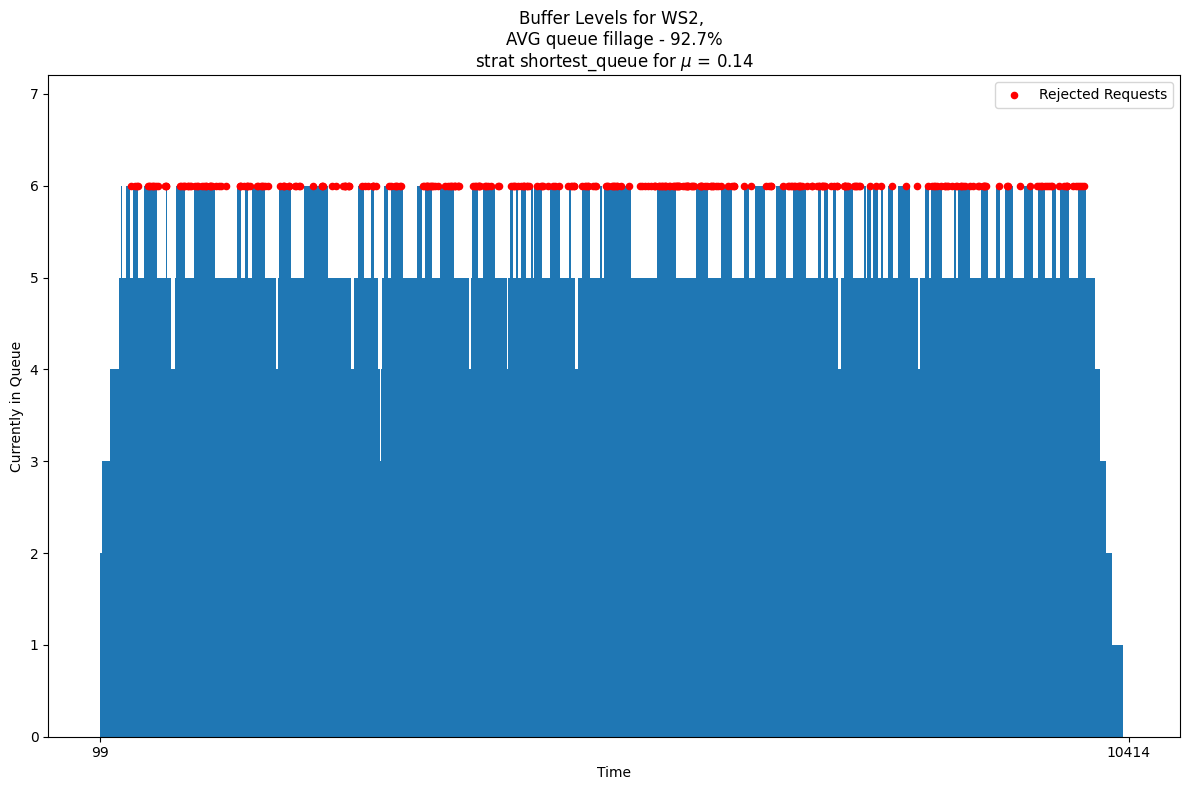

{'WS1': np.float64(92.29), 'WS2': np.float64(92.7)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 126
Odrzucone zgłoszenia: 366


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


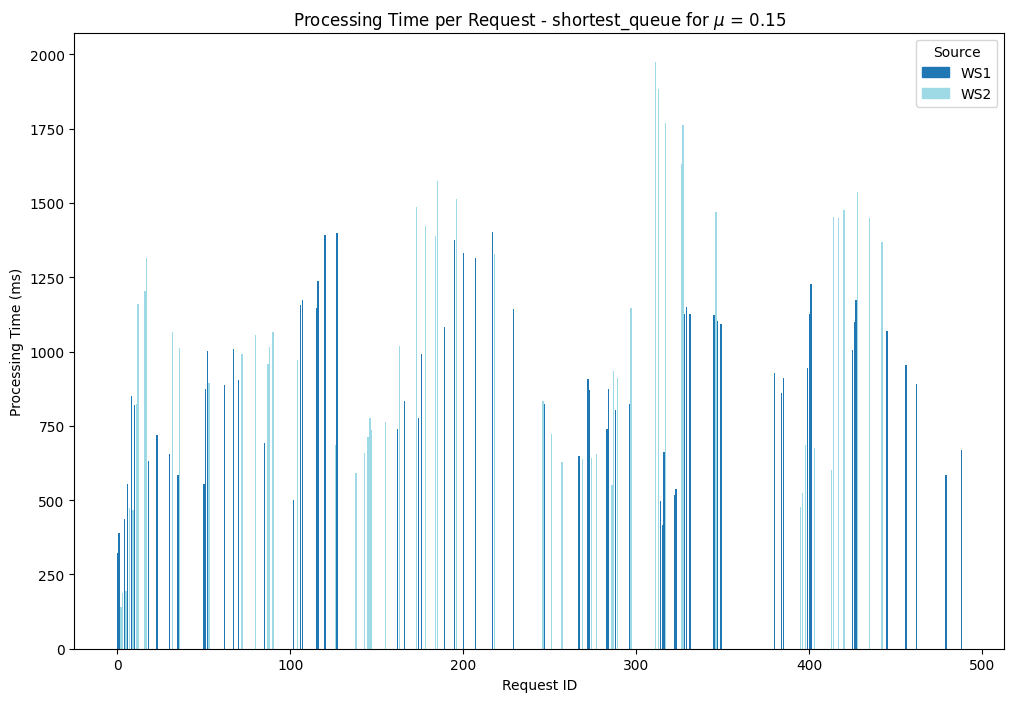

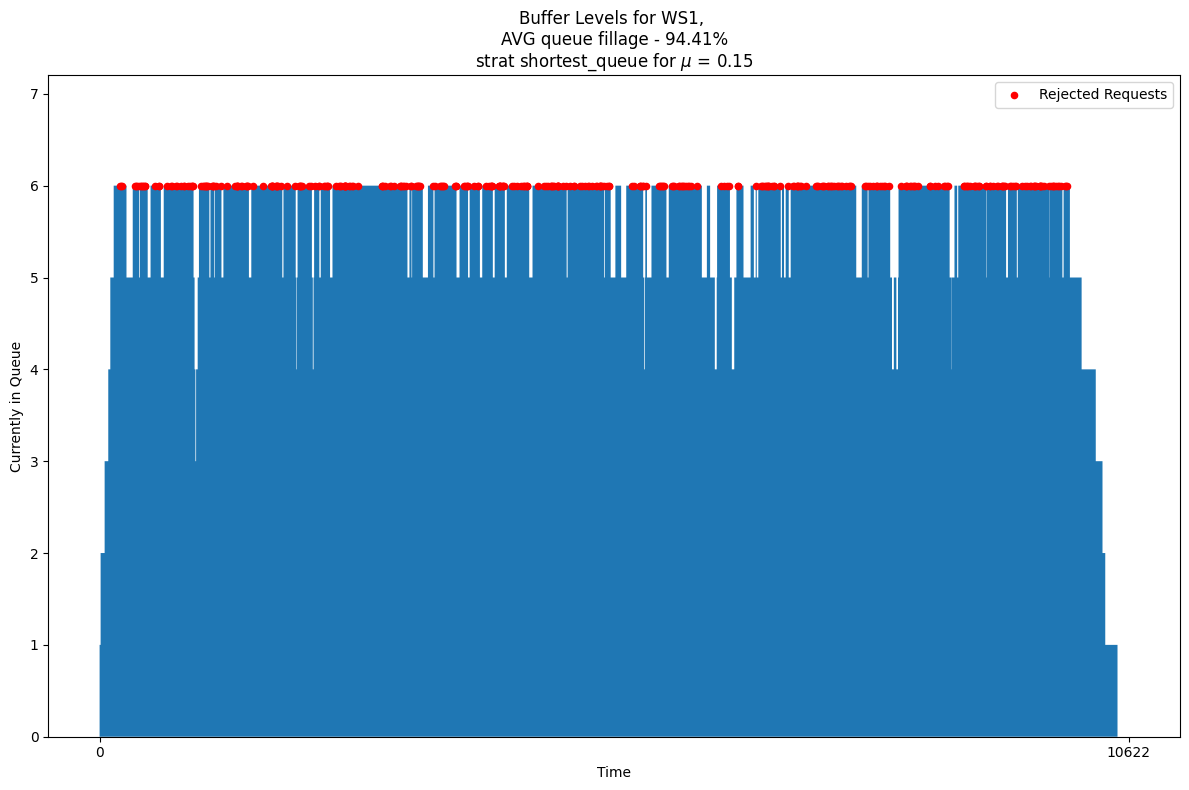

{'WS1': np.float64(94.41)}


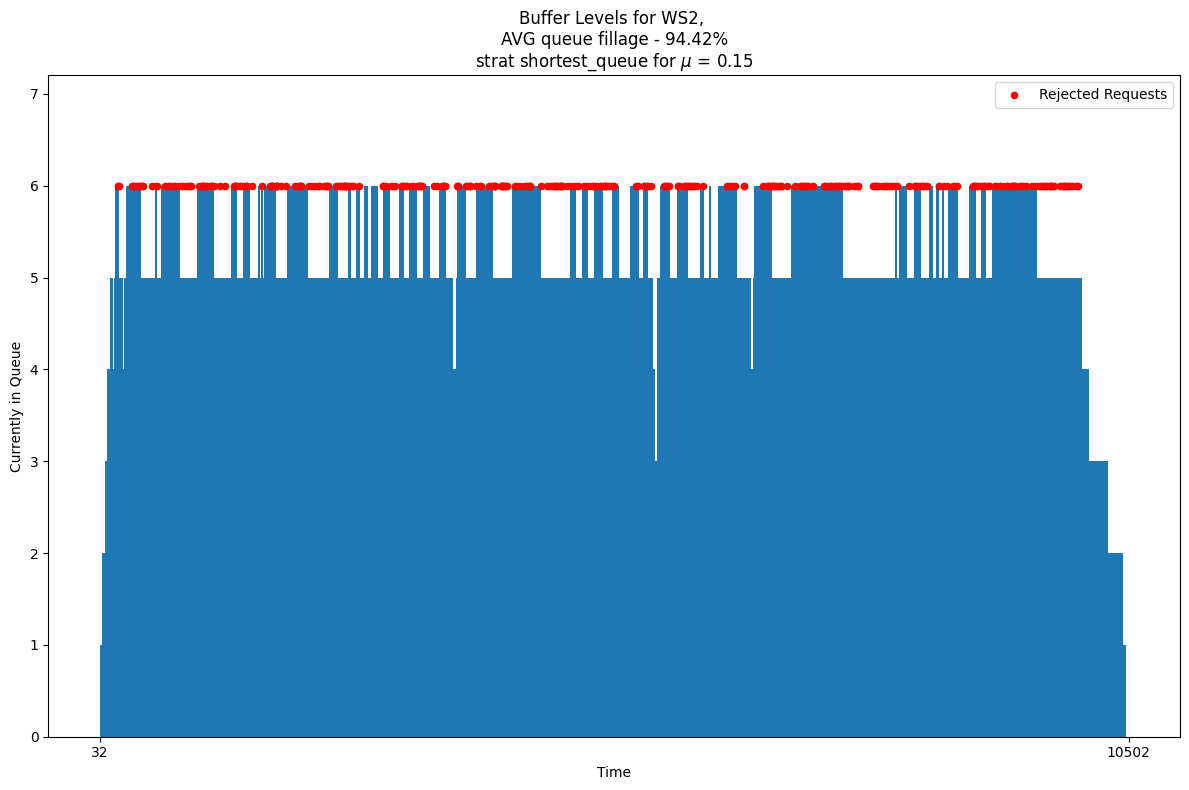

{'WS1': np.float64(94.41), 'WS2': np.float64(94.42)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 125
Odrzucone zgłoszenia: 335


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


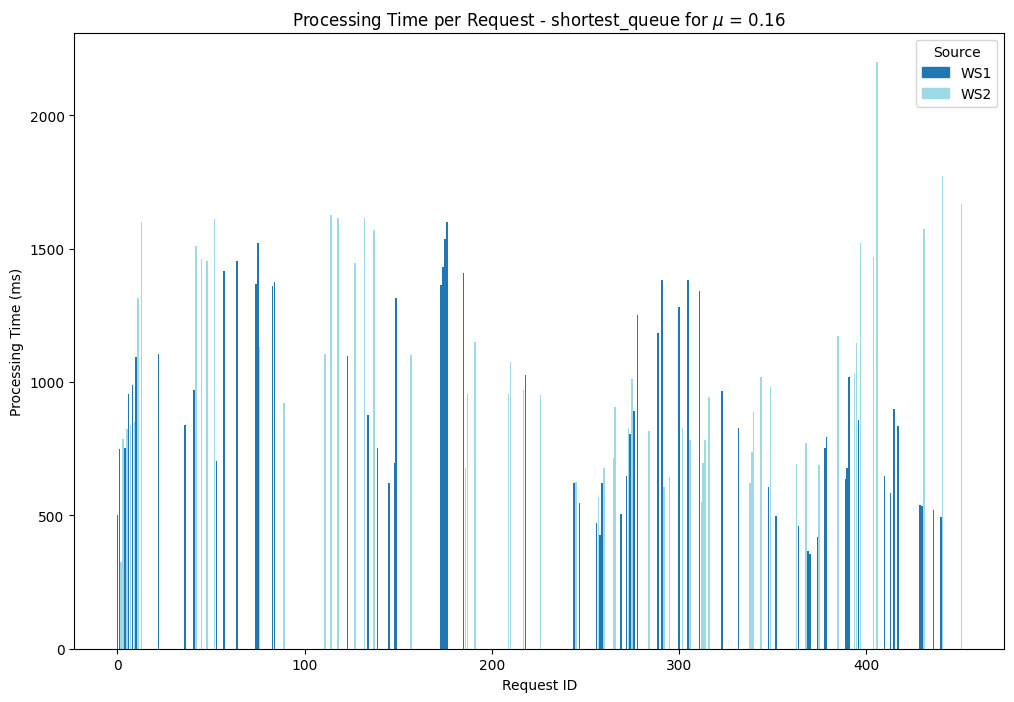

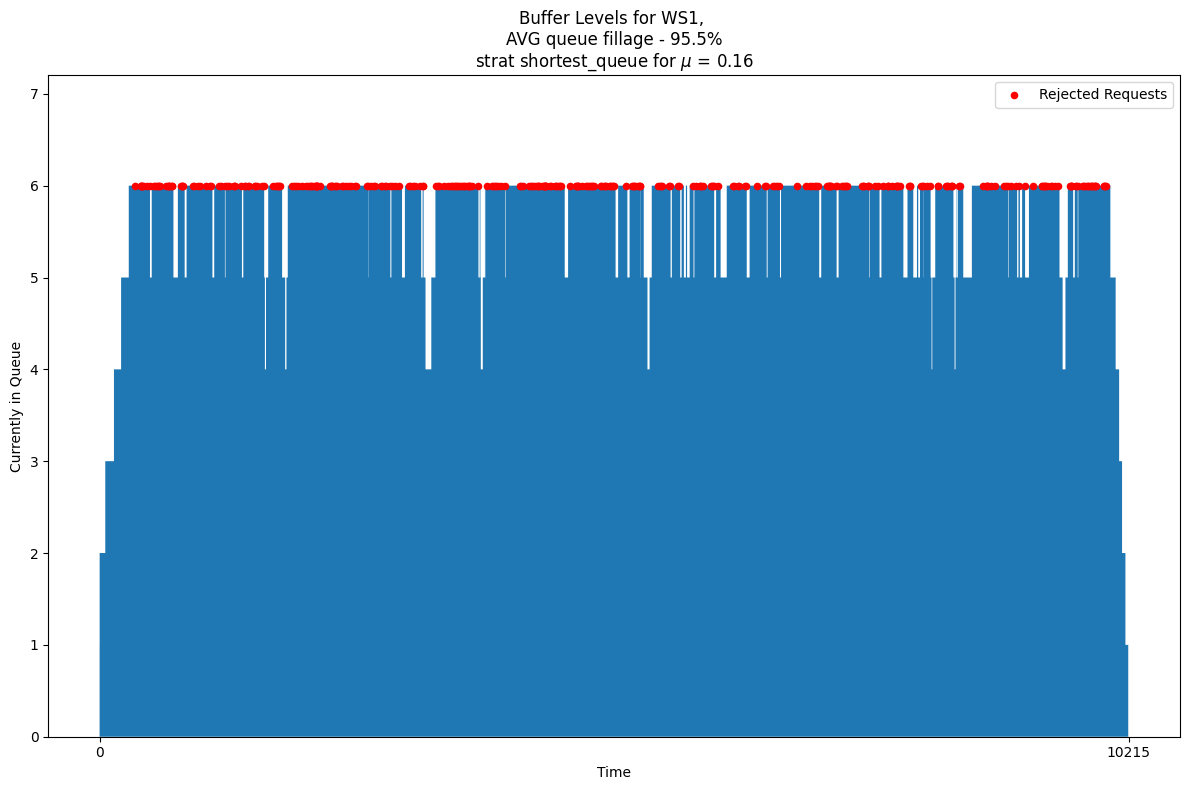

{'WS1': np.float64(95.5)}


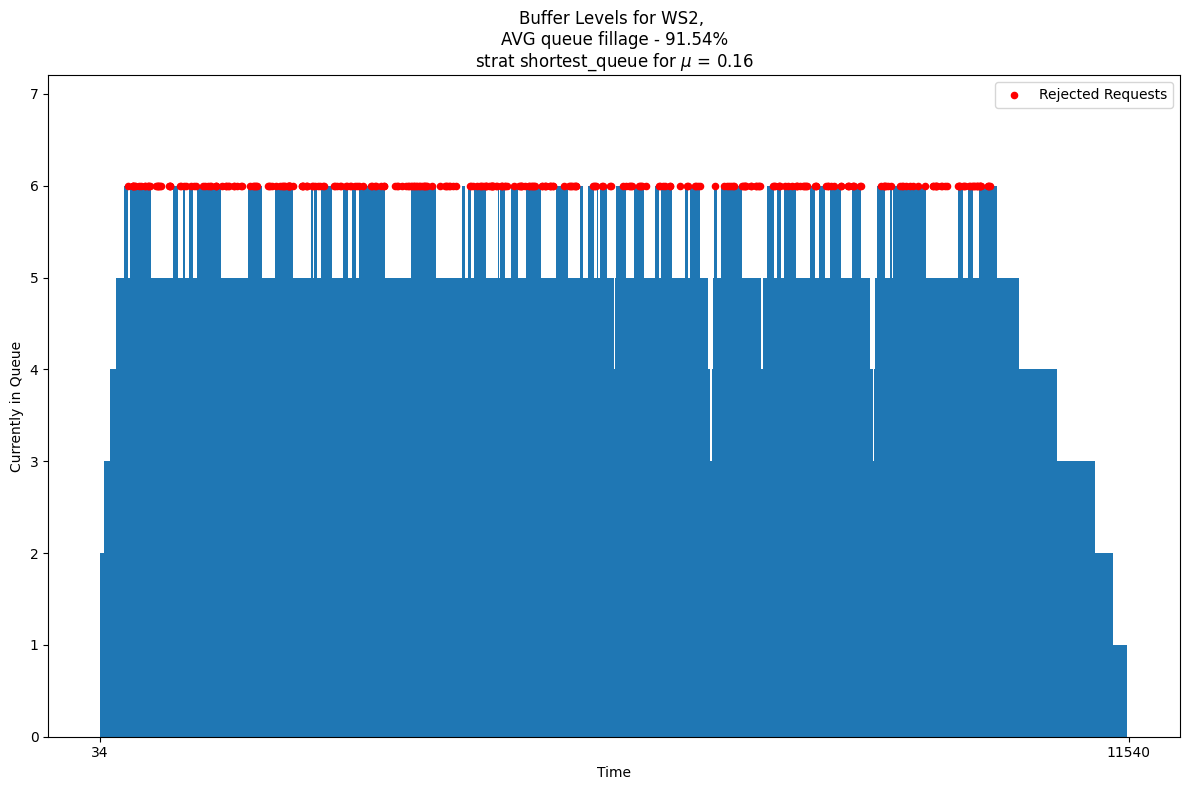

{'WS1': np.float64(95.5), 'WS2': np.float64(91.54)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 126
Odrzucone zgłoszenia: 365


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


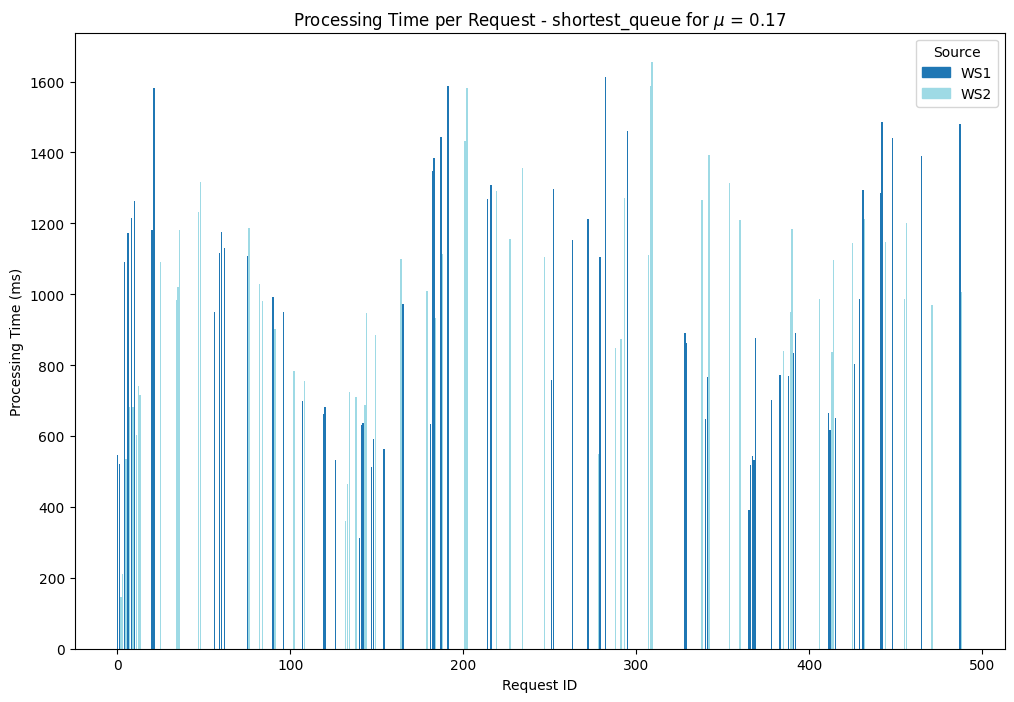

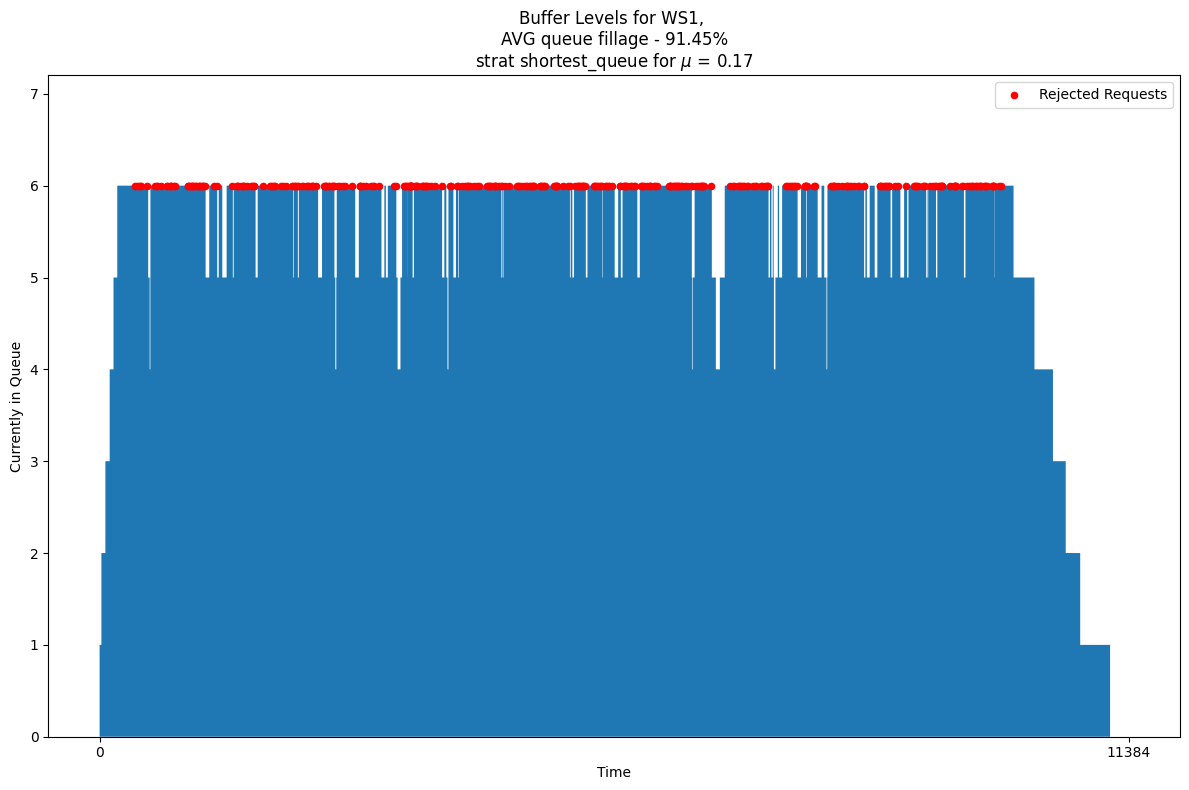

{'WS1': np.float64(91.45)}


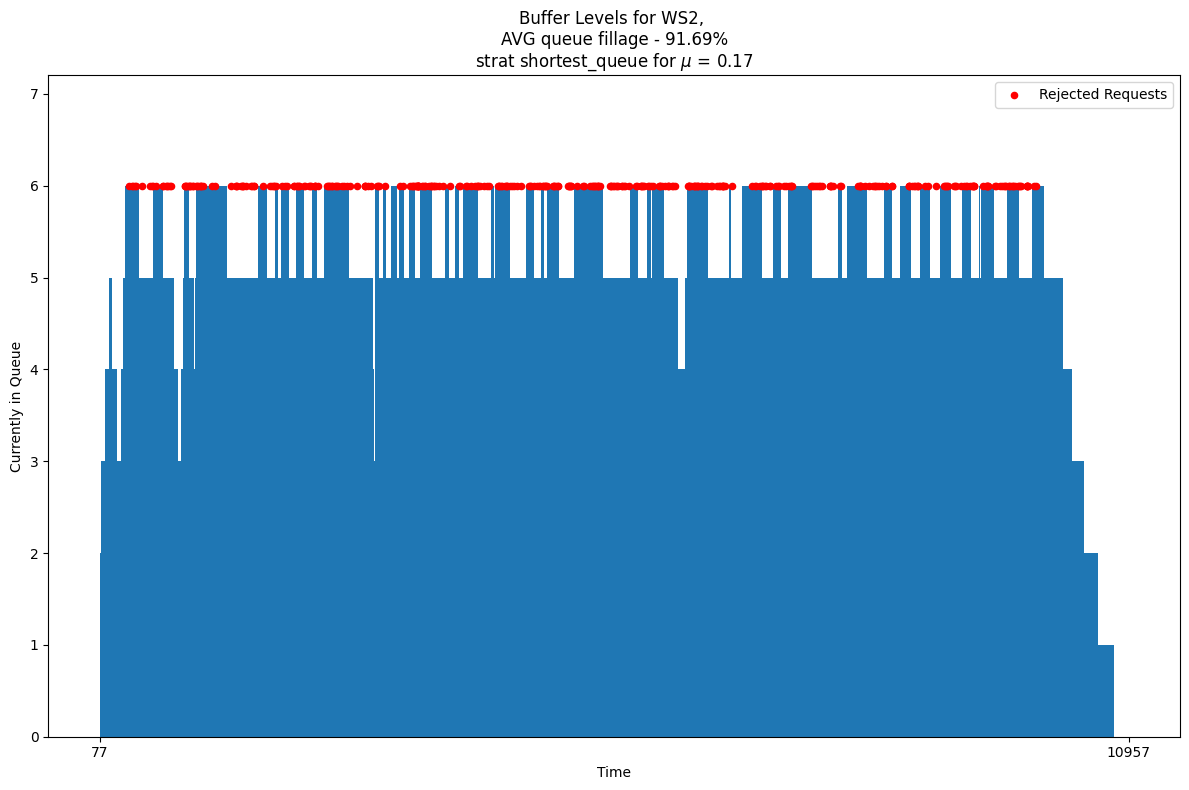

{'WS1': np.float64(91.45), 'WS2': np.float64(91.69)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 134
Odrzucone zgłoszenia: 331


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


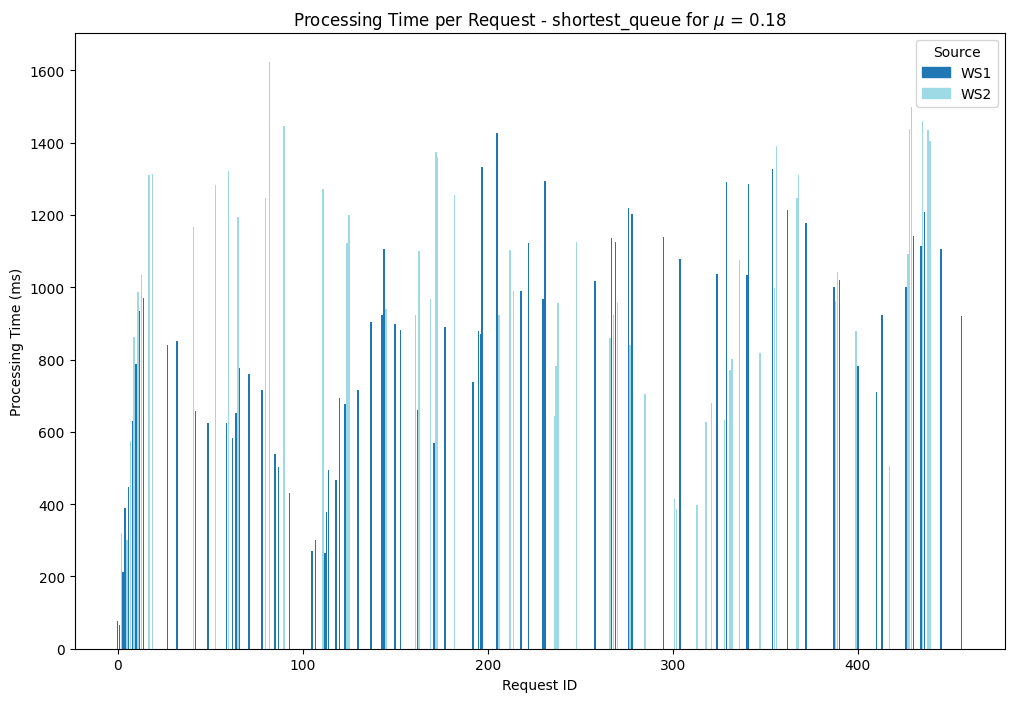

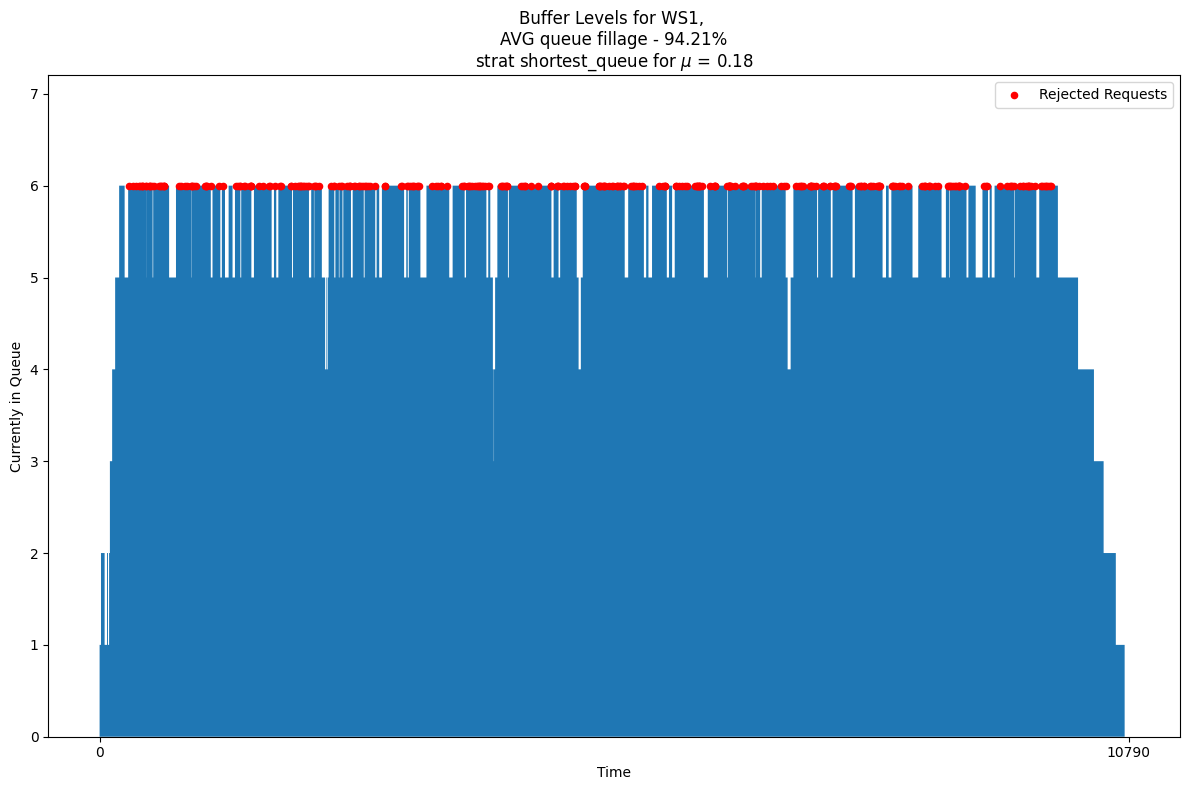

{'WS1': np.float64(94.21)}


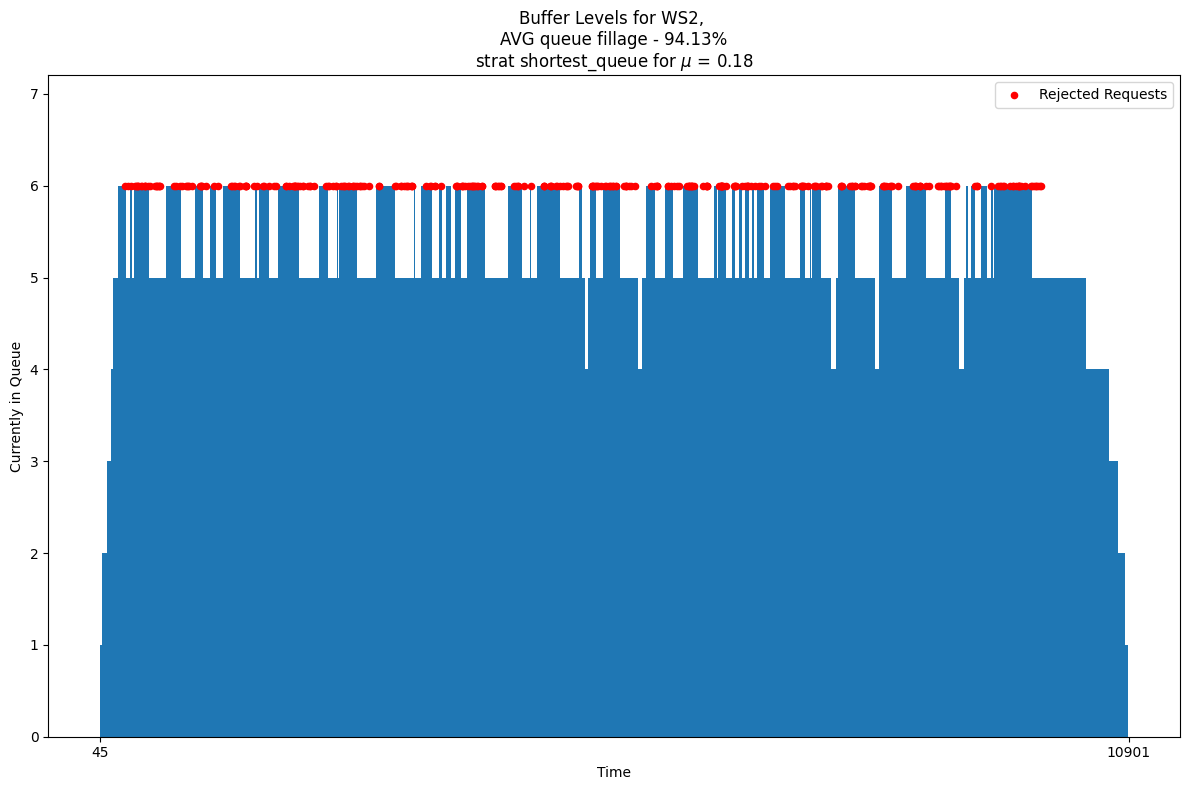

{'WS1': np.float64(94.21), 'WS2': np.float64(94.13)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 103
Odrzucone zgłoszenia: 356


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


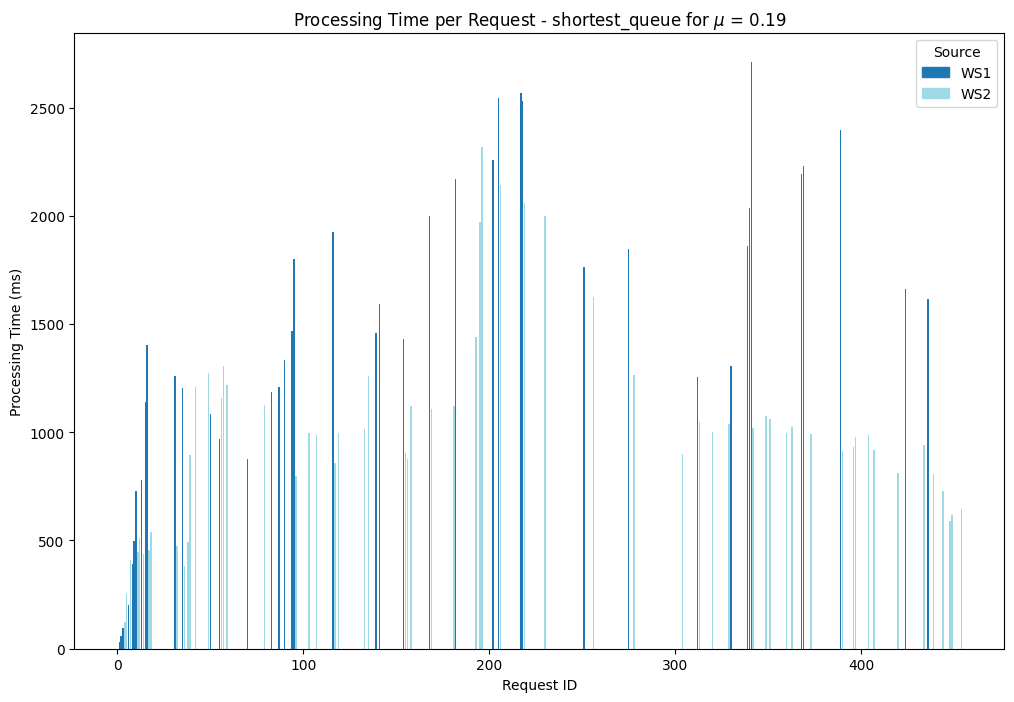

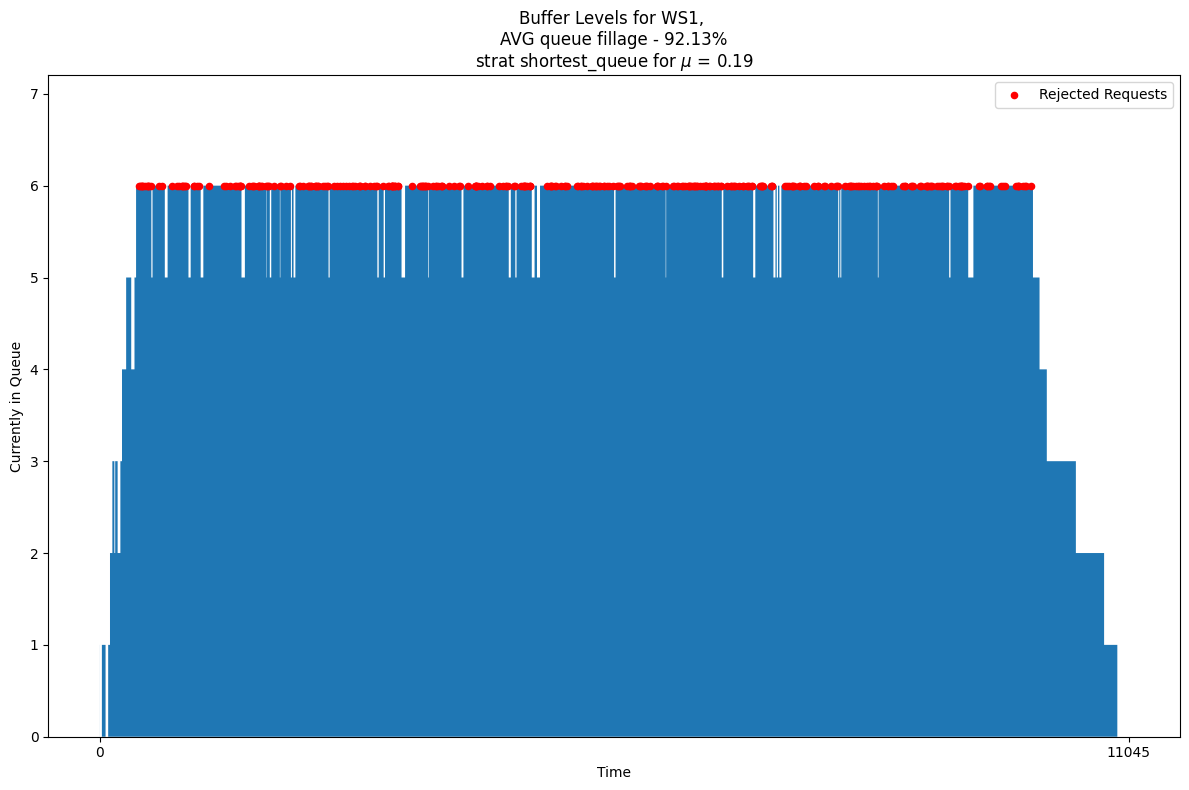

{'WS1': np.float64(92.13)}


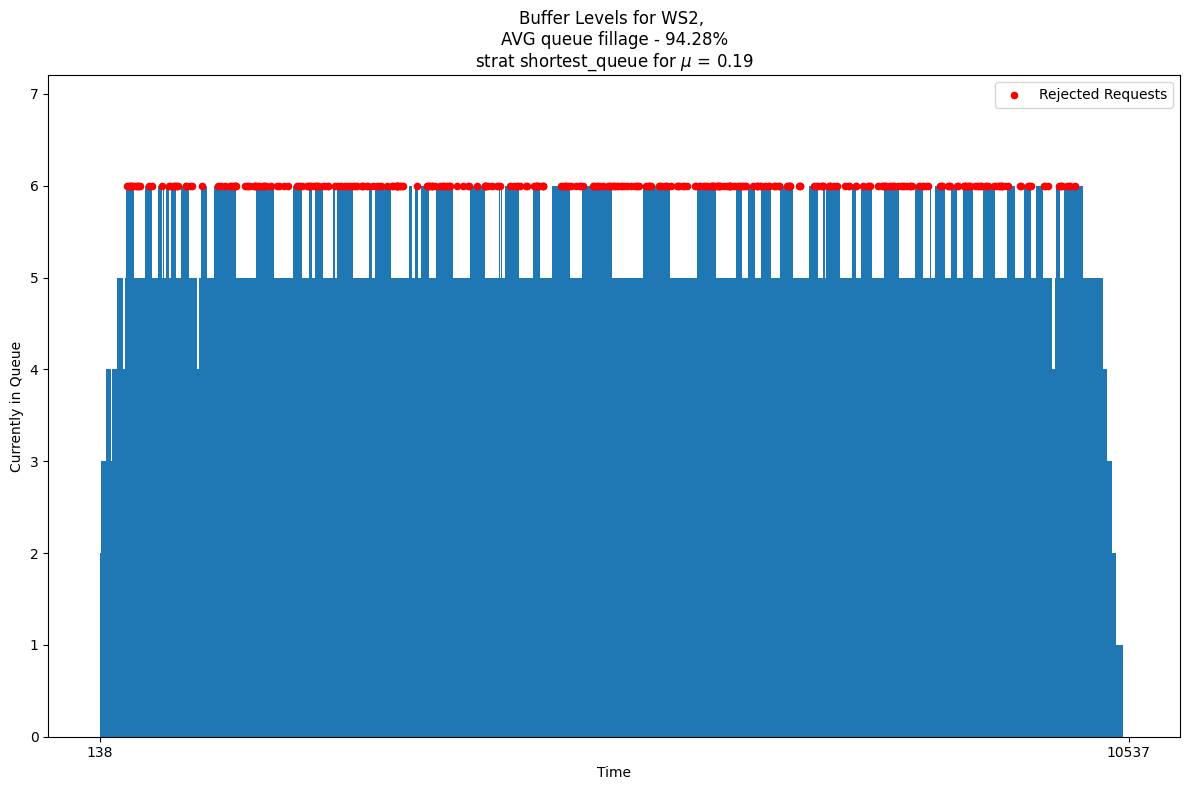

{'WS1': np.float64(92.13), 'WS2': np.float64(94.28)}

Start symulacji - polityka route_shortest_queue

Polityka: route_shortest_queue
Przetworzone zgłoszenia: 109
Odrzucone zgłoszenia: 359


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


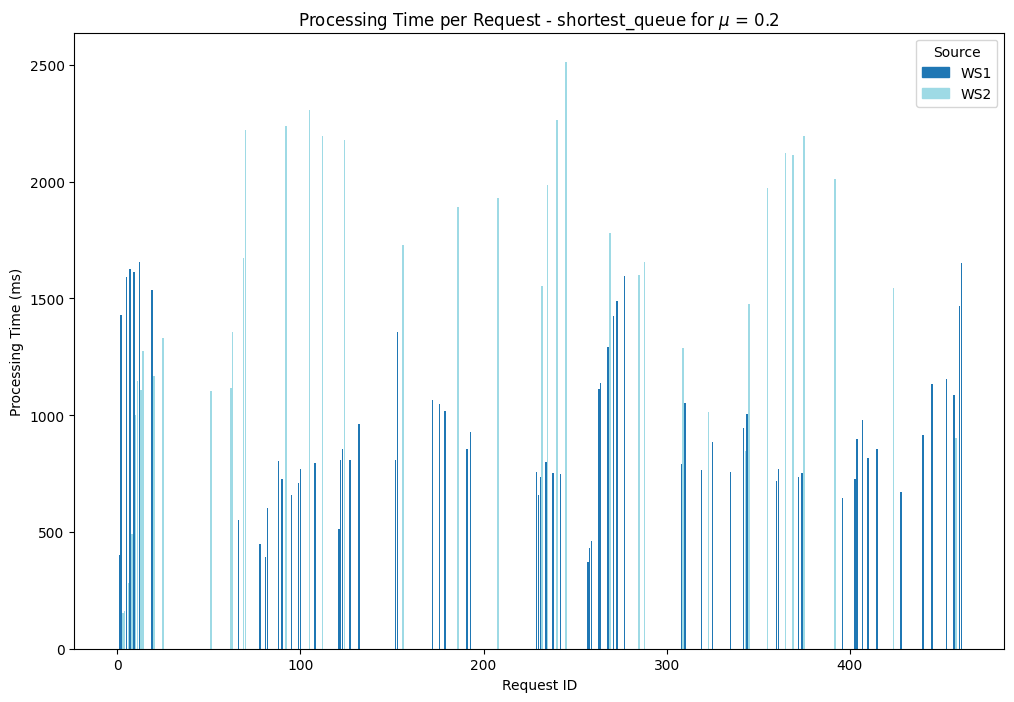

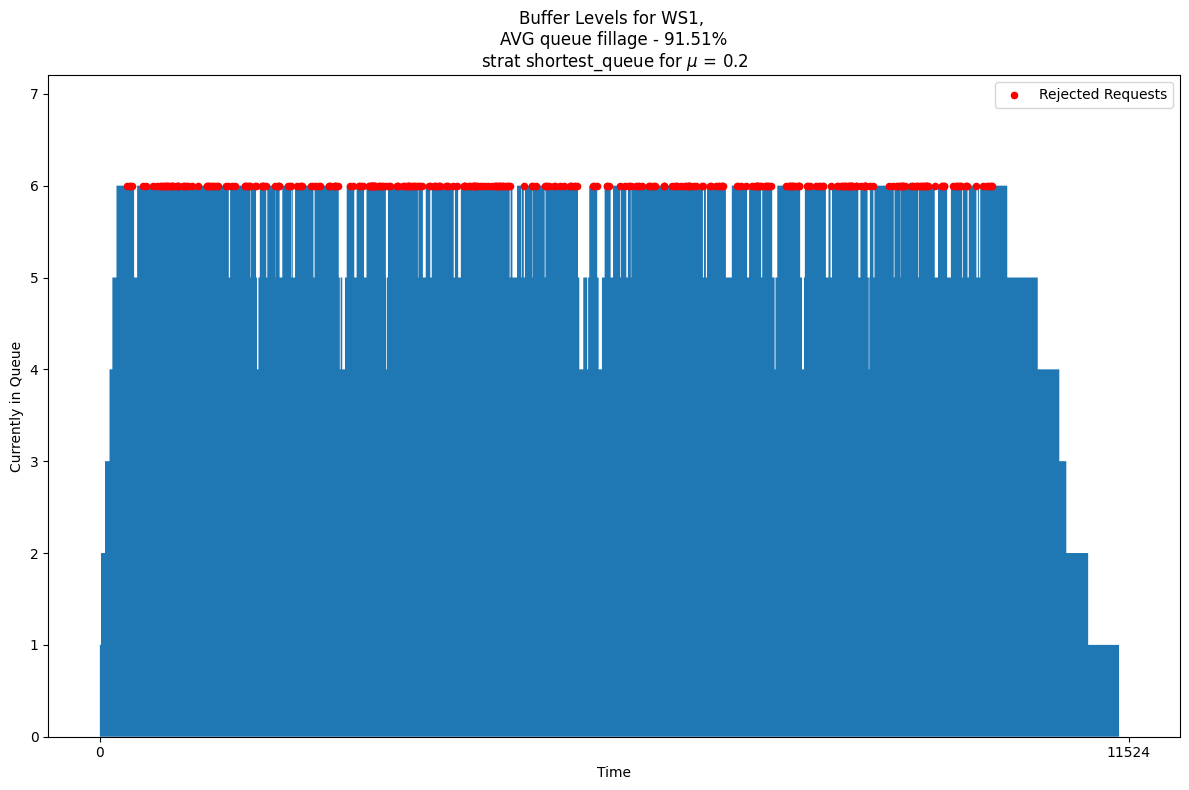

{'WS1': np.float64(91.51)}


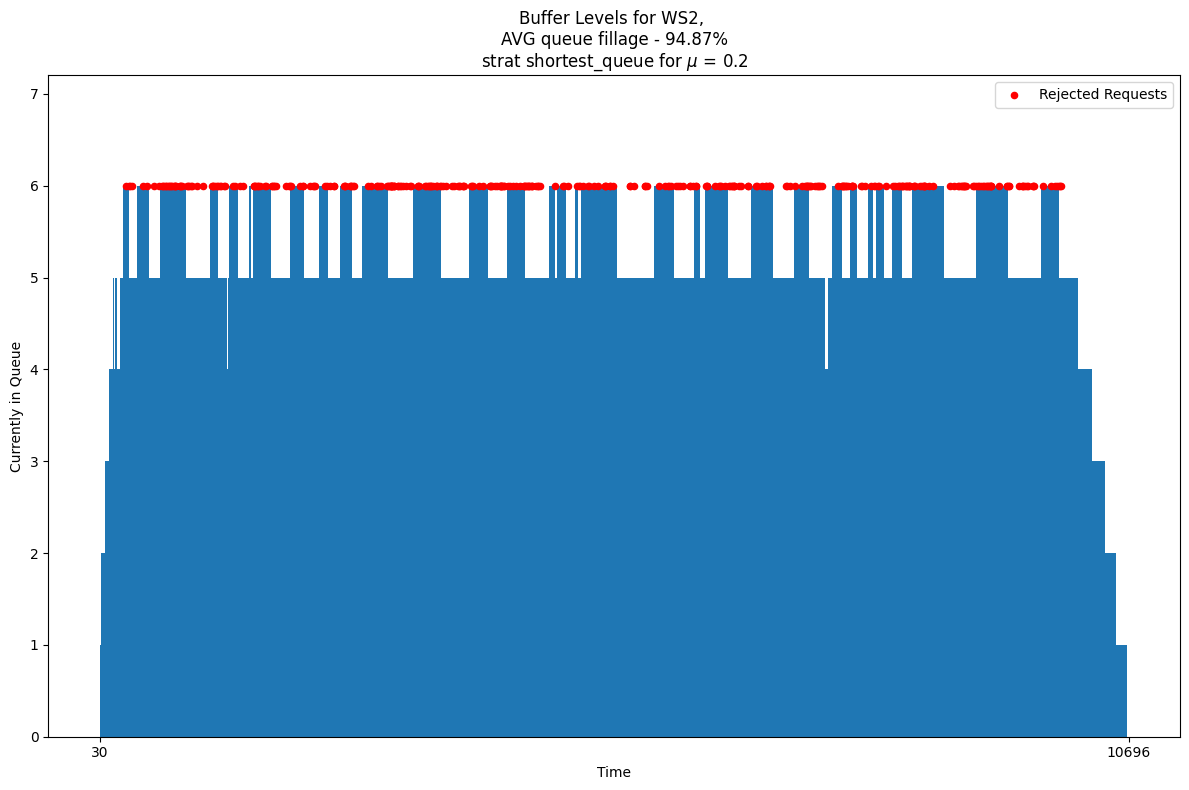

{'WS1': np.float64(91.51), 'WS2': np.float64(94.87)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 477
Odrzucone zgłoszenia: 0


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


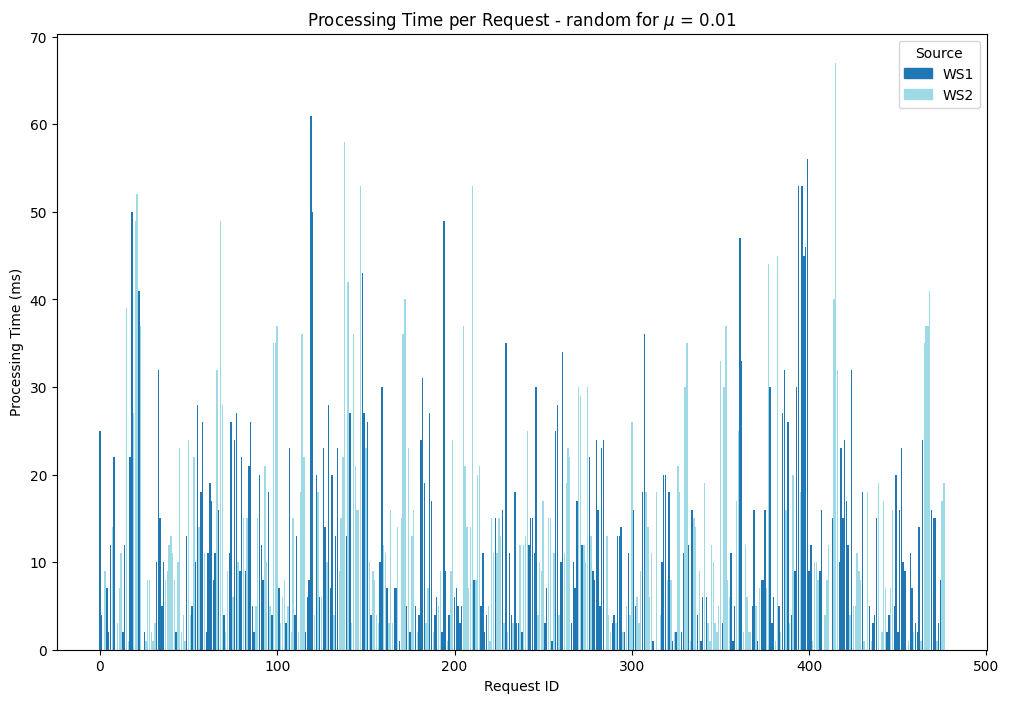

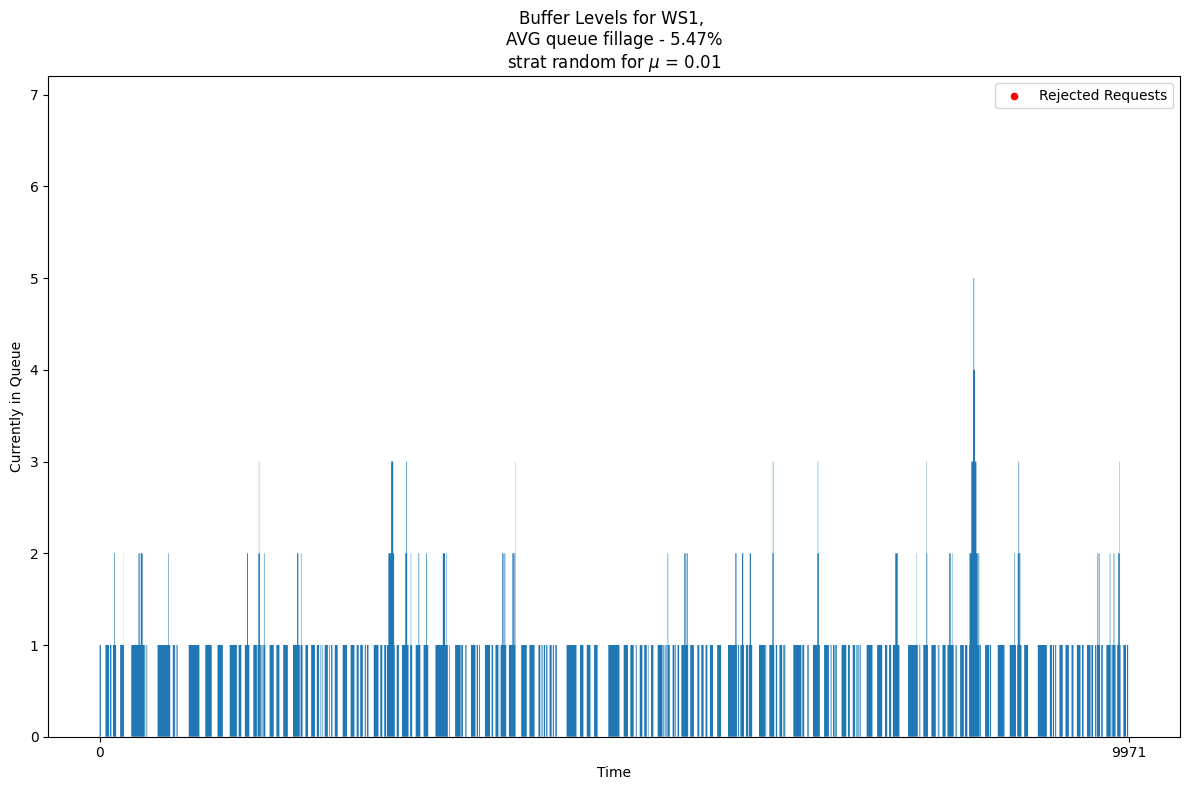

{'WS1': np.float64(5.47)}


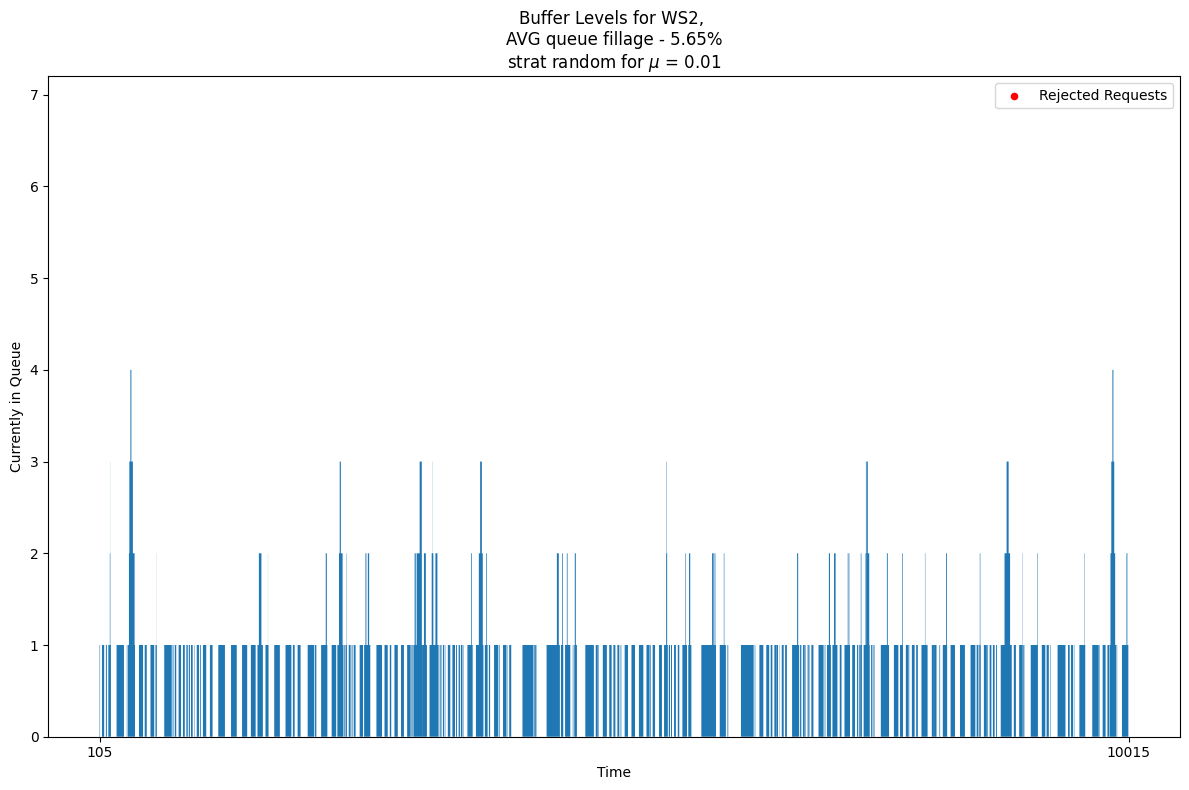

{'WS1': np.float64(5.47), 'WS2': np.float64(5.65)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 478
Odrzucone zgłoszenia: 3


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


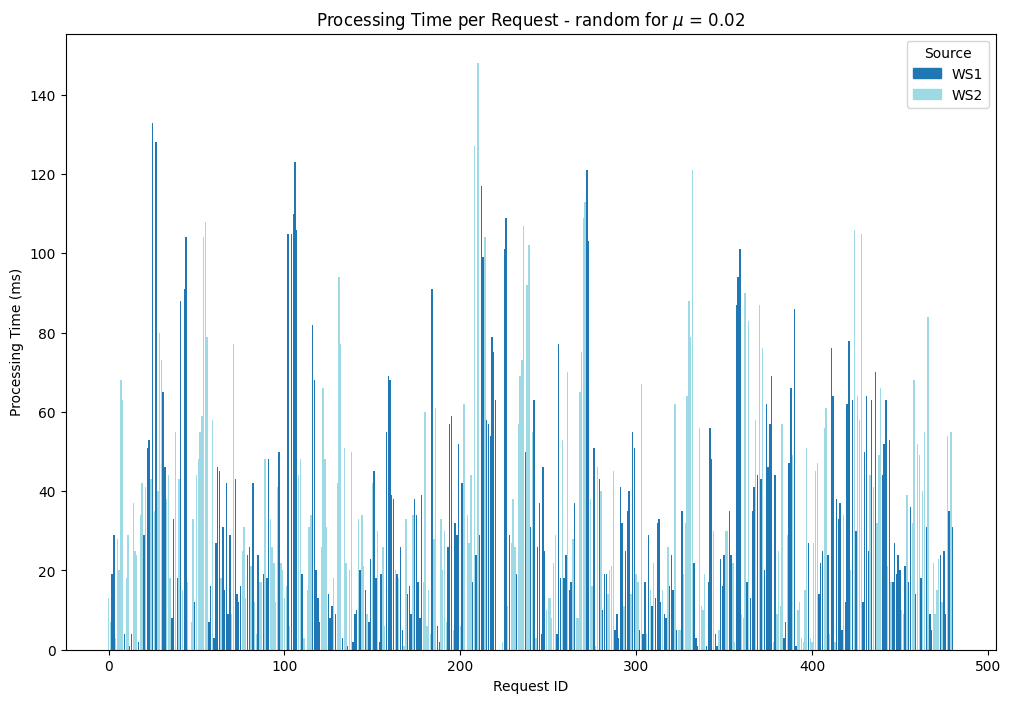

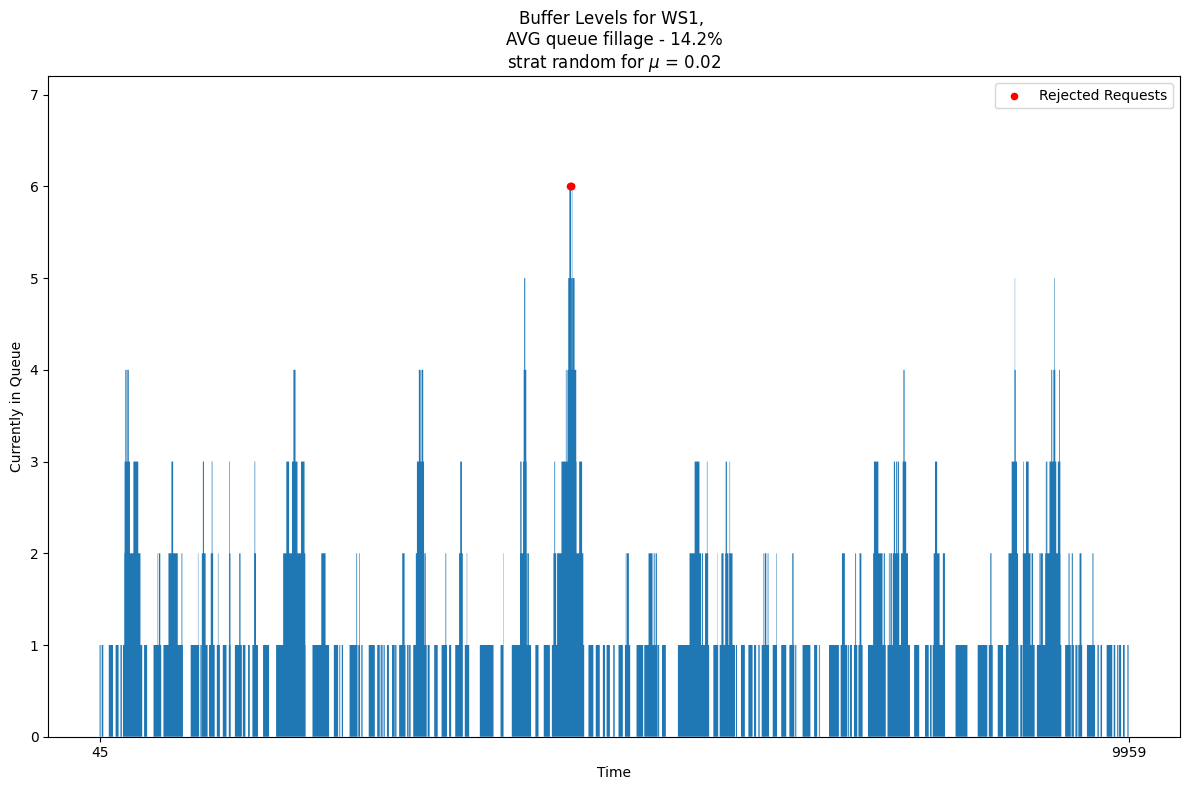

{'WS1': np.float64(14.2)}


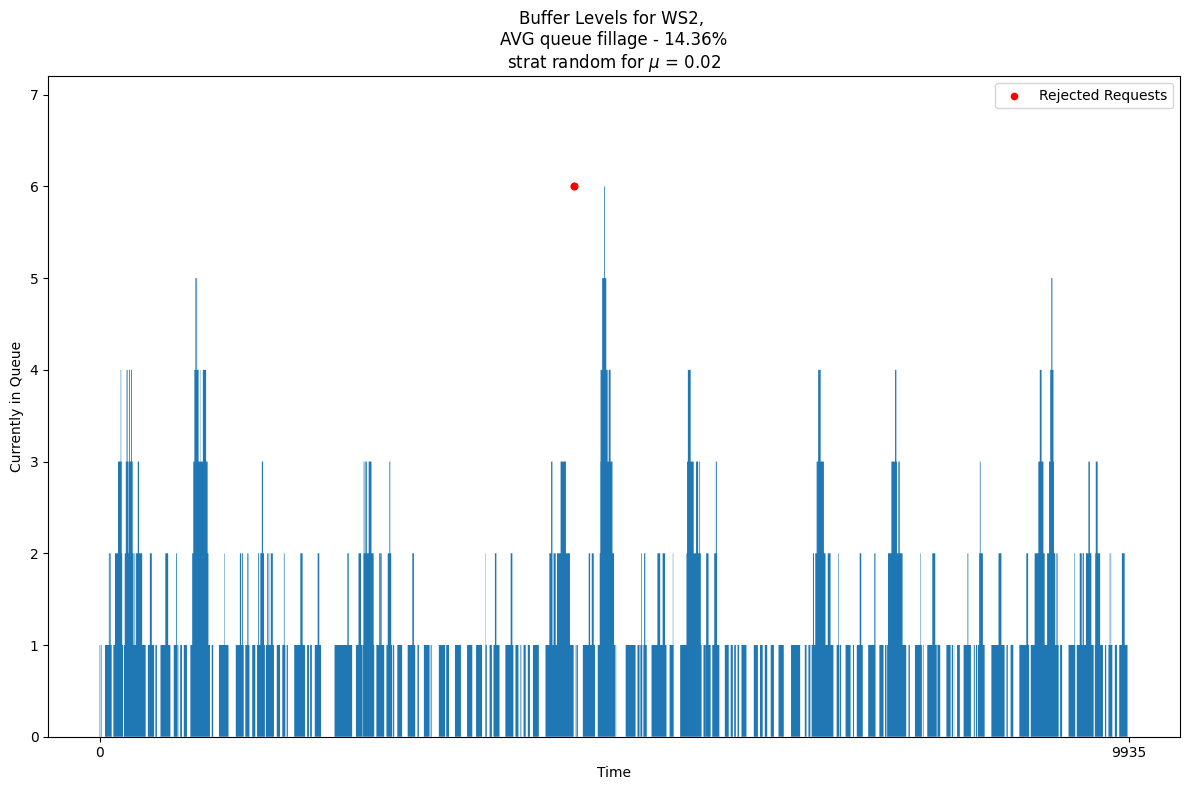

{'WS1': np.float64(14.2), 'WS2': np.float64(14.36)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 466
Odrzucone zgłoszenia: 21


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


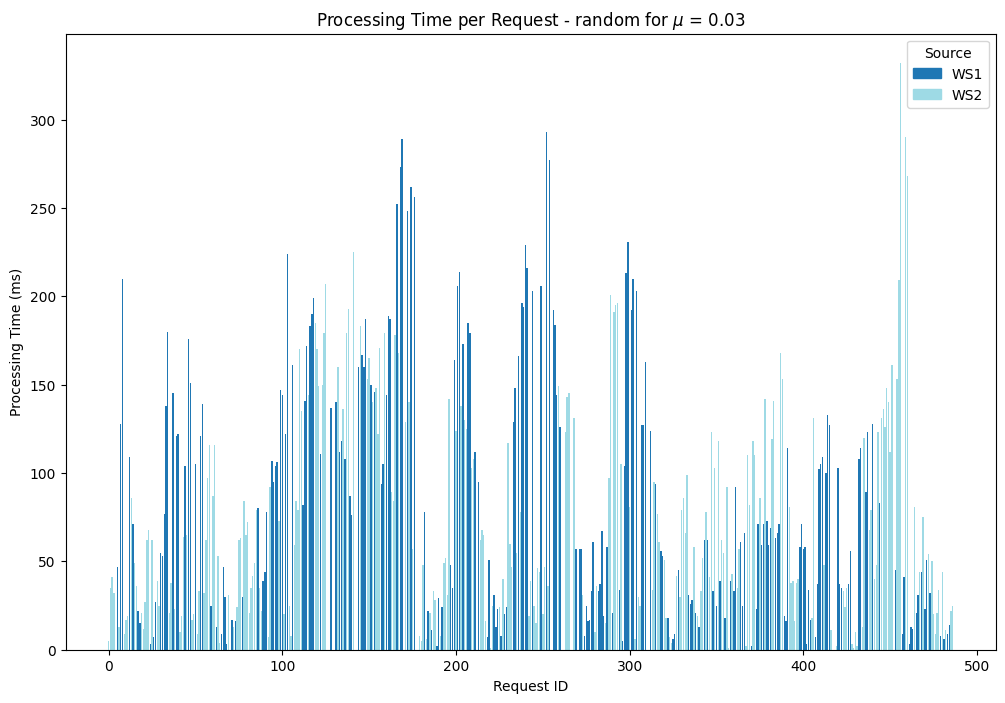

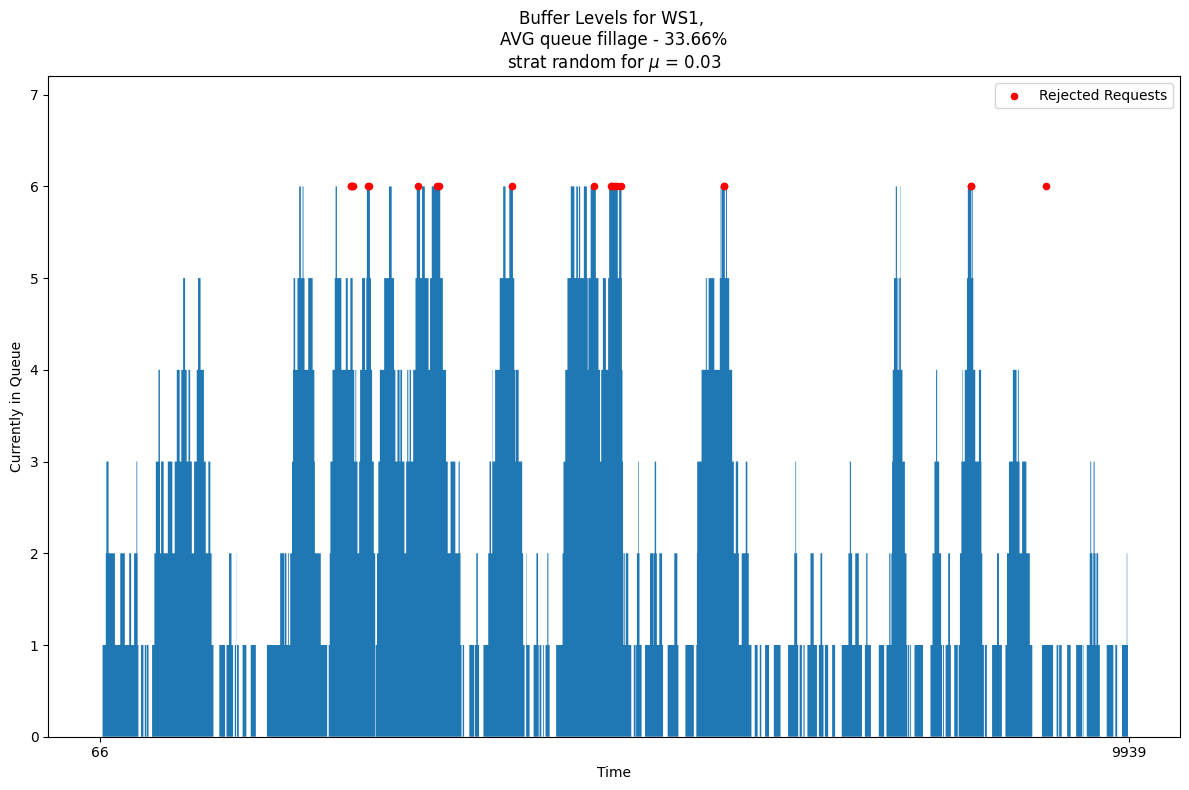

{'WS1': np.float64(33.66)}


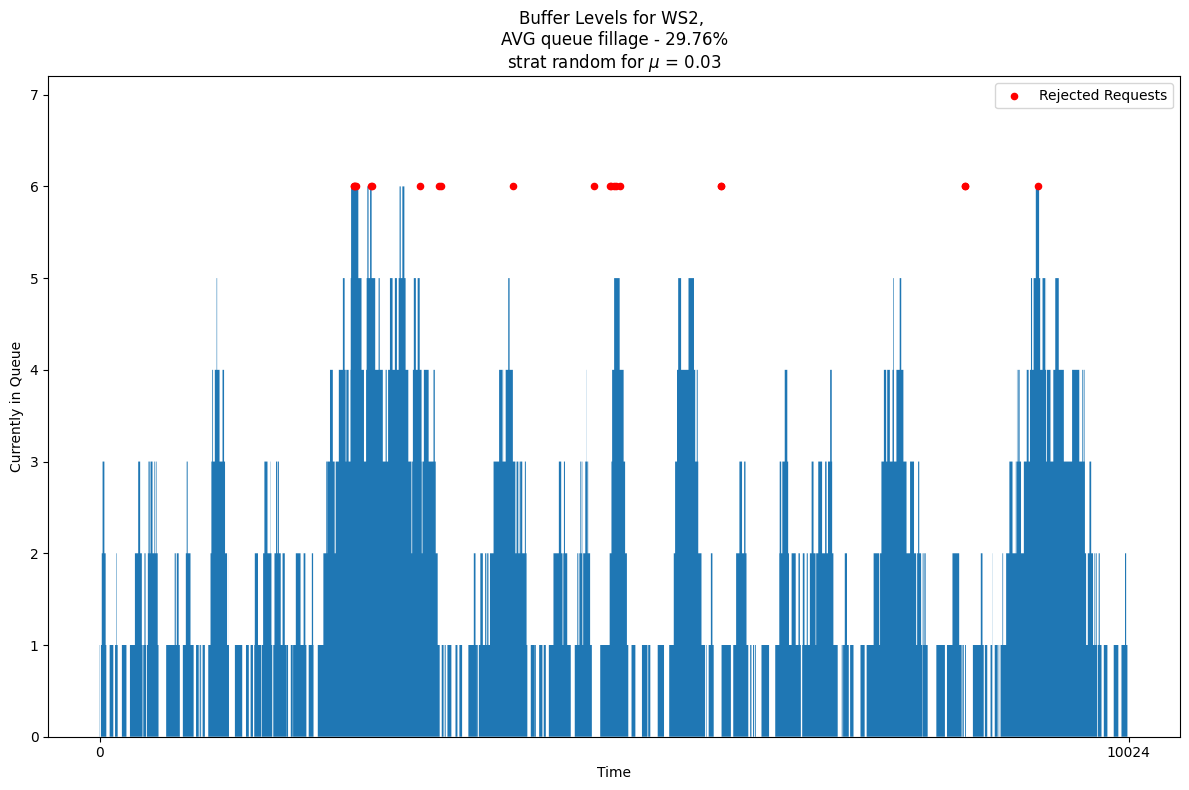

{'WS1': np.float64(33.66), 'WS2': np.float64(29.76)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 403
Odrzucone zgłoszenia: 42


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


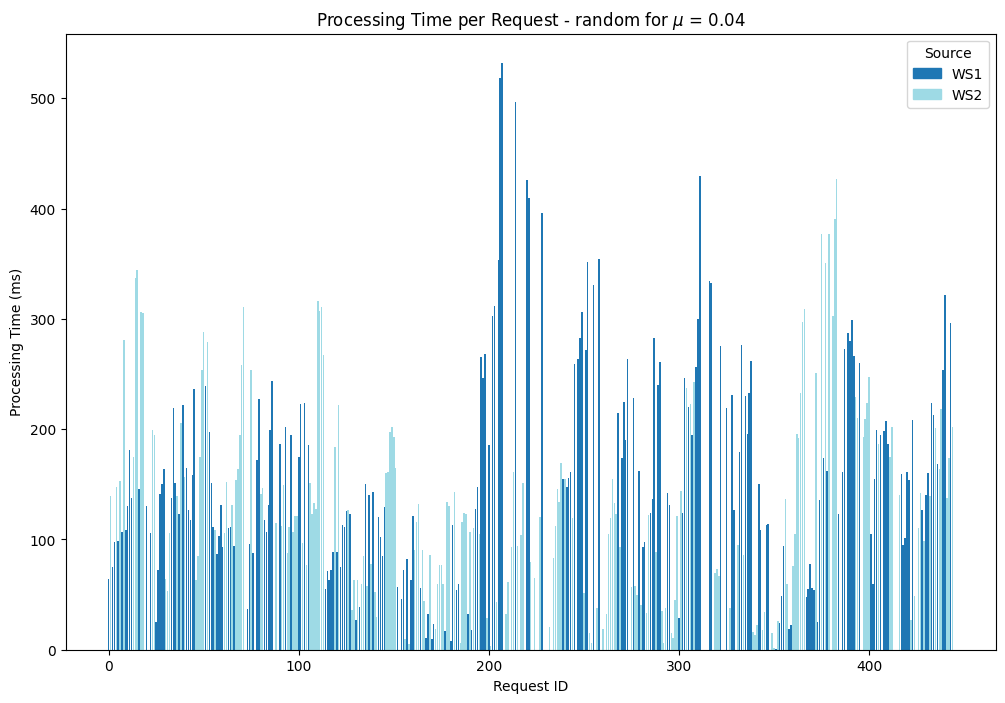

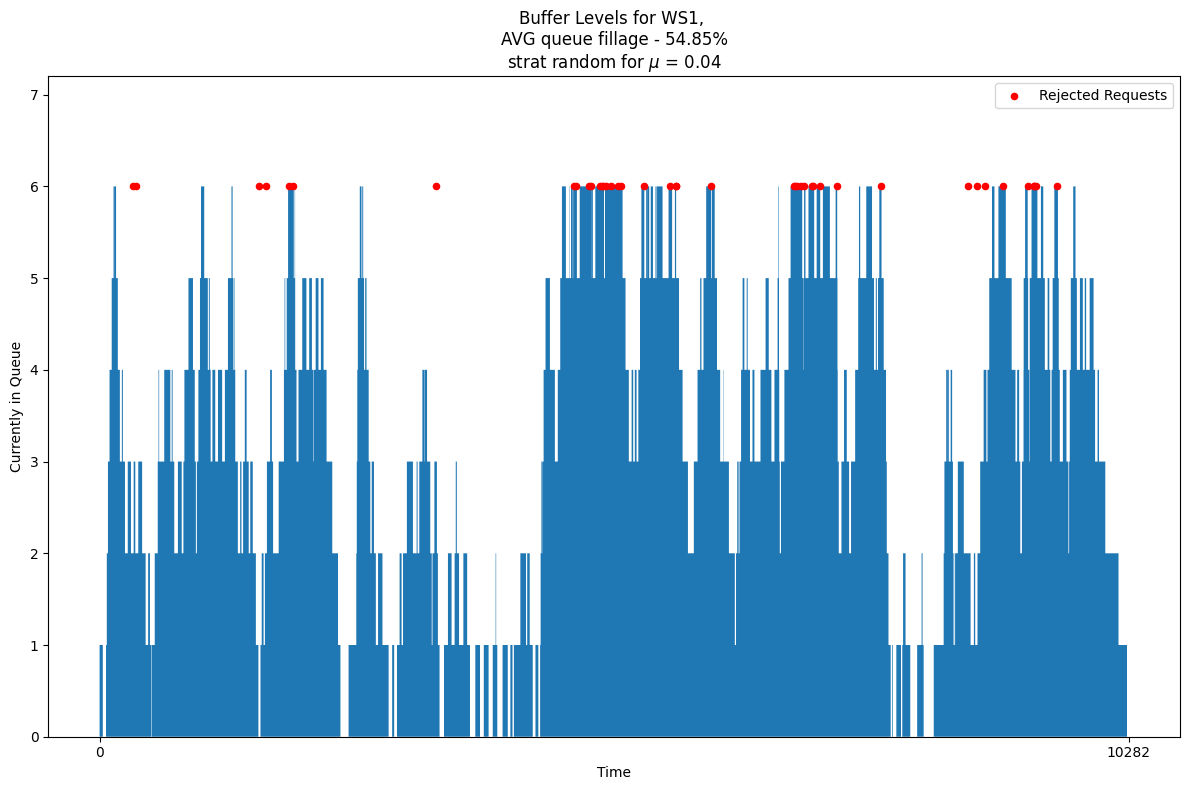

{'WS1': np.float64(54.85)}


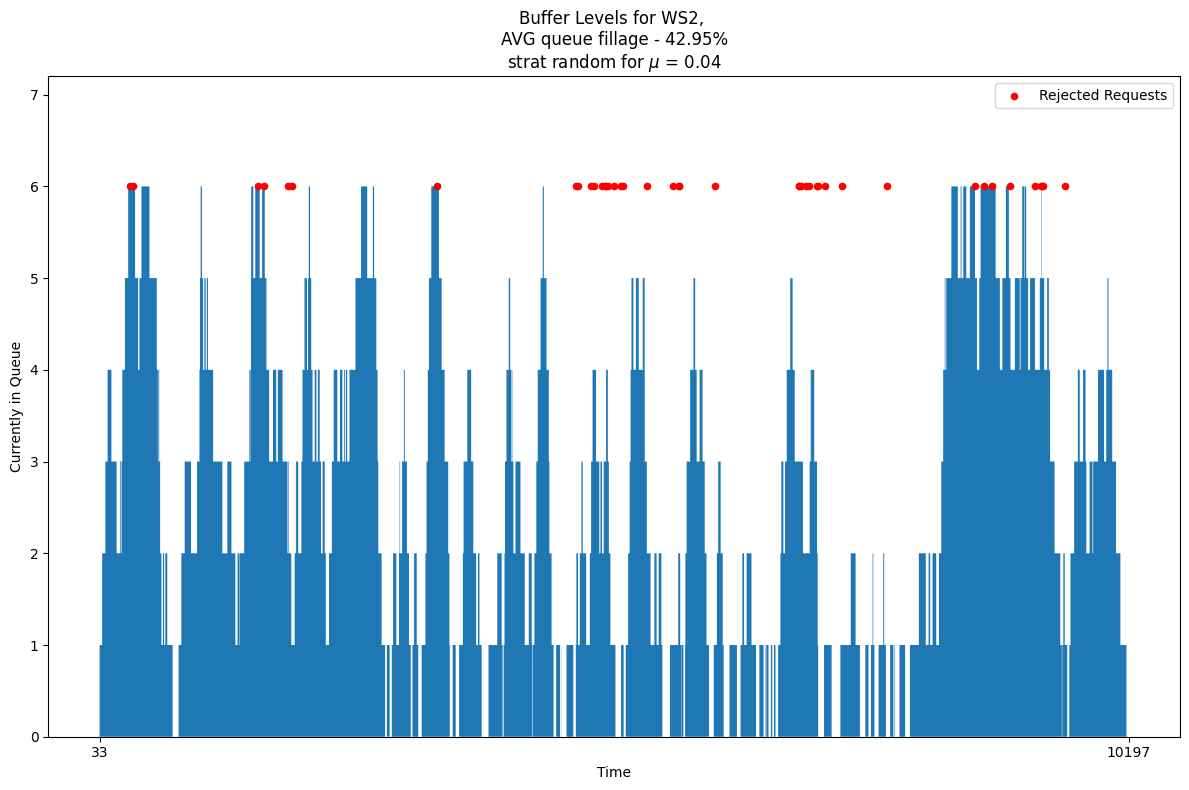

{'WS1': np.float64(54.85), 'WS2': np.float64(42.95)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 372
Odrzucone zgłoszenia: 121


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


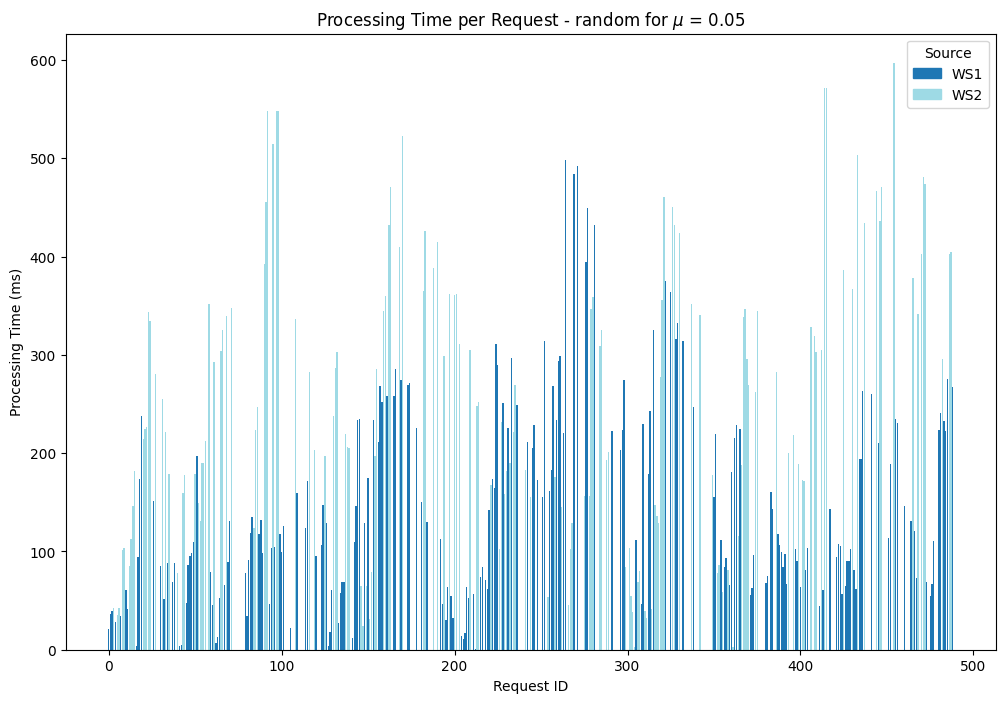

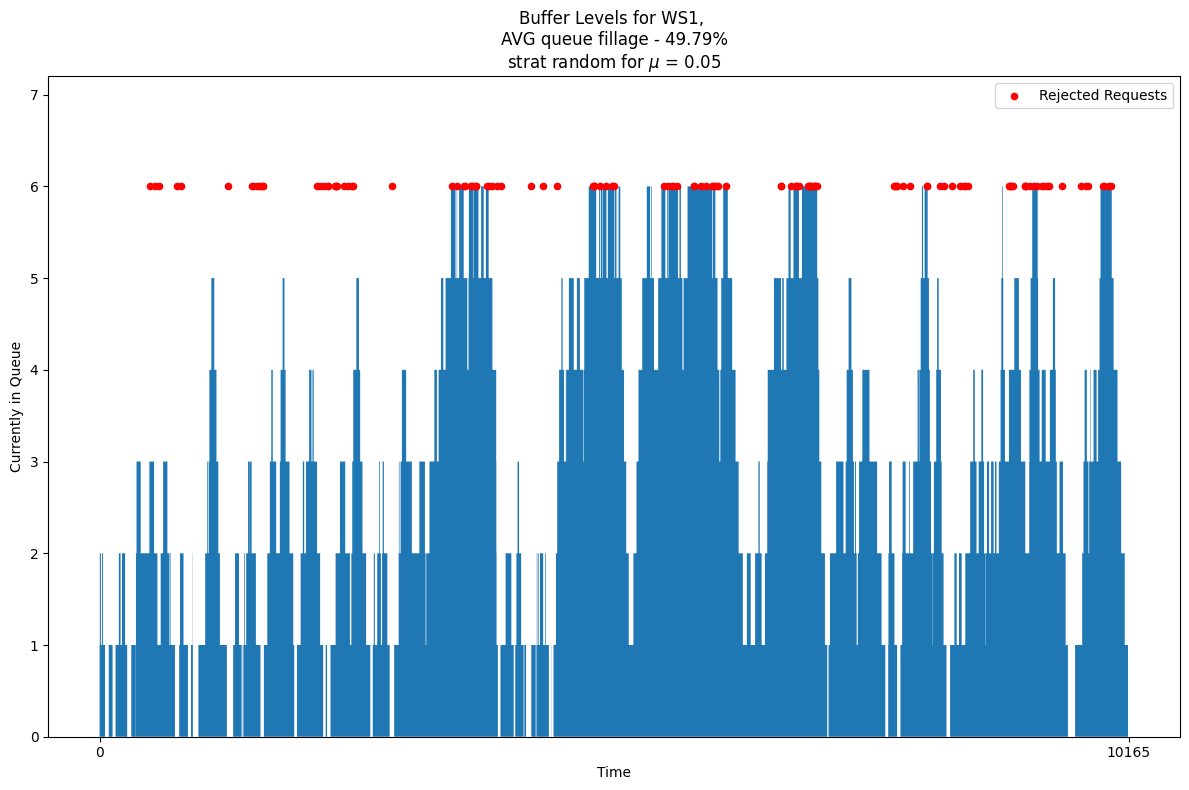

{'WS1': np.float64(49.79)}


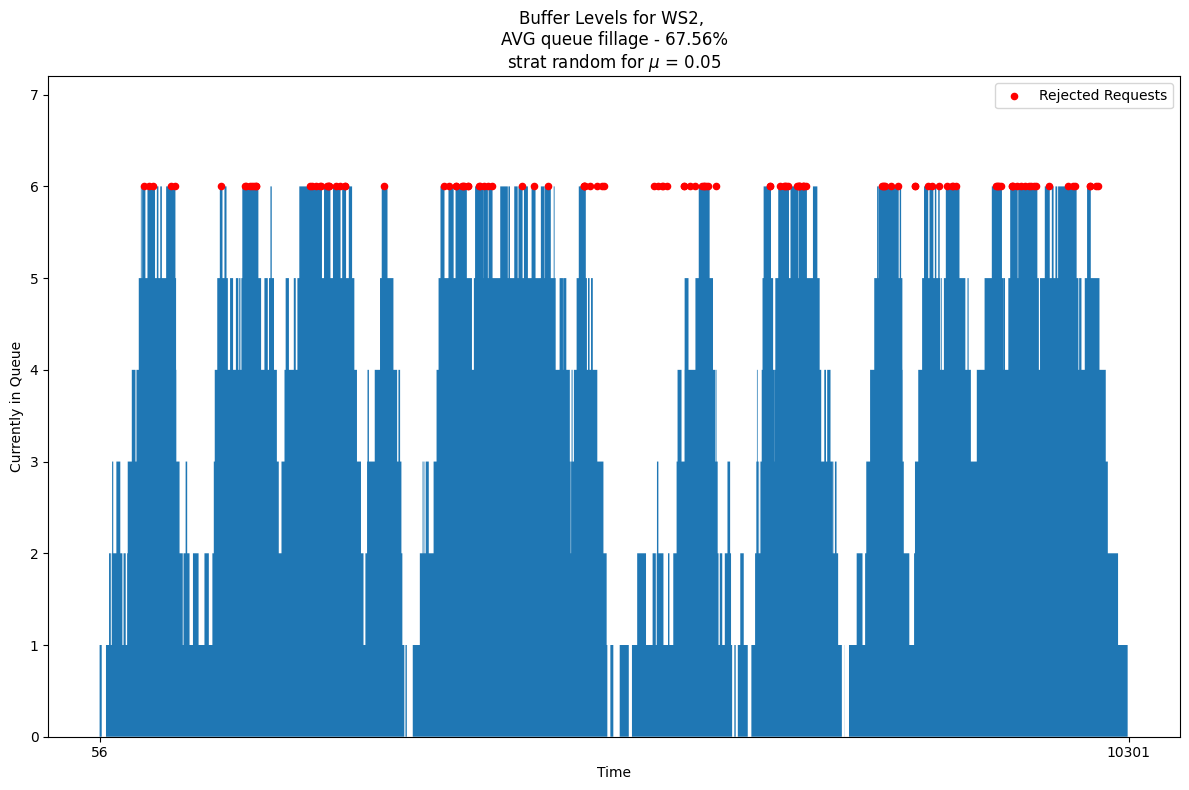

{'WS1': np.float64(49.79), 'WS2': np.float64(67.56)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 334
Odrzucone zgłoszenia: 175


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


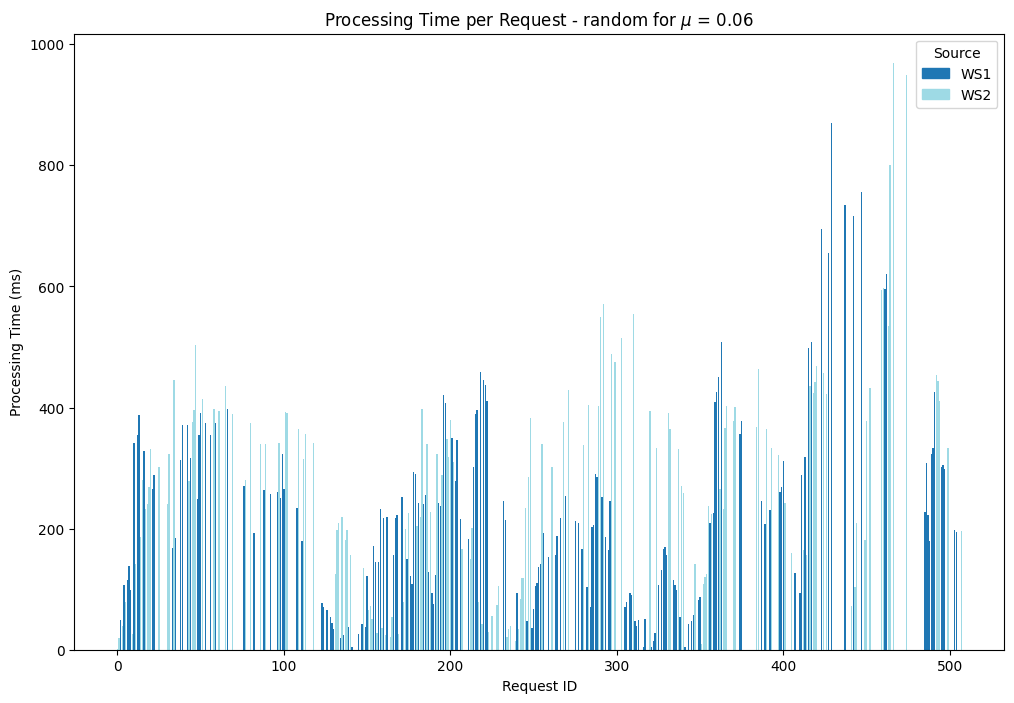

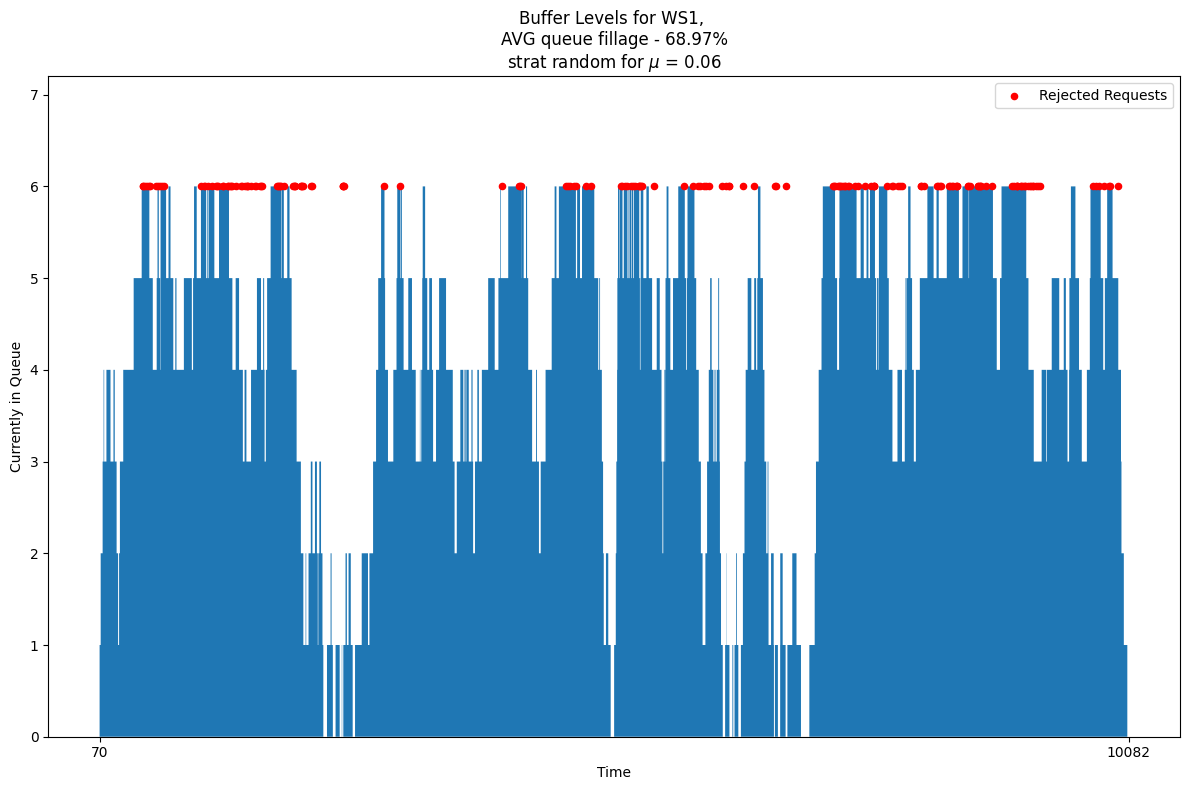

{'WS1': np.float64(68.97)}


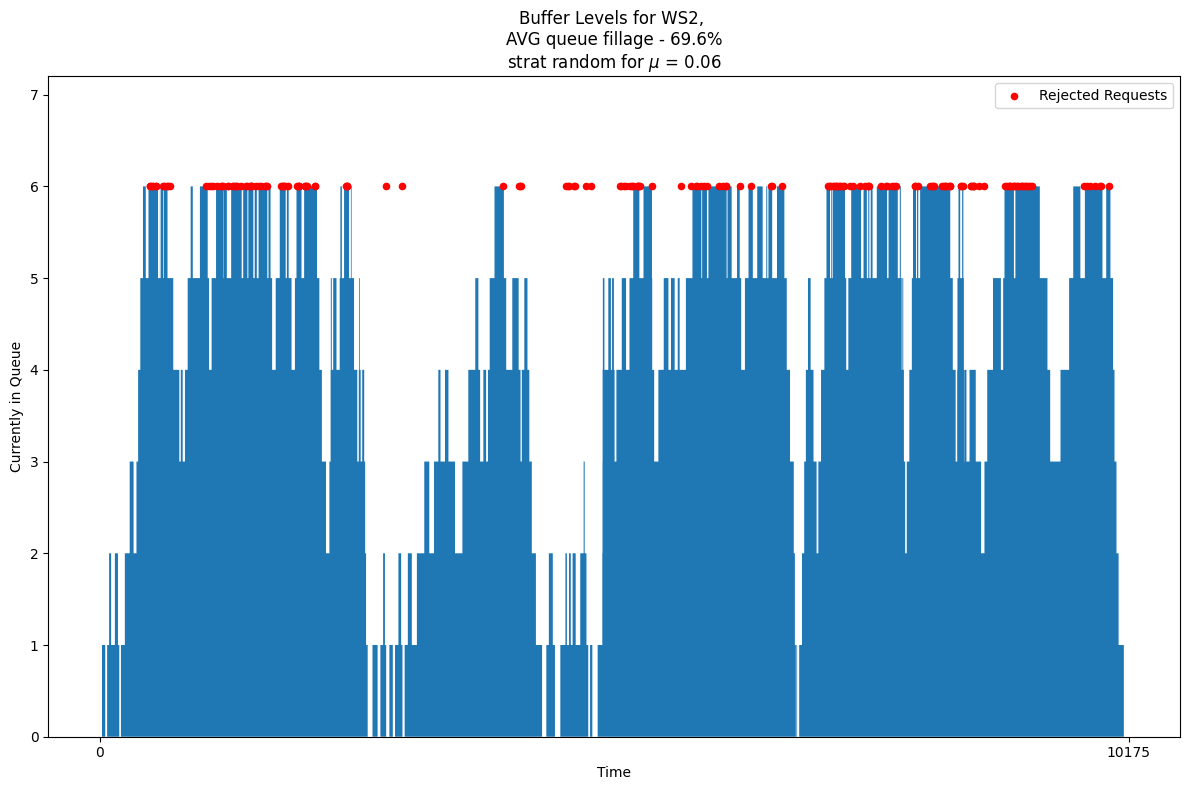

{'WS1': np.float64(68.97), 'WS2': np.float64(69.6)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 280
Odrzucone zgłoszenia: 237


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


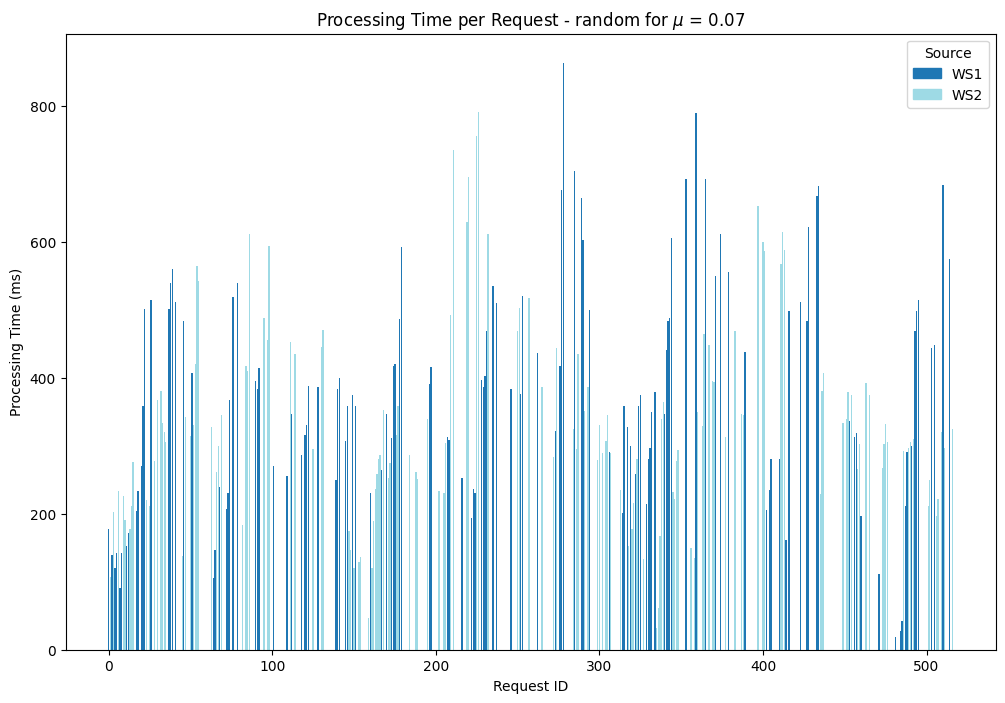

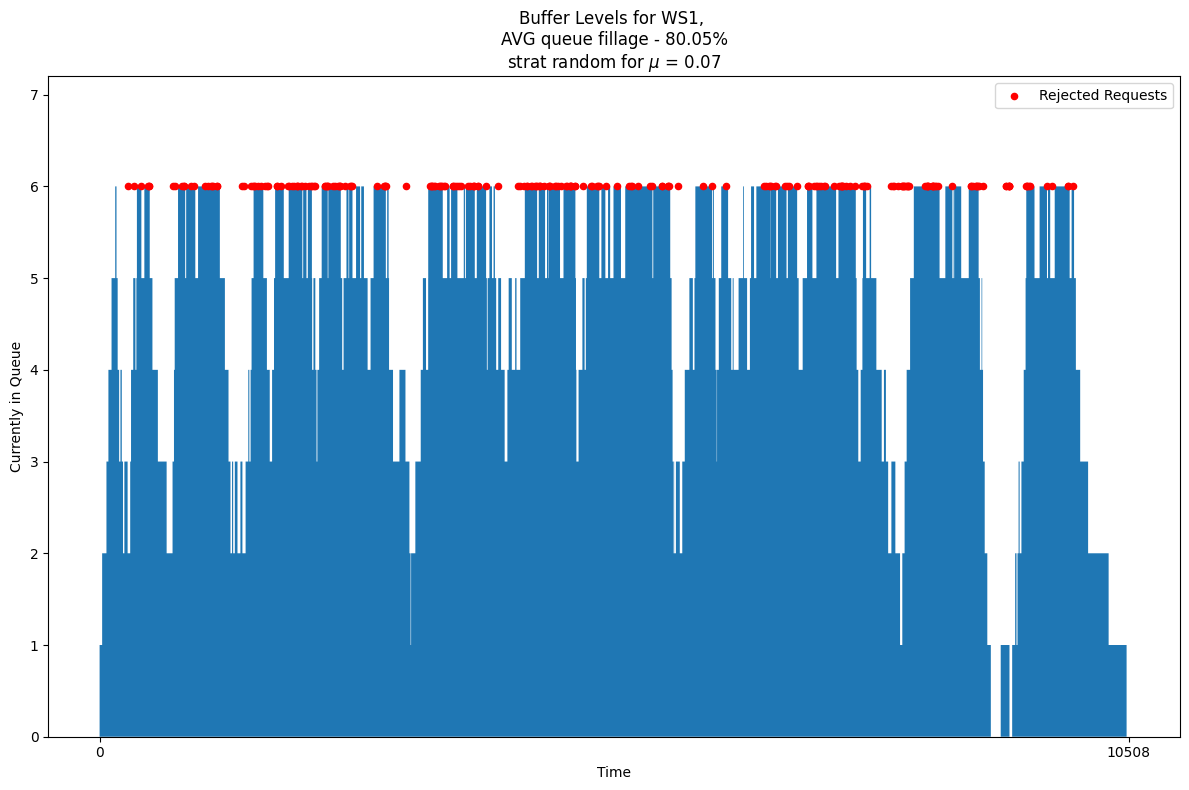

{'WS1': np.float64(80.05)}


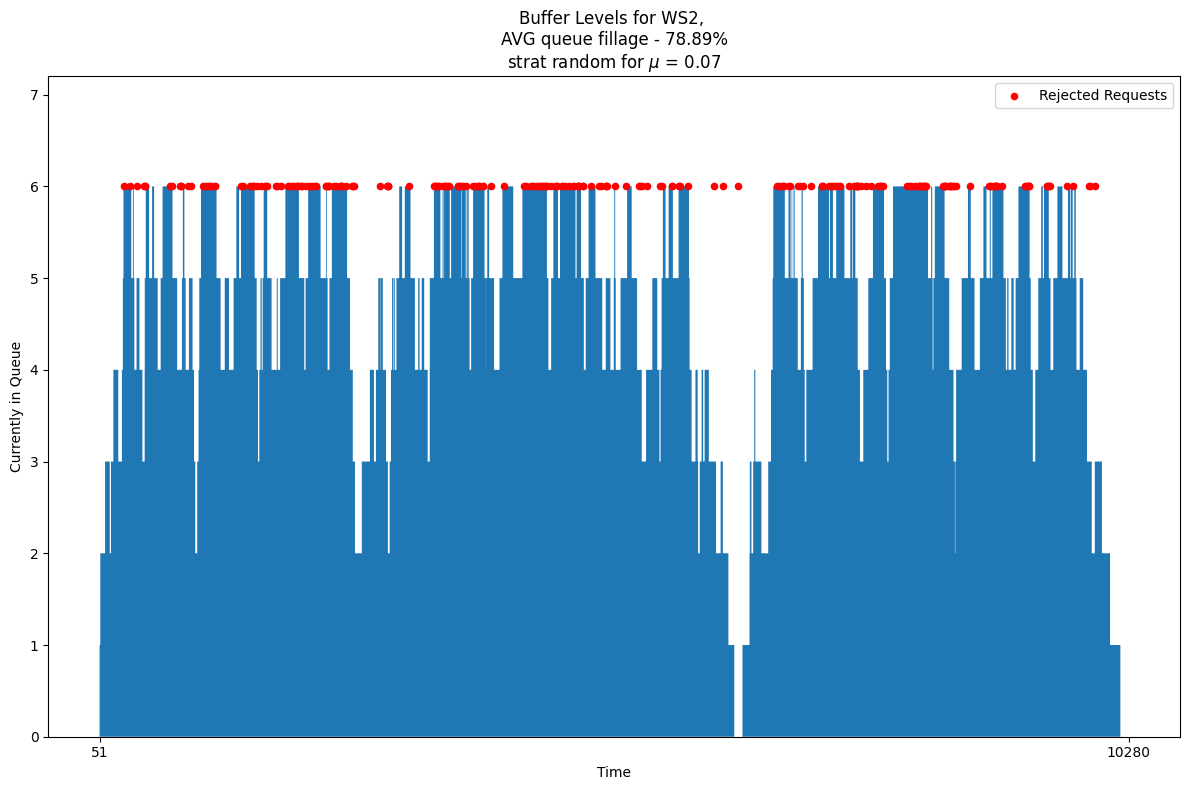

{'WS1': np.float64(80.05), 'WS2': np.float64(78.89)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 264
Odrzucone zgłoszenia: 195


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


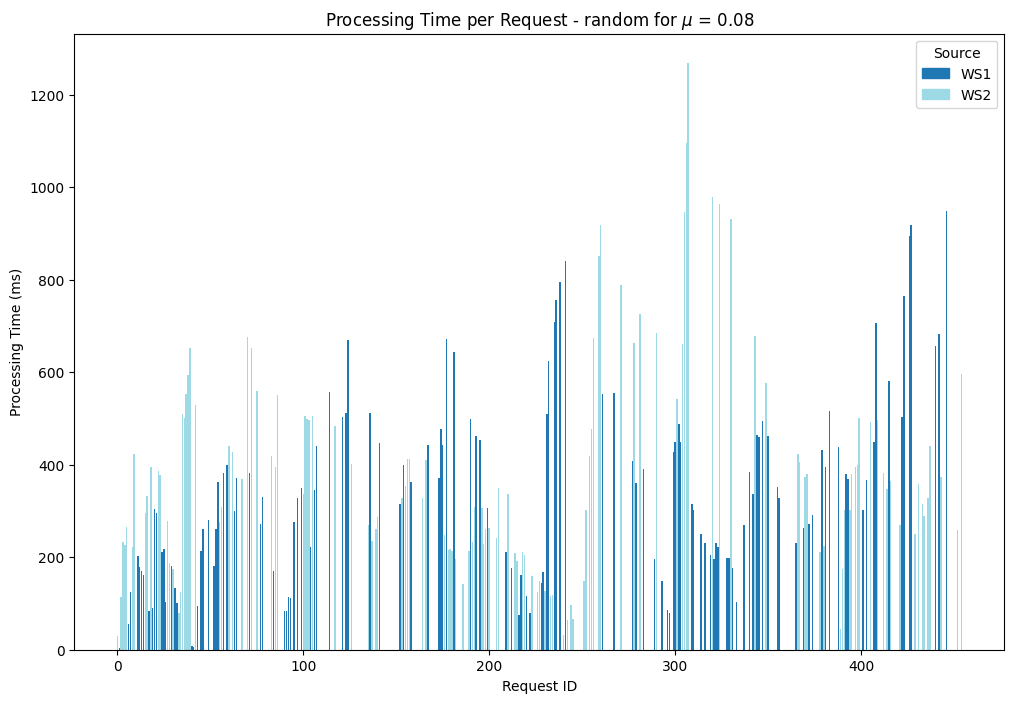

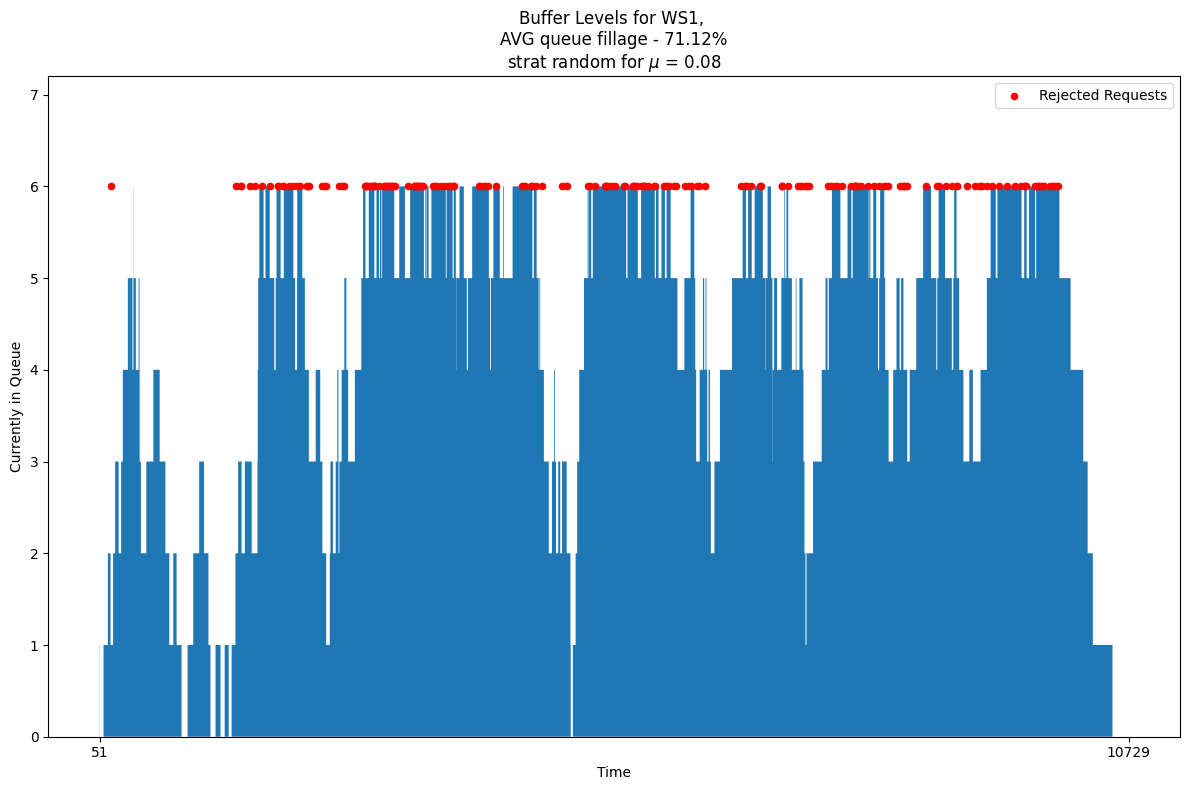

{'WS1': np.float64(71.12)}


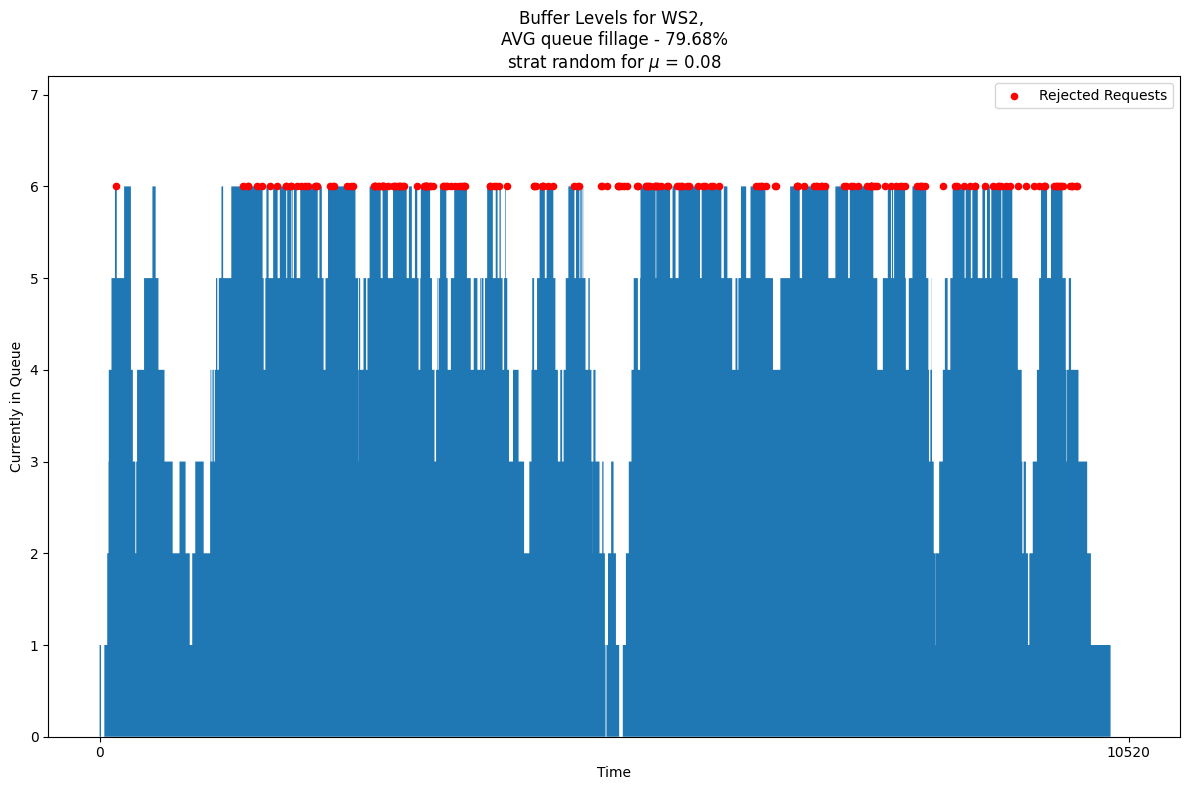

{'WS1': np.float64(71.12), 'WS2': np.float64(79.68)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 237
Odrzucone zgłoszenia: 249


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


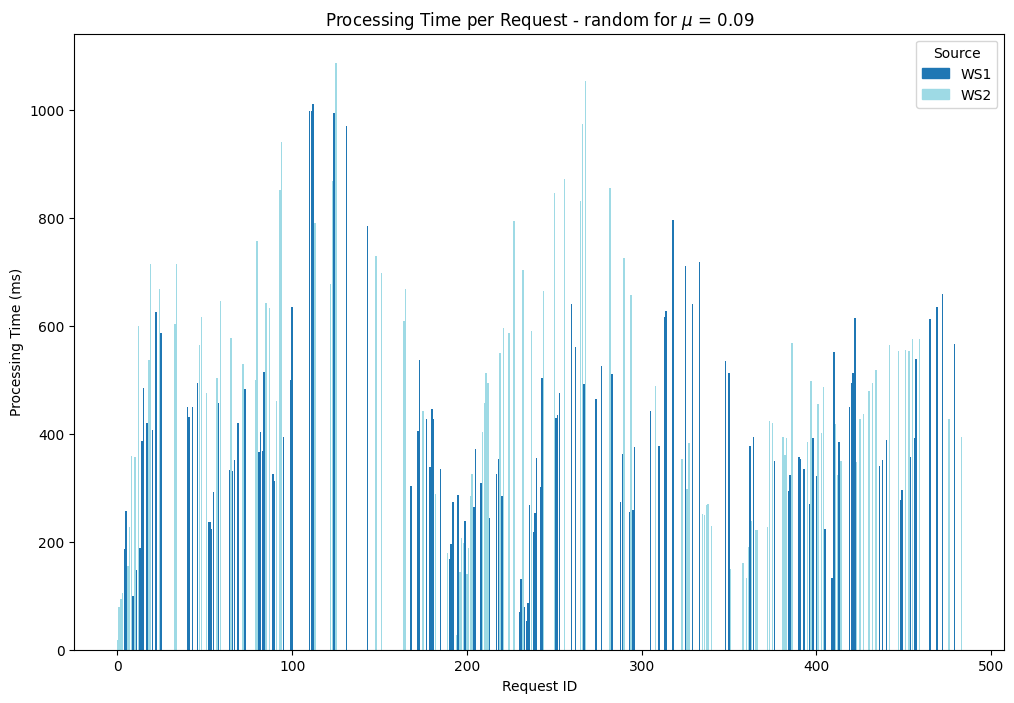

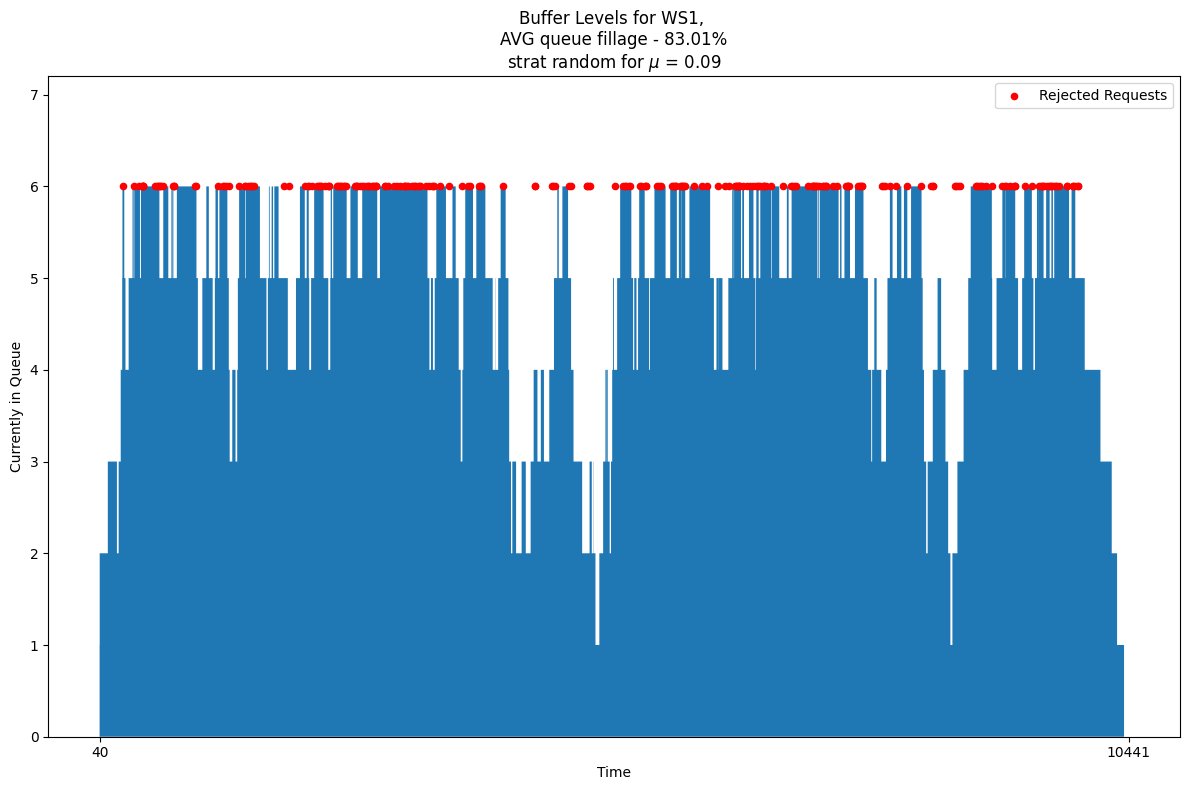

{'WS1': np.float64(83.01)}


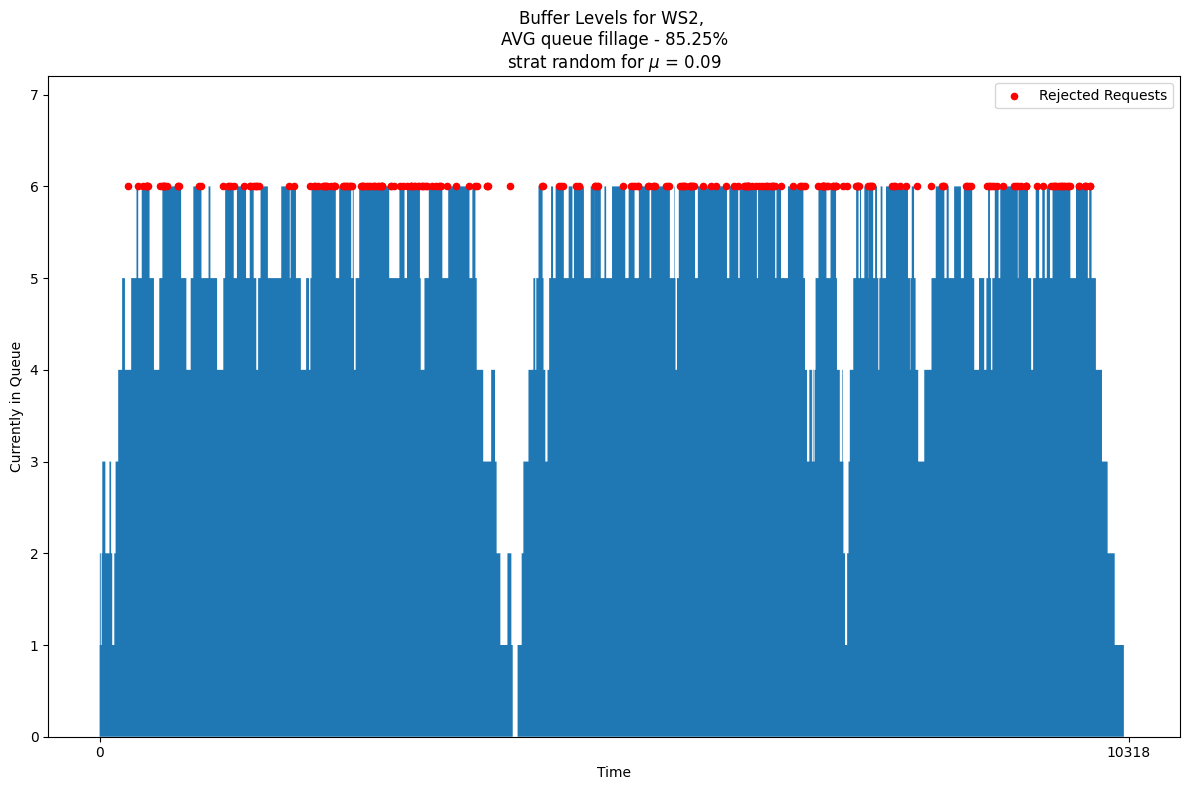

{'WS1': np.float64(83.01), 'WS2': np.float64(85.25)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 181
Odrzucone zgłoszenia: 301


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


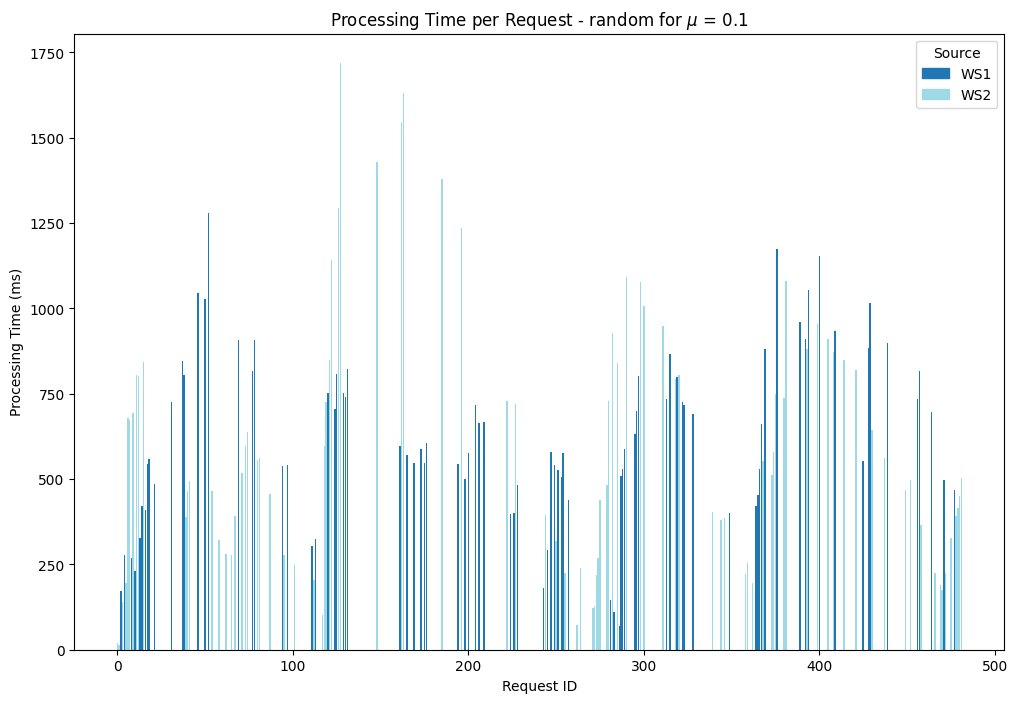

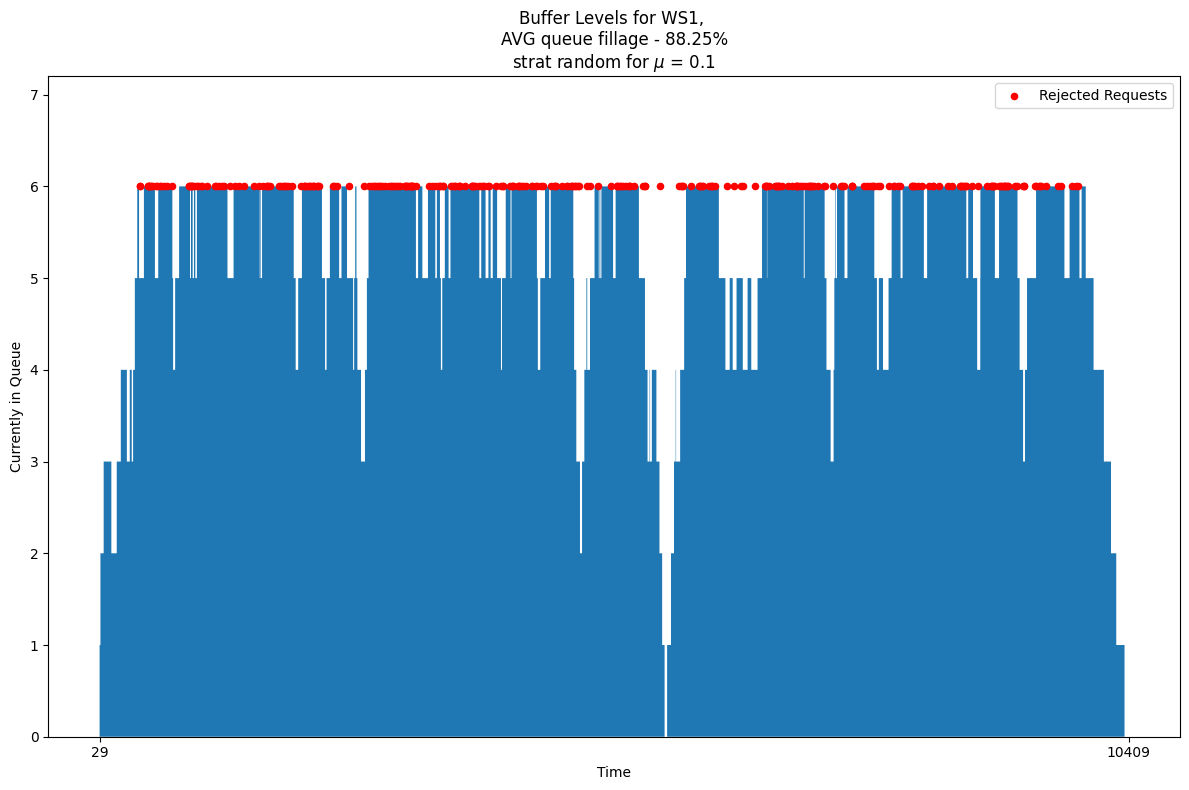

{'WS1': np.float64(88.25)}


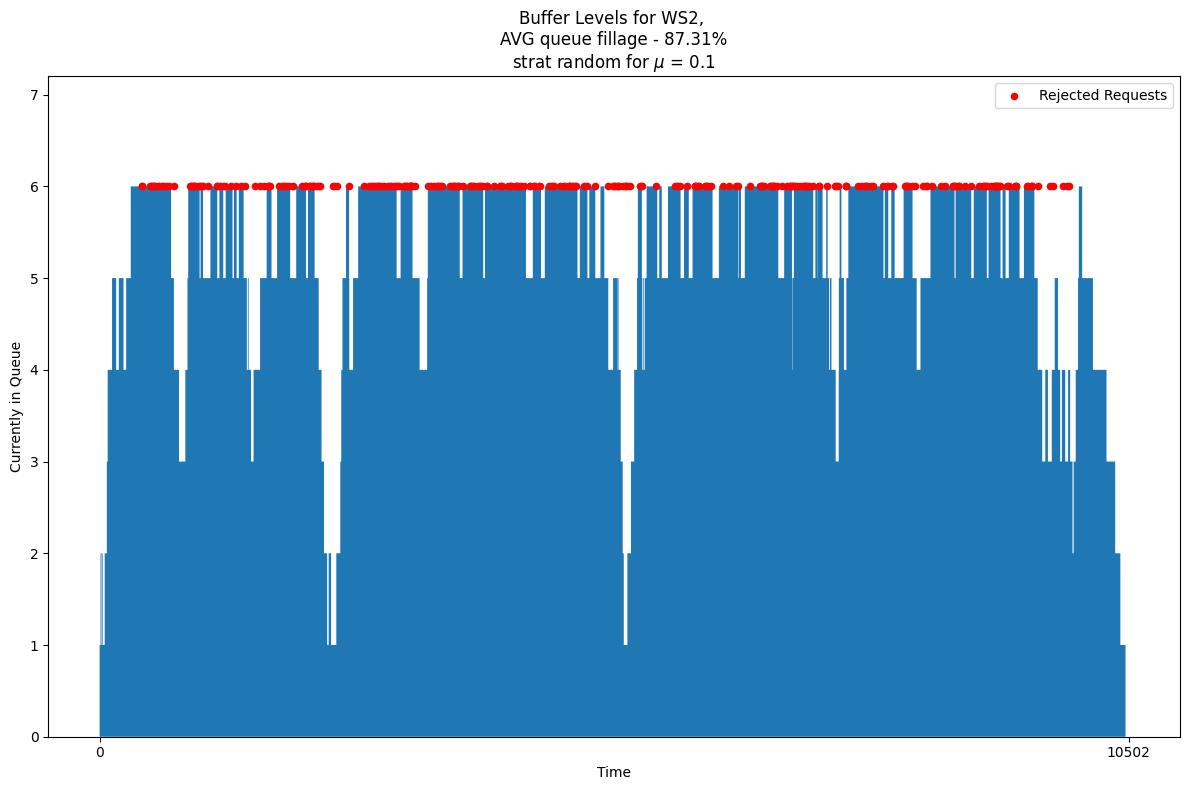

{'WS1': np.float64(88.25), 'WS2': np.float64(87.31)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 175
Odrzucone zgłoszenia: 307


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


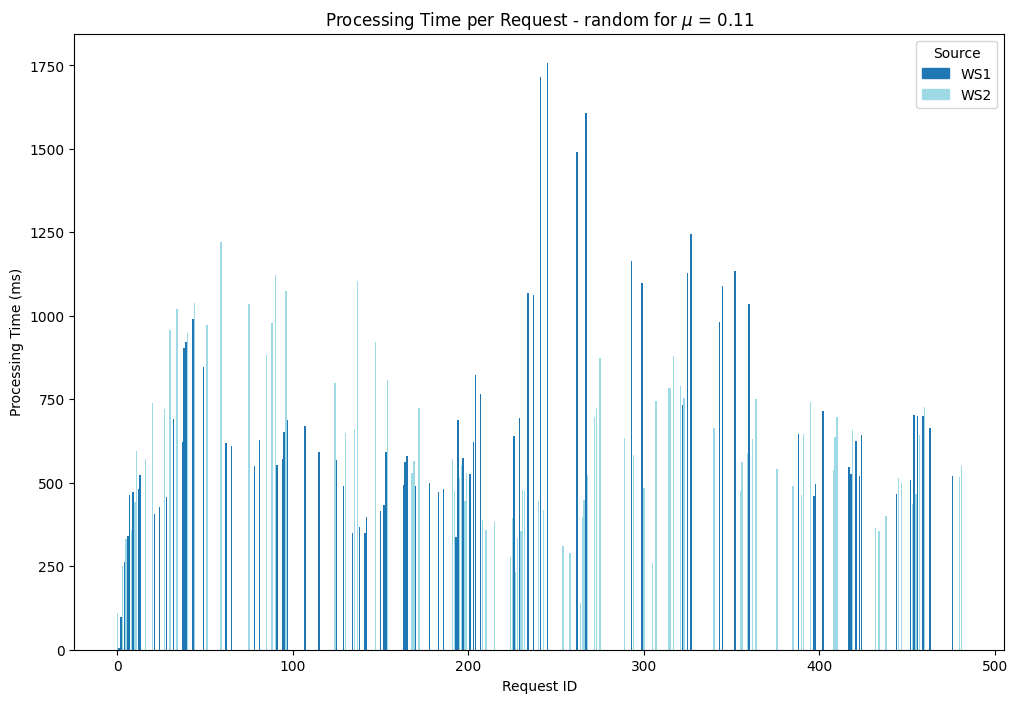

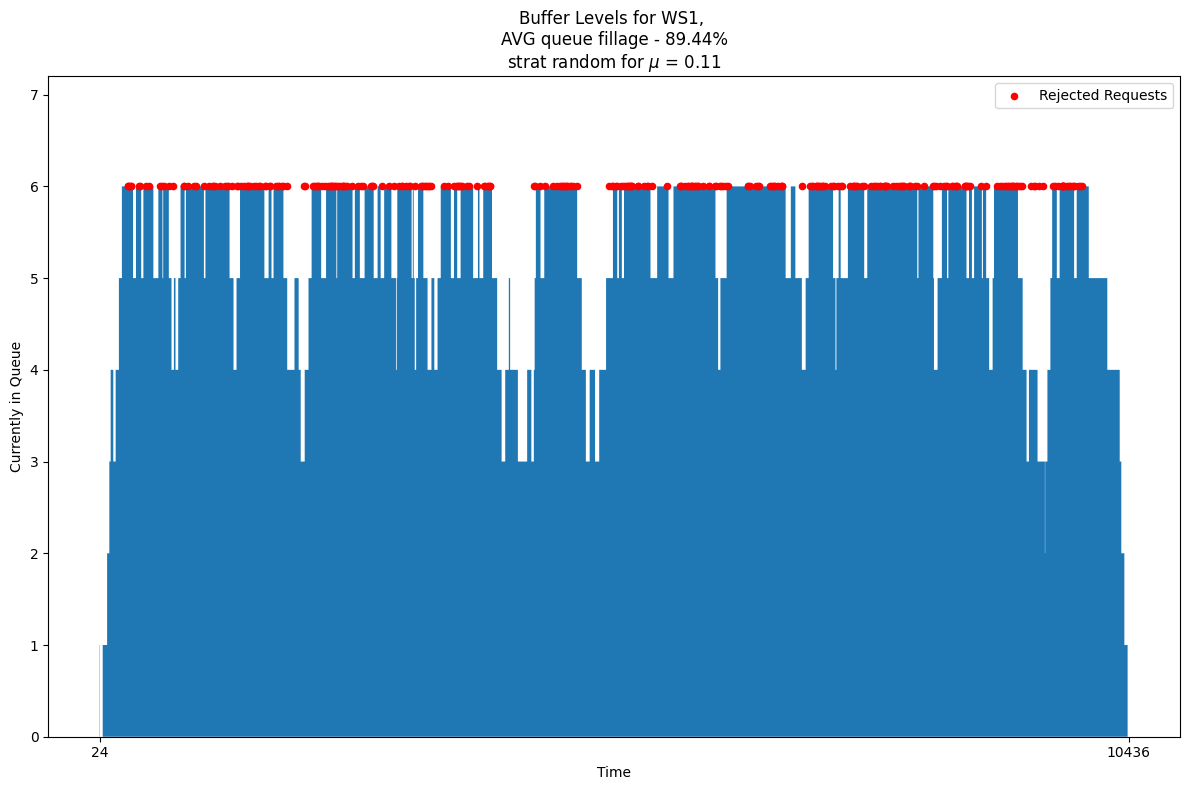

{'WS1': np.float64(89.44)}


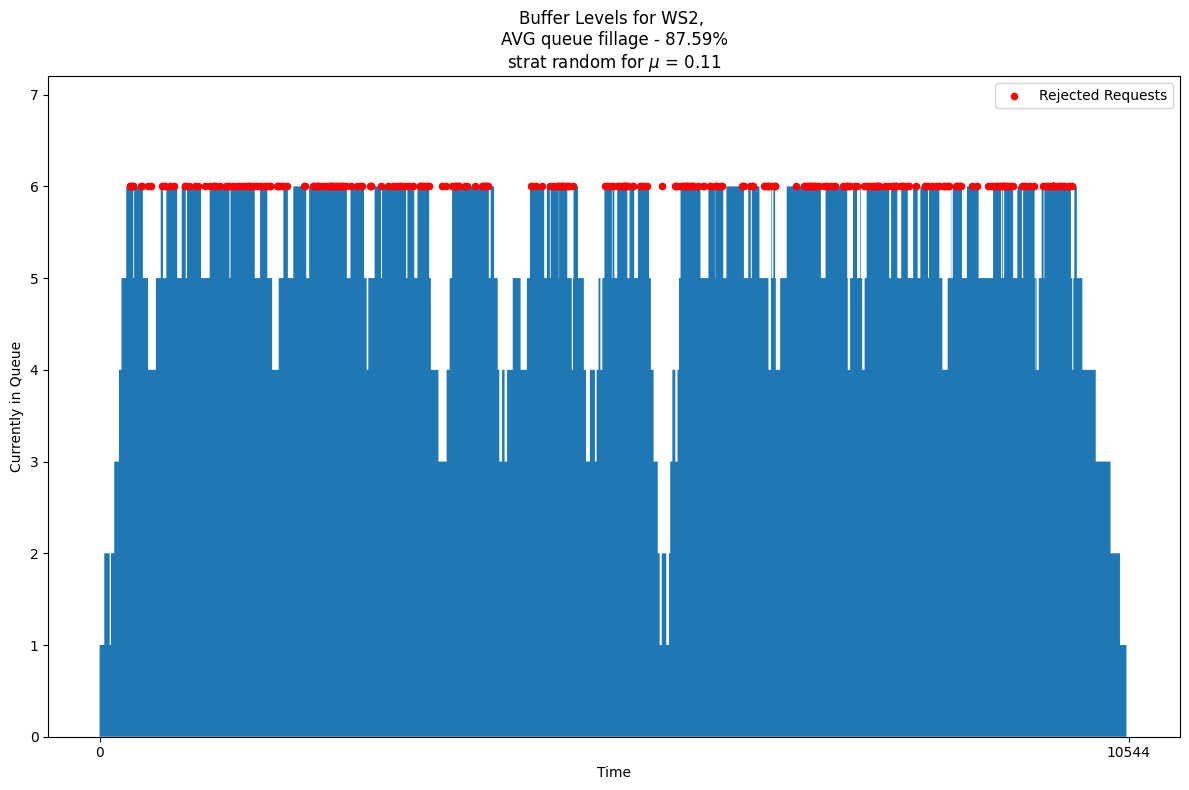

{'WS1': np.float64(89.44), 'WS2': np.float64(87.59)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 170
Odrzucone zgłoszenia: 290


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


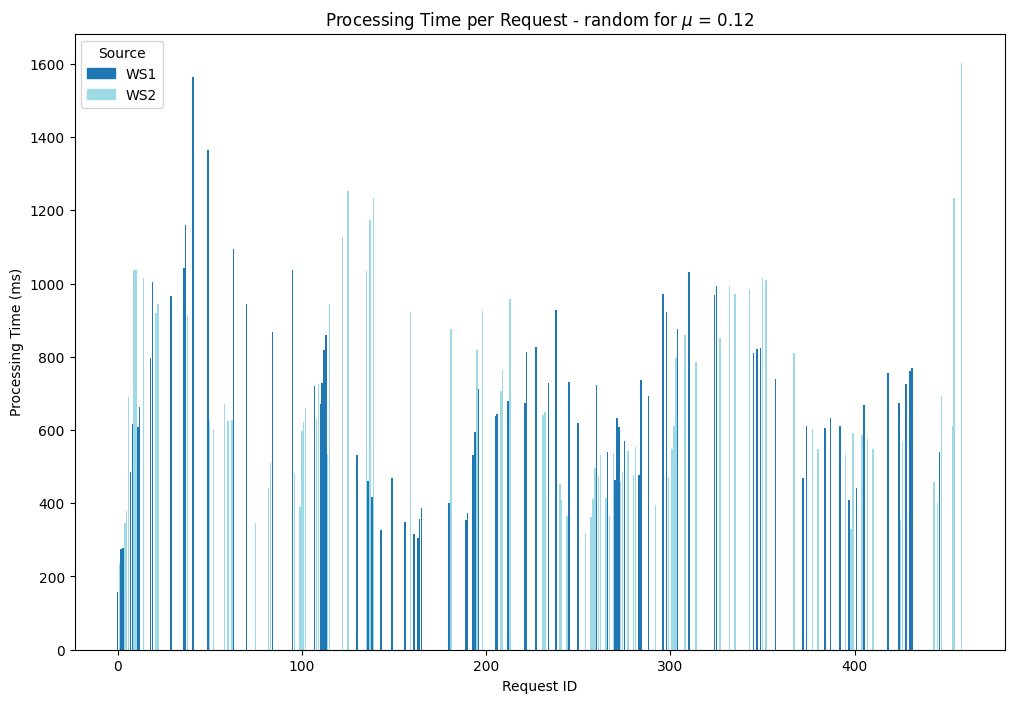

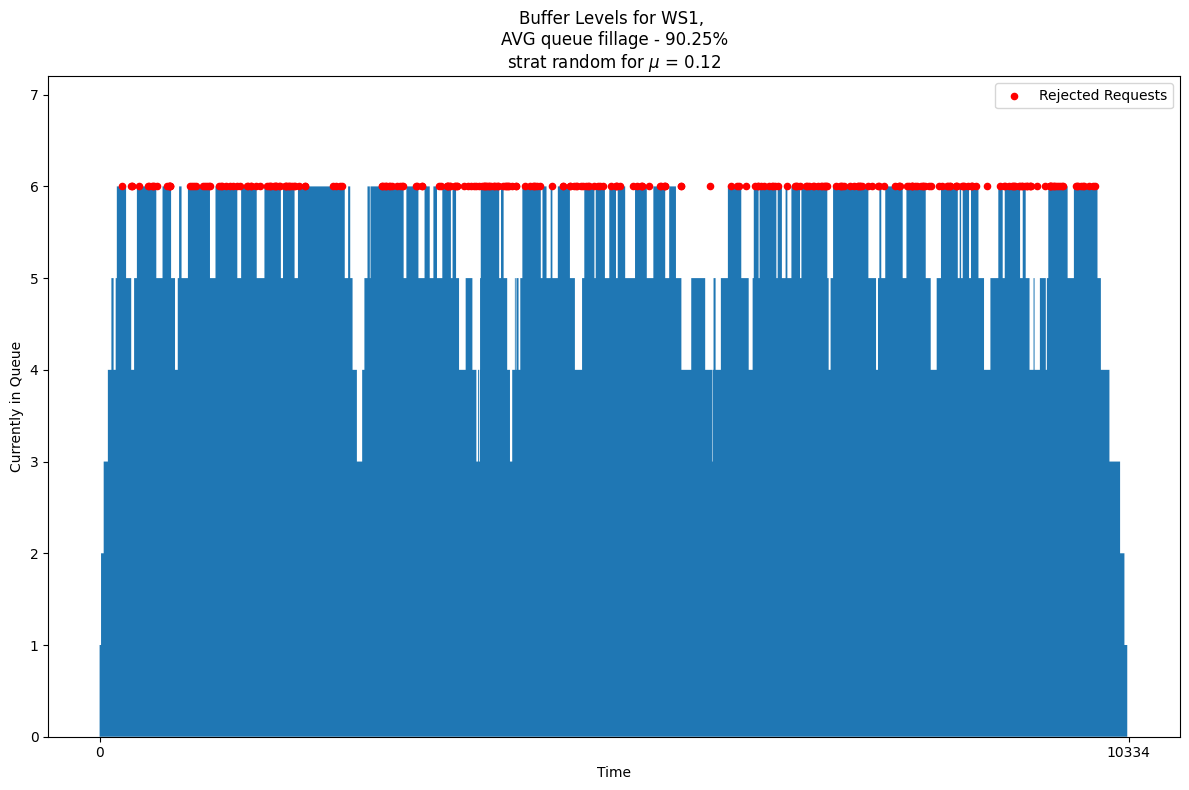

{'WS1': np.float64(90.25)}


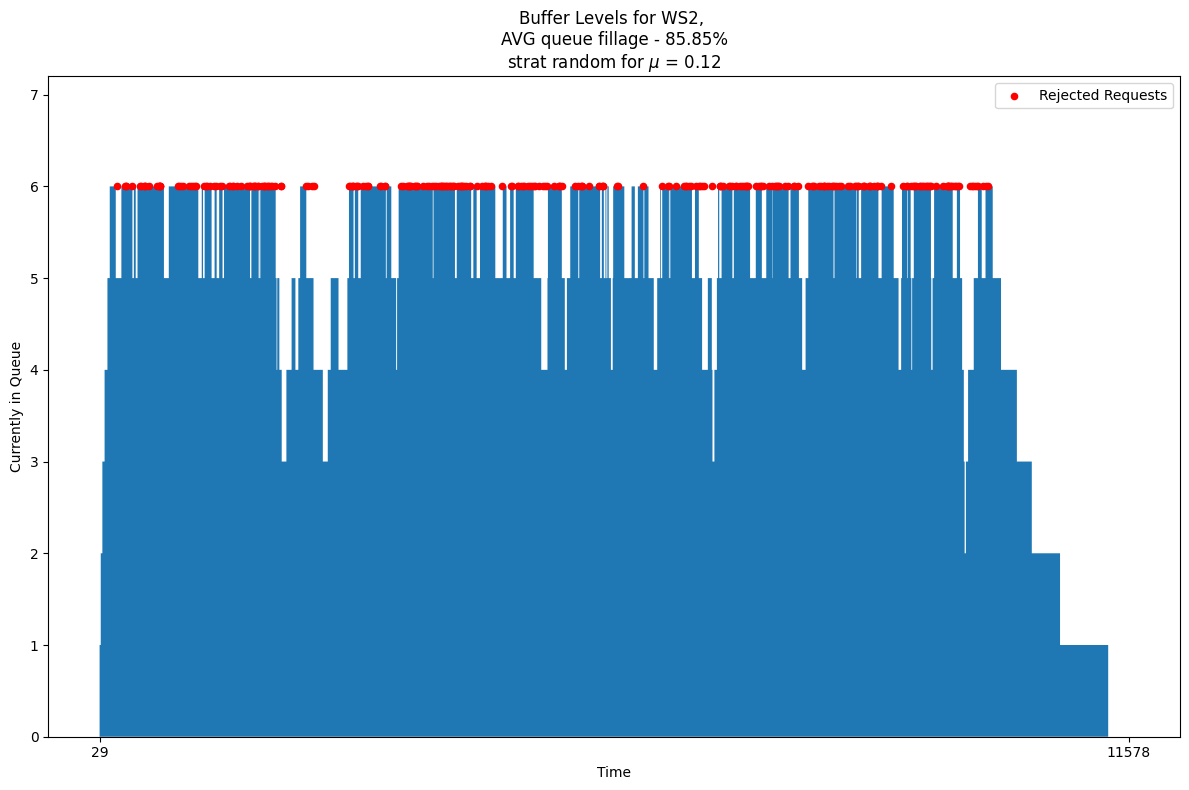

{'WS1': np.float64(90.25), 'WS2': np.float64(85.85)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 161
Odrzucone zgłoszenia: 279


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


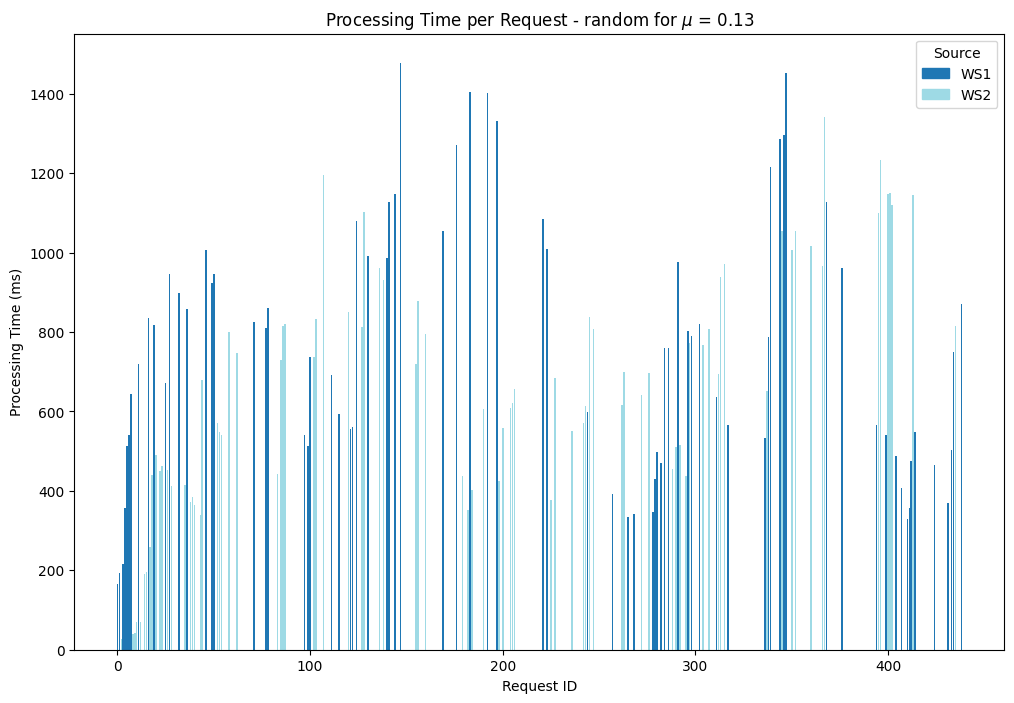

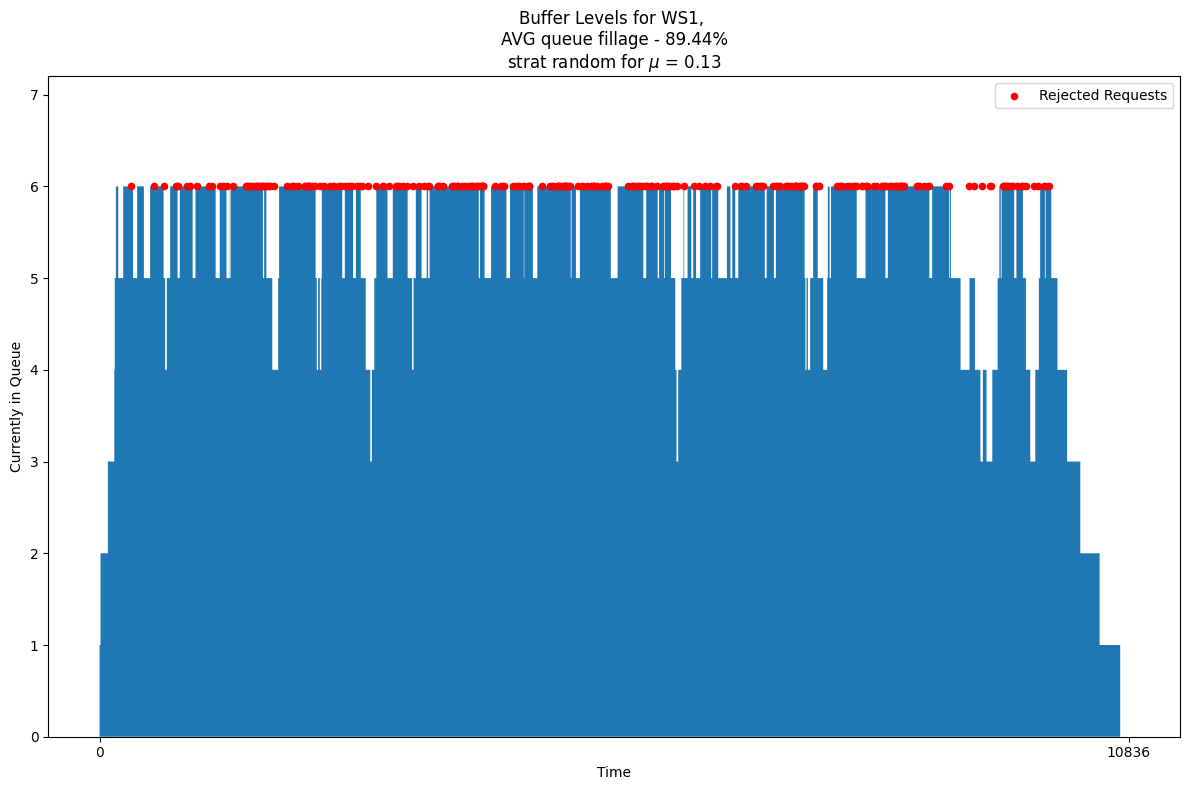

{'WS1': np.float64(89.44)}


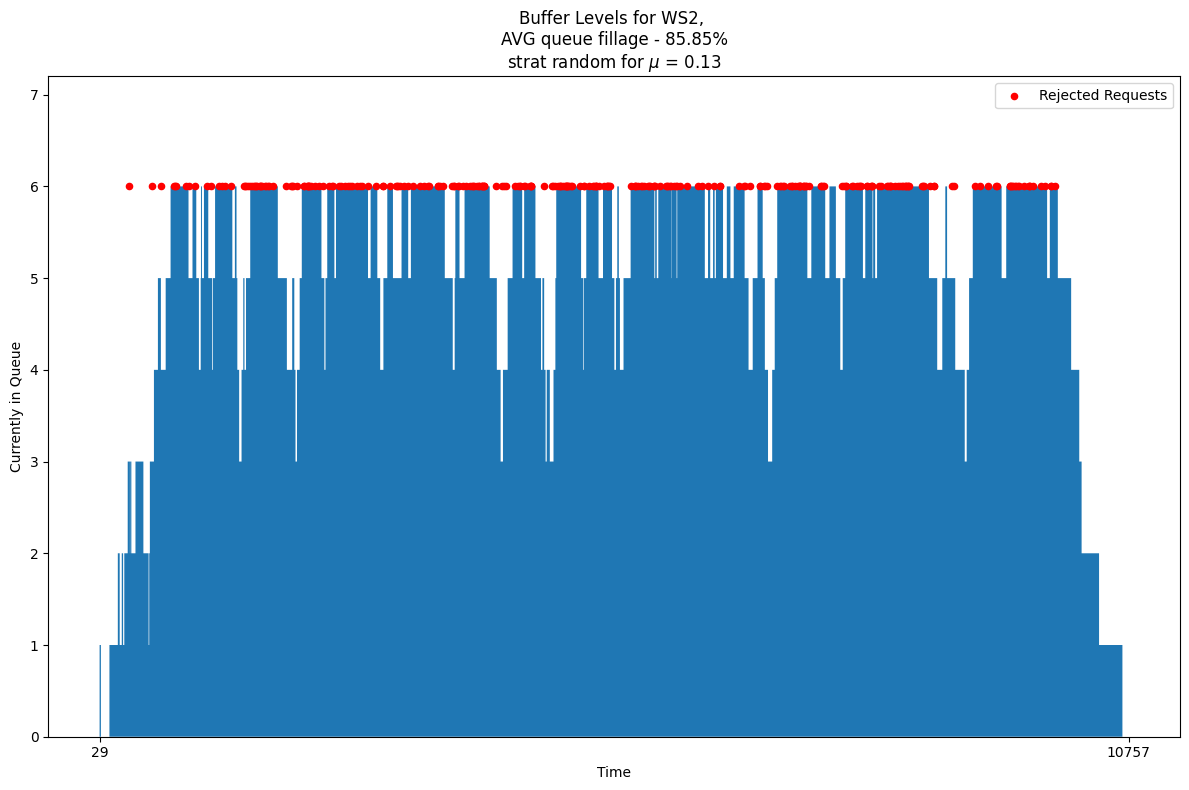

{'WS1': np.float64(89.44), 'WS2': np.float64(85.85)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 149
Odrzucone zgłoszenia: 328


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


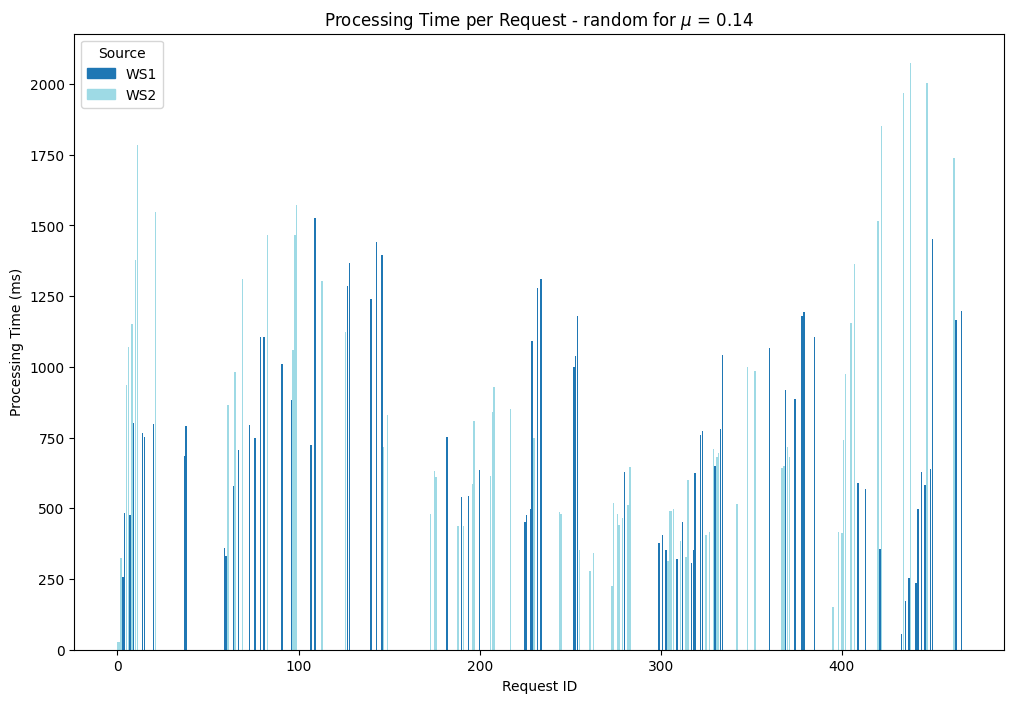

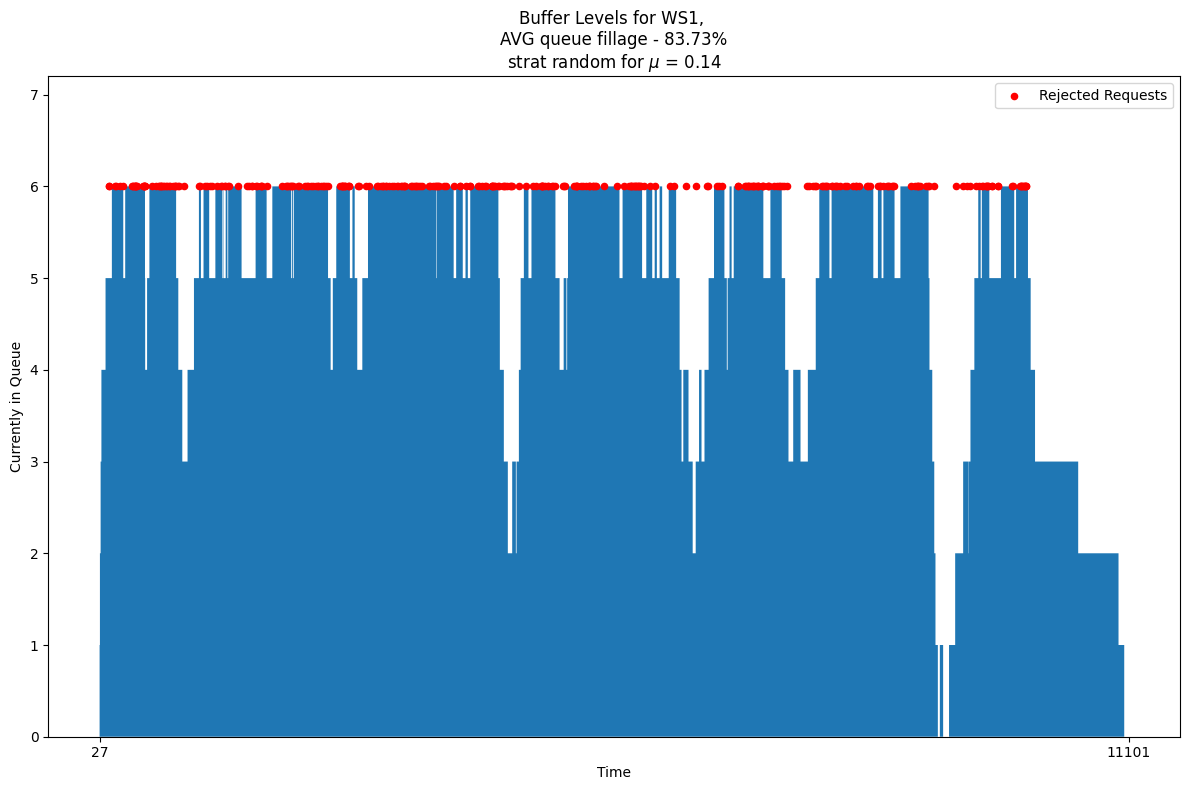

{'WS1': np.float64(83.73)}


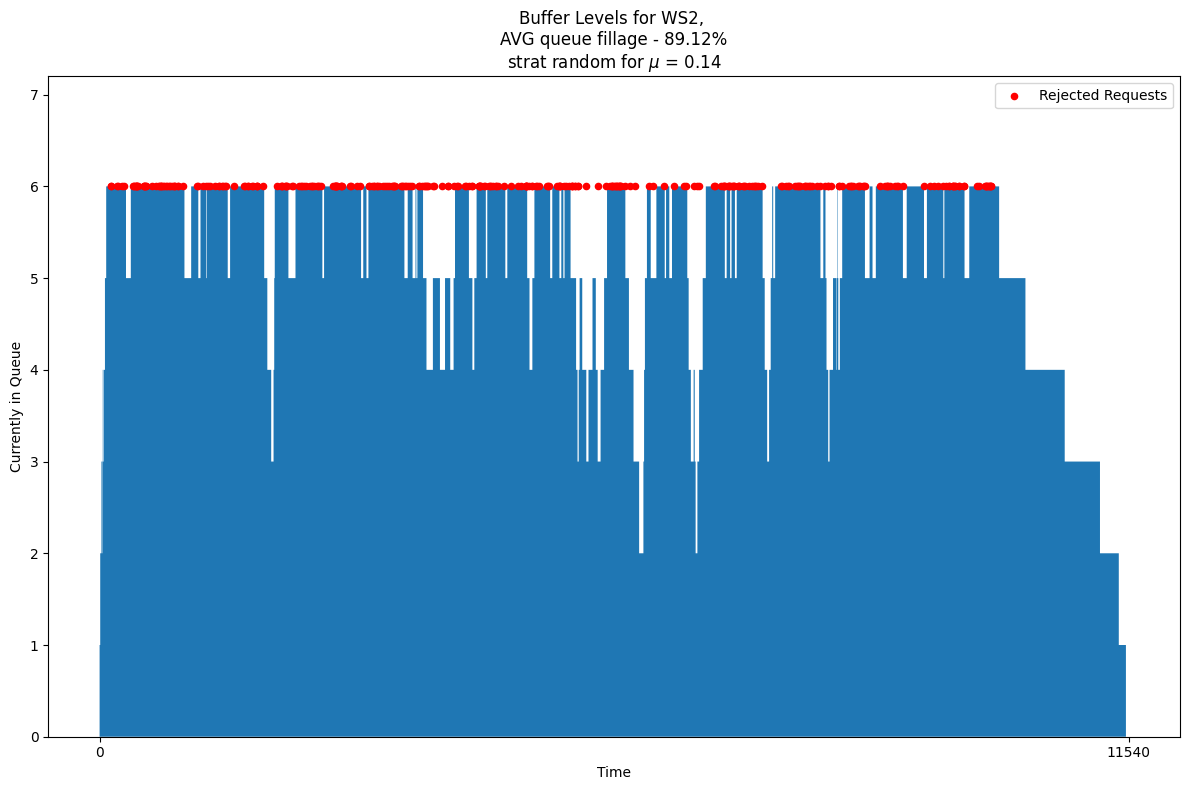

{'WS1': np.float64(83.73), 'WS2': np.float64(89.12)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 147
Odrzucone zgłoszenia: 343


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


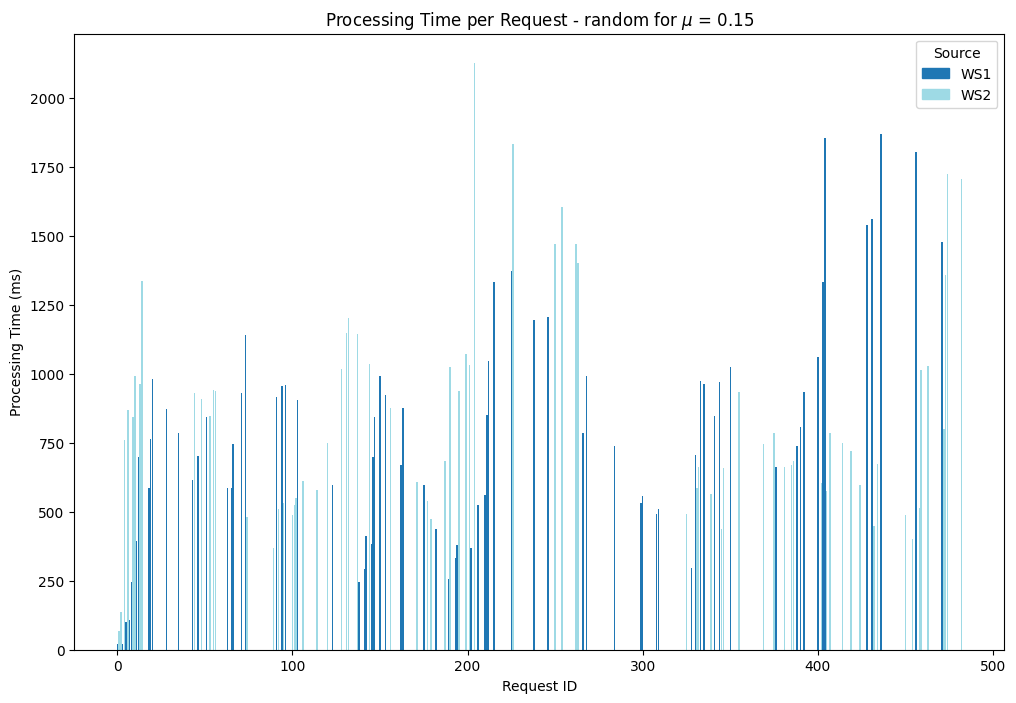

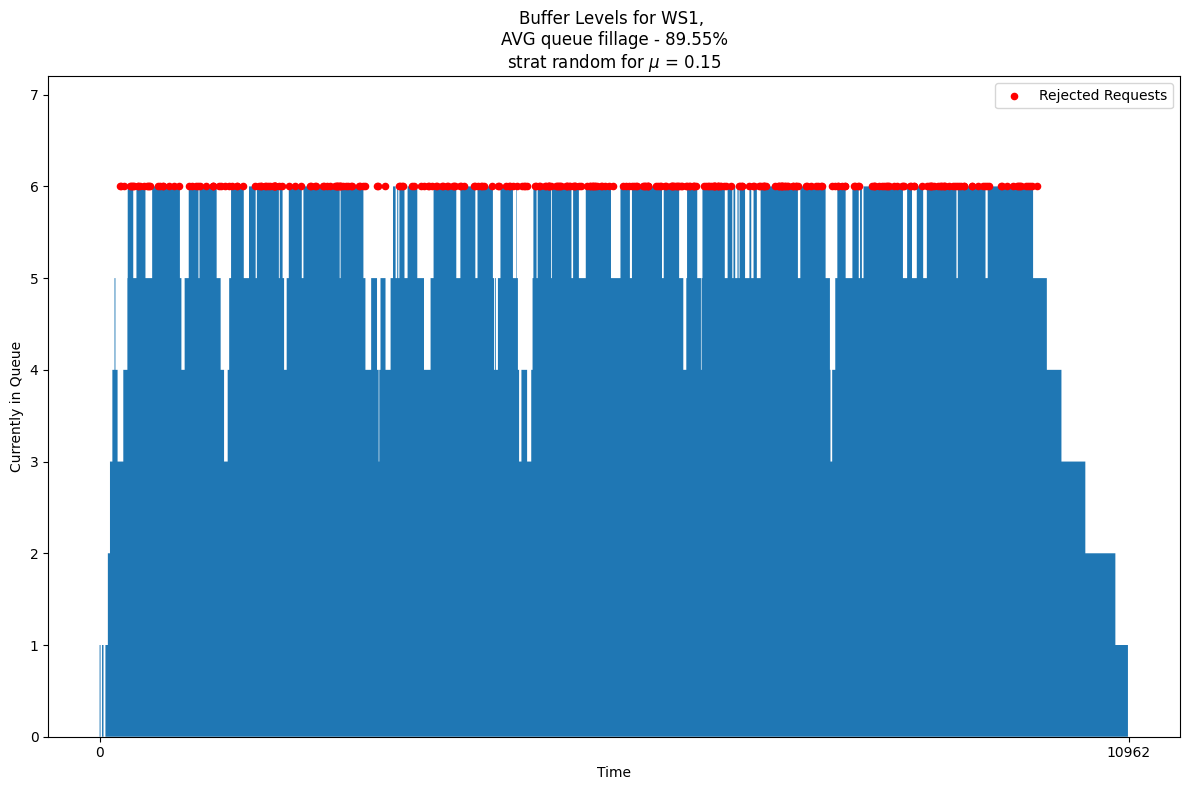

{'WS1': np.float64(89.55)}


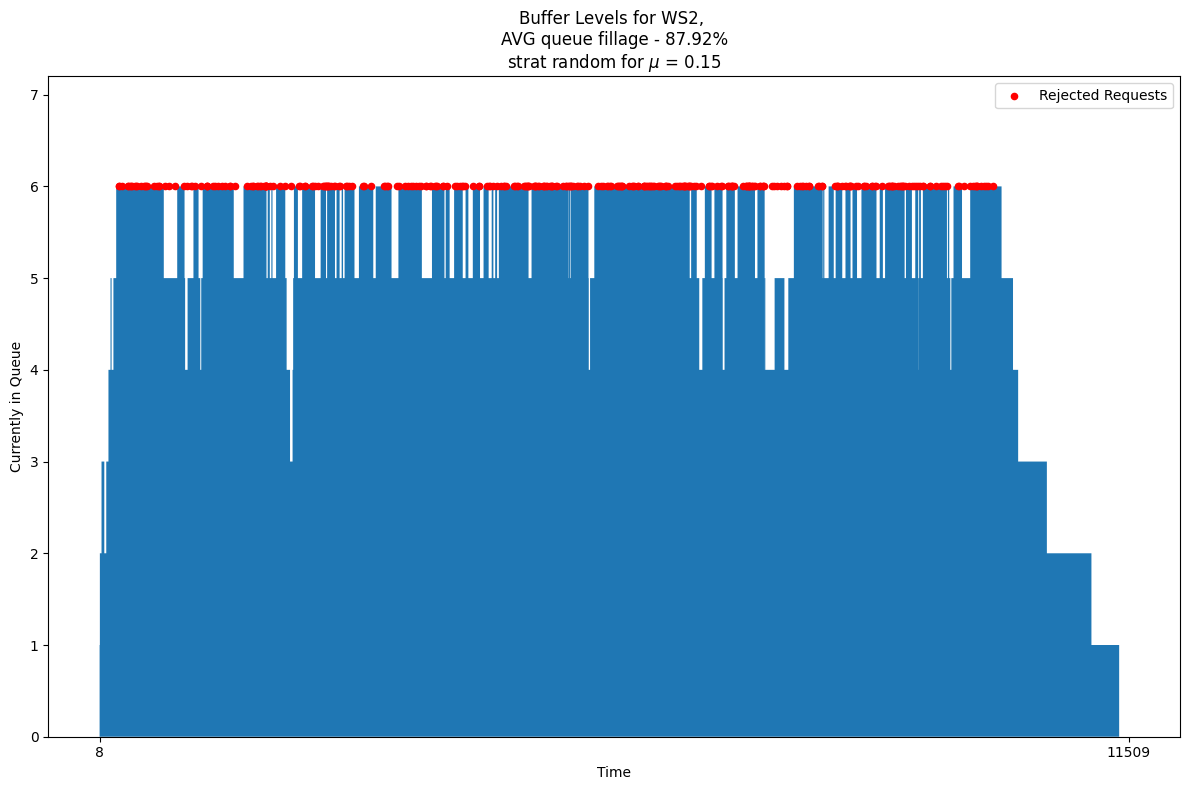

{'WS1': np.float64(89.55), 'WS2': np.float64(87.92)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 142
Odrzucone zgłoszenia: 361


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


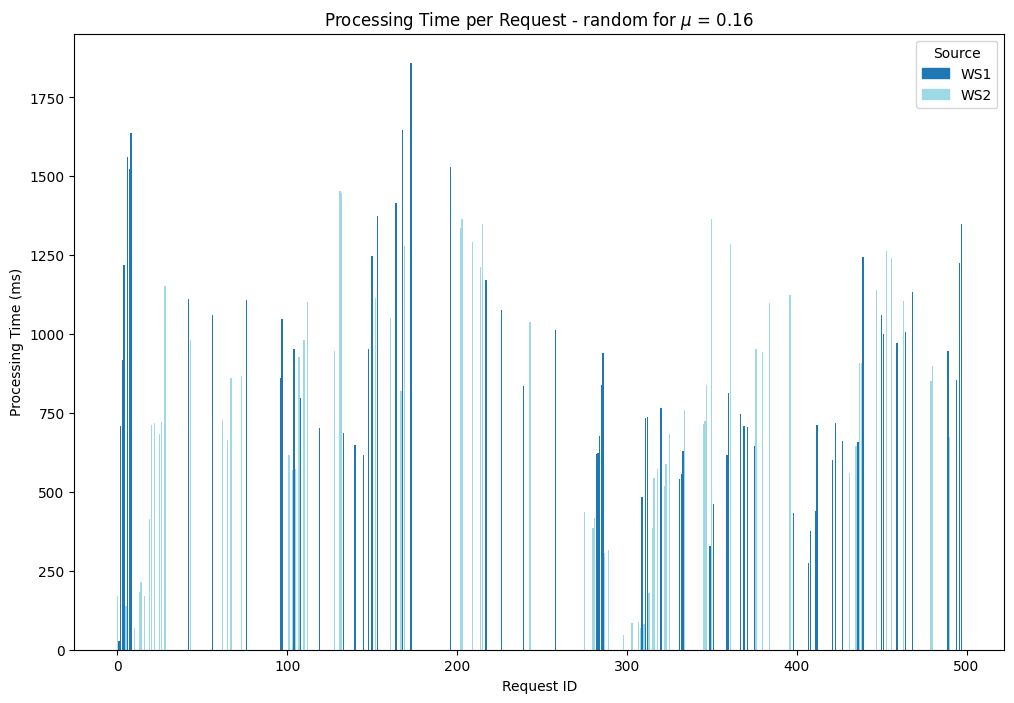

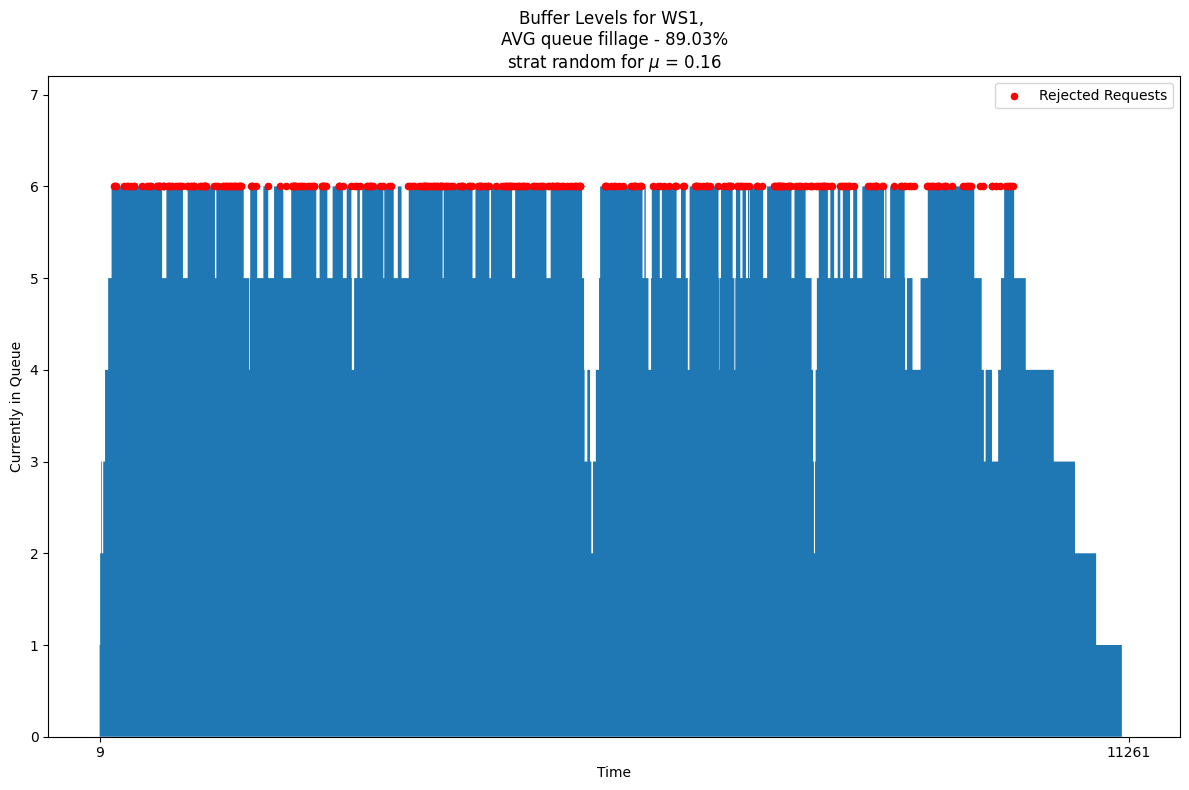

{'WS1': np.float64(89.03)}


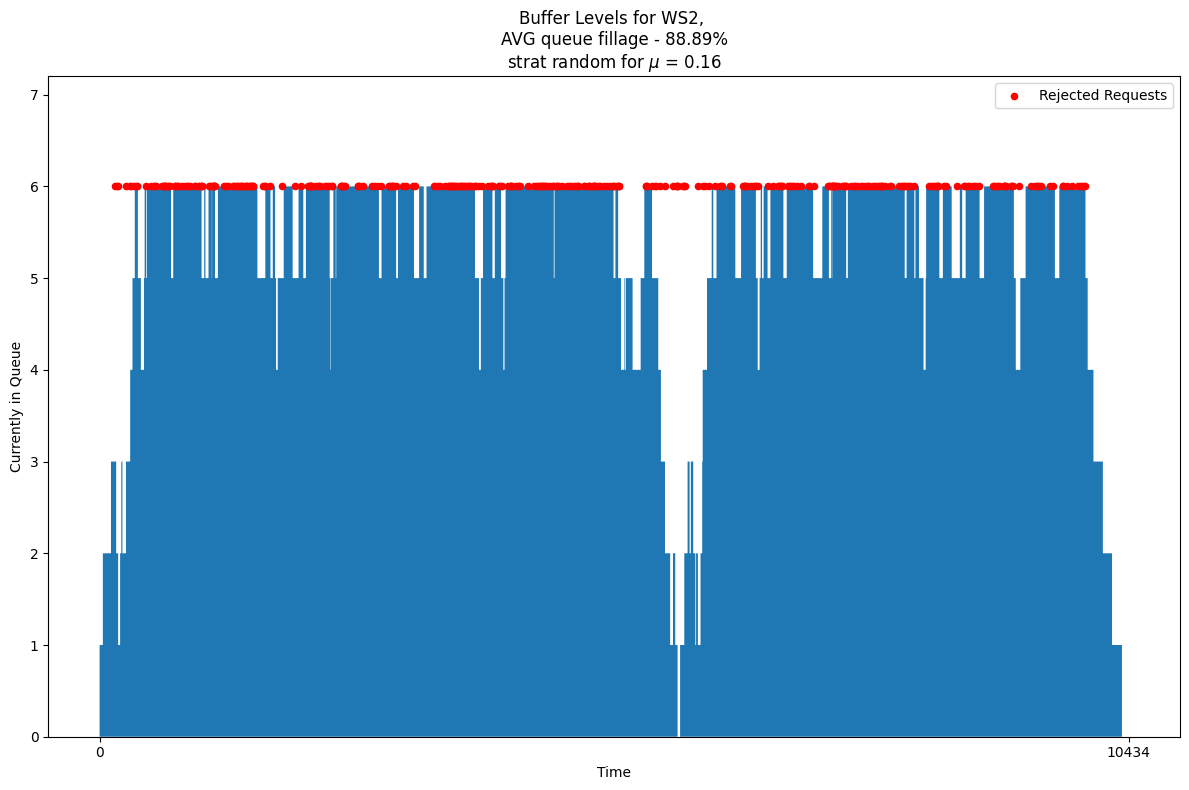

{'WS1': np.float64(89.03), 'WS2': np.float64(88.89)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 154
Odrzucone zgłoszenia: 322


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


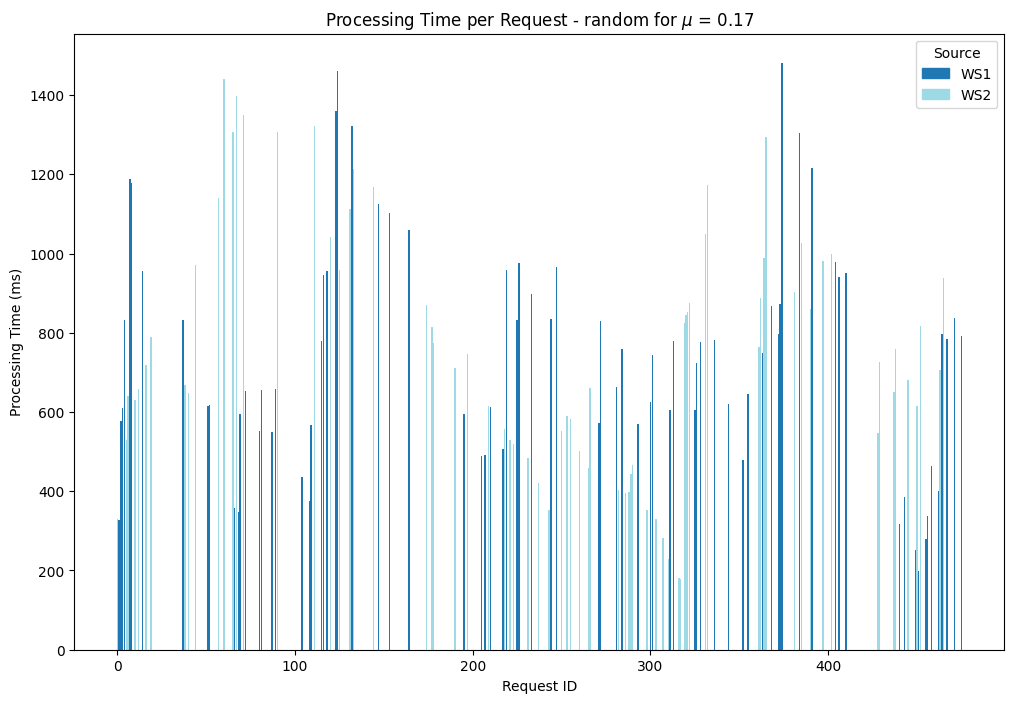

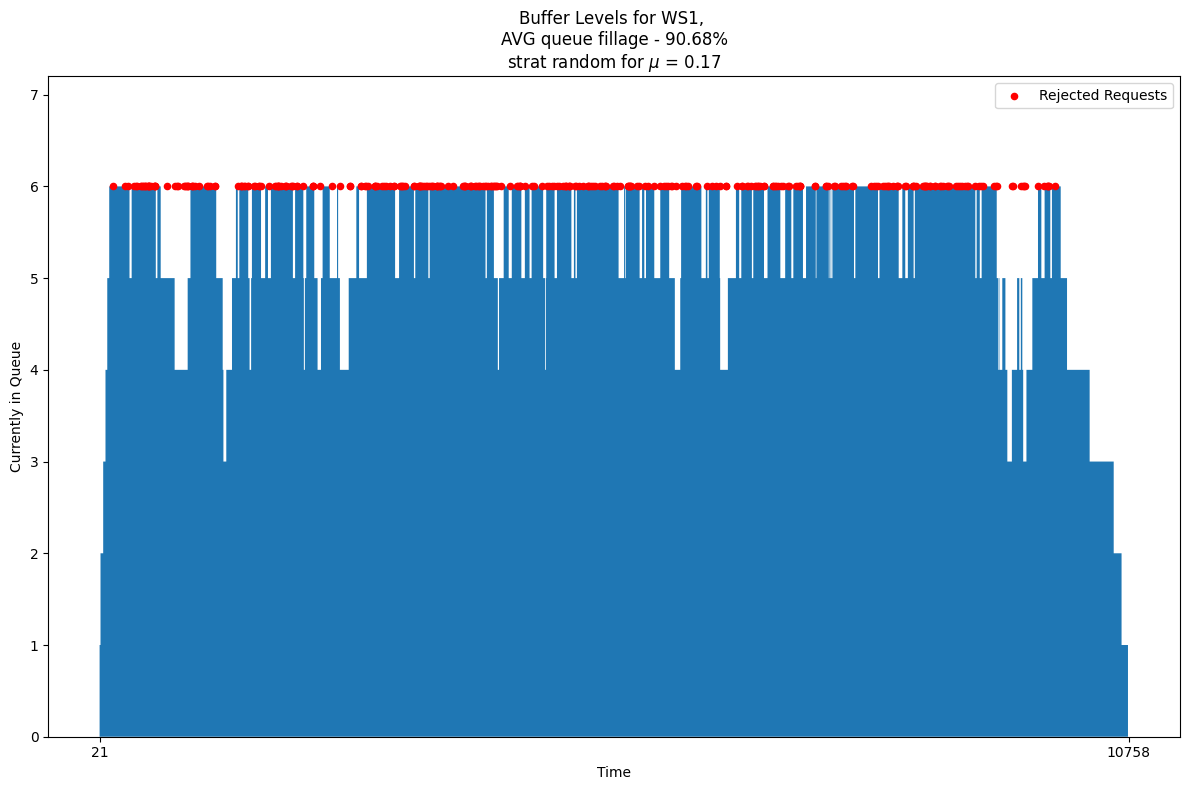

{'WS1': np.float64(90.68)}


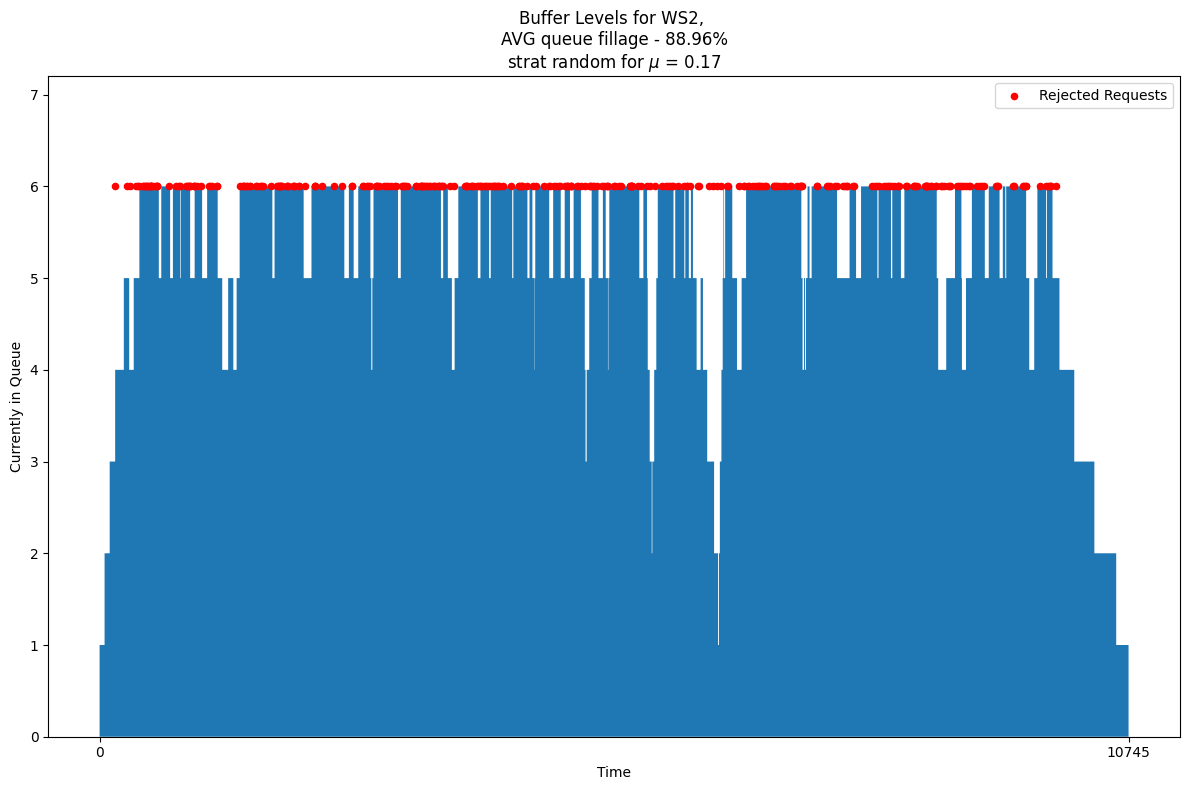

{'WS1': np.float64(90.68), 'WS2': np.float64(88.96)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 114
Odrzucone zgłoszenia: 352


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


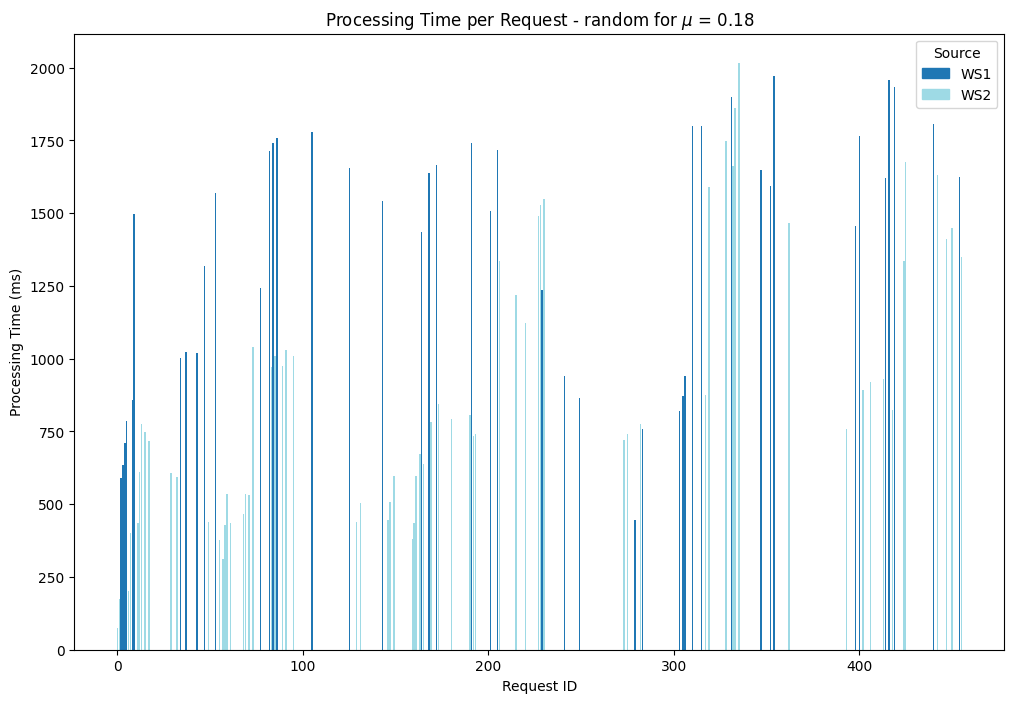

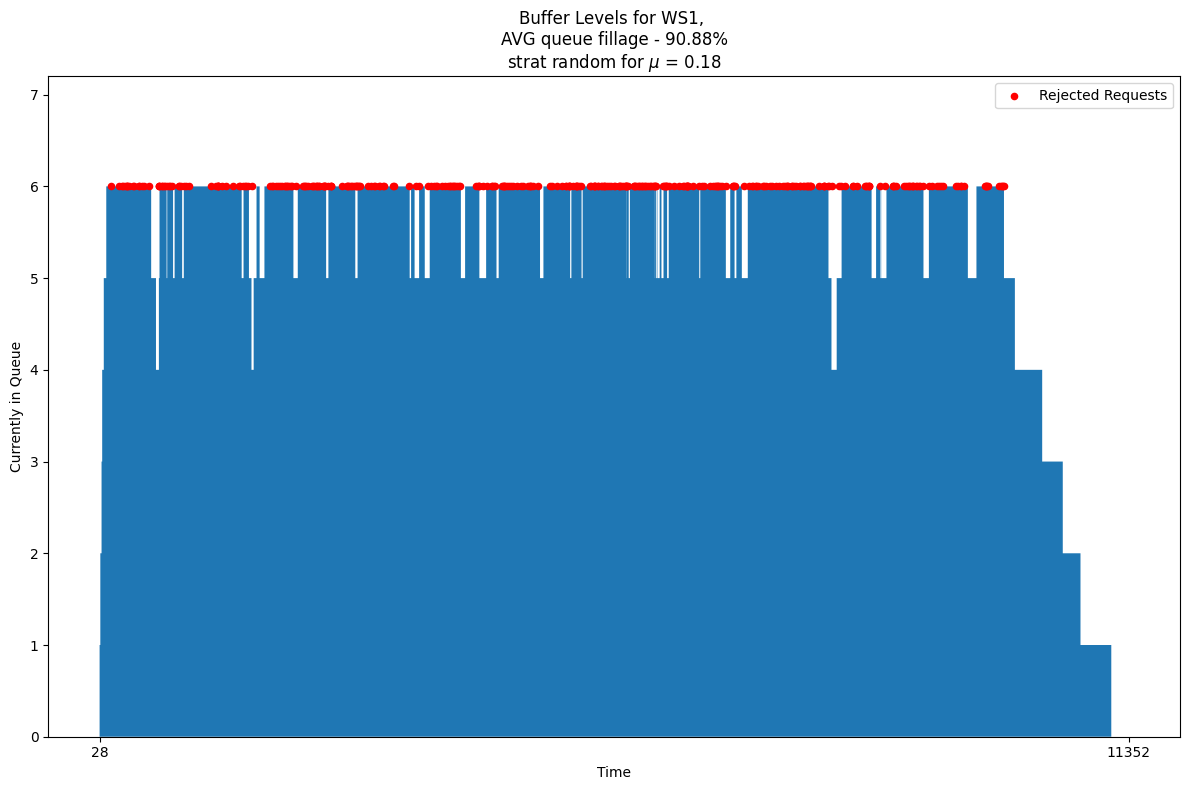

{'WS1': np.float64(90.88)}


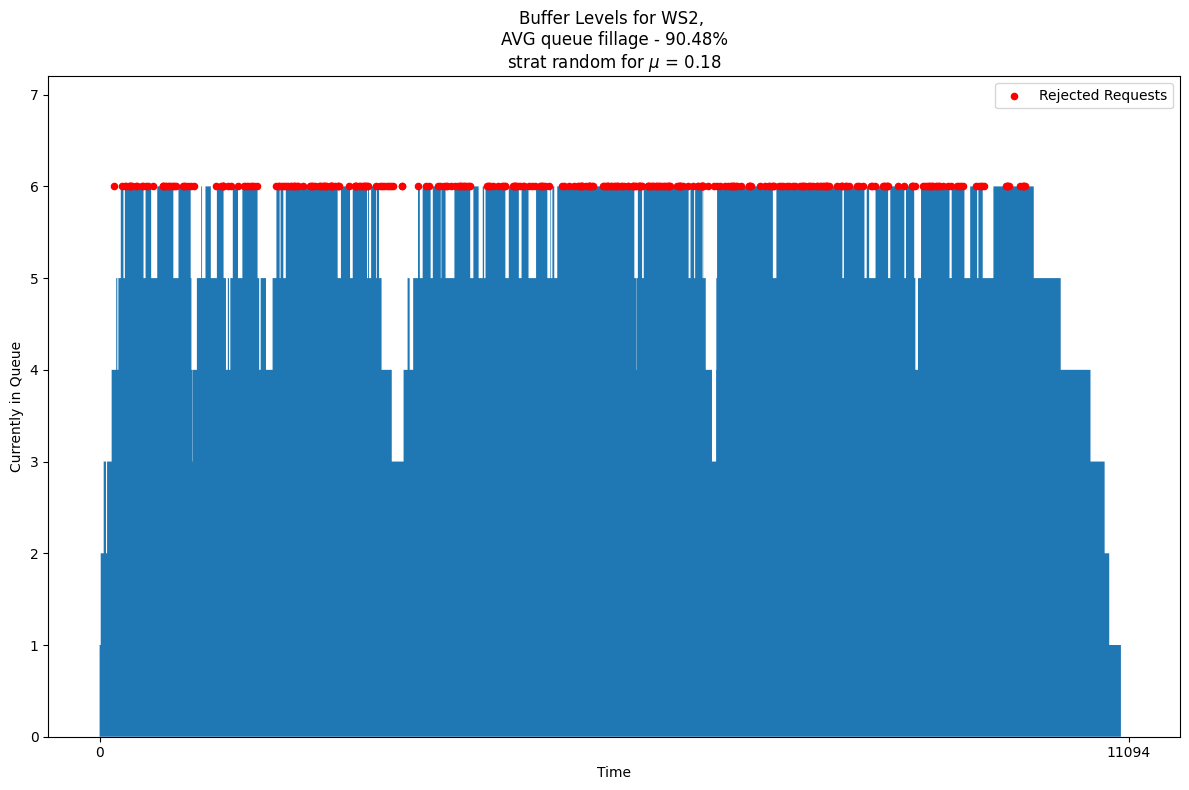

{'WS1': np.float64(90.88), 'WS2': np.float64(90.48)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 153
Odrzucone zgłoszenia: 330


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


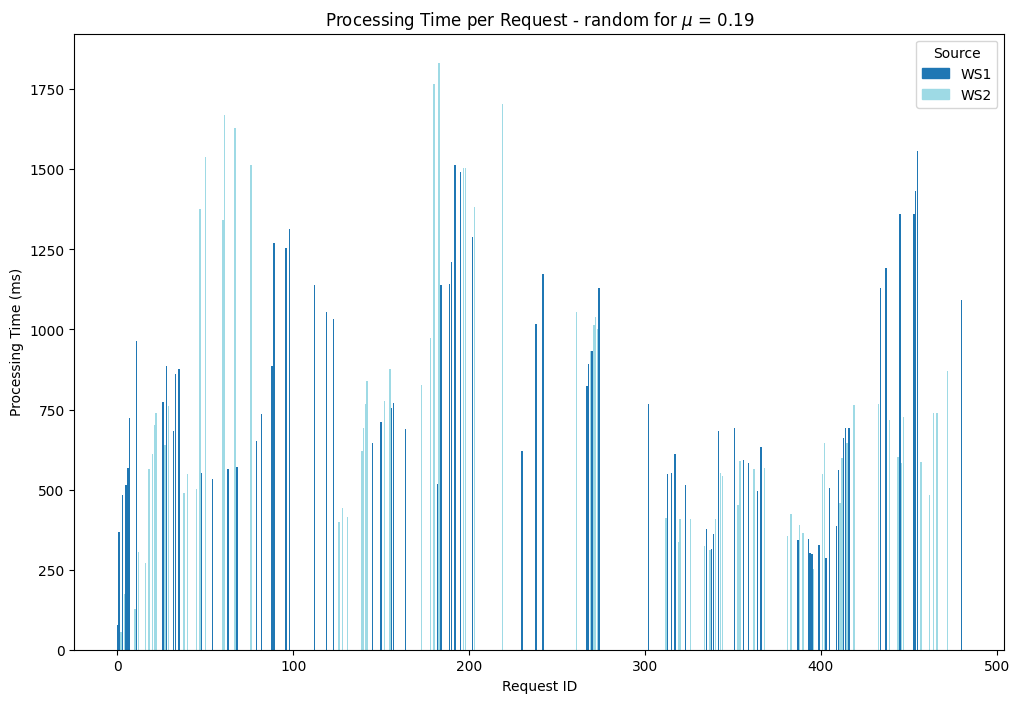

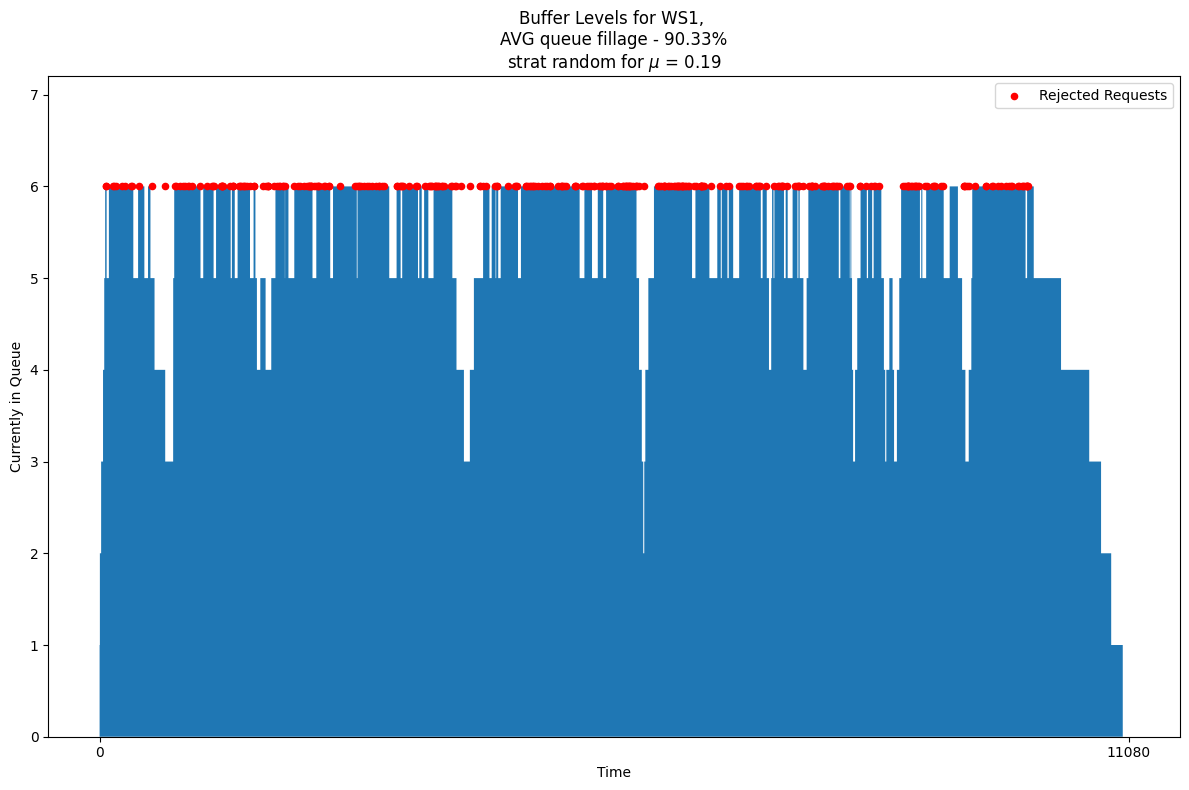

{'WS1': np.float64(90.33)}


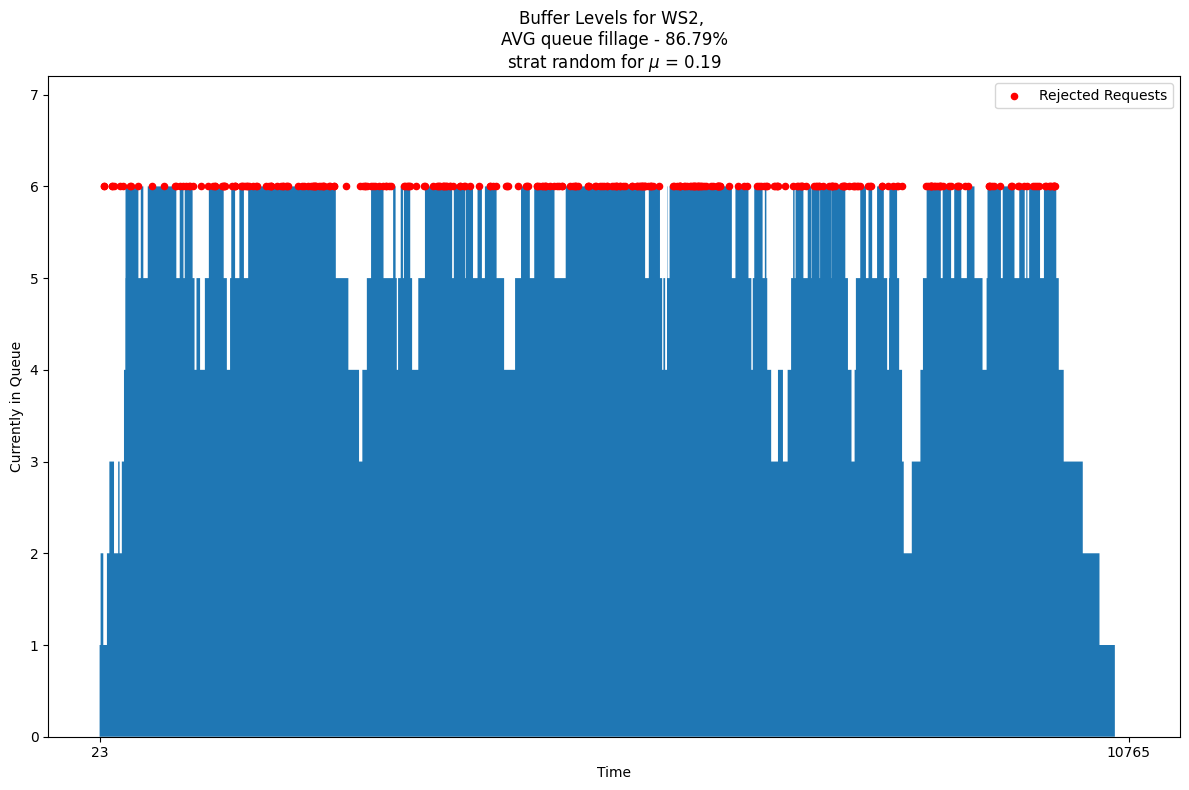

{'WS1': np.float64(90.33), 'WS2': np.float64(86.79)}

Start symulacji - polityka route_random

Polityka: route_random
Przetworzone zgłoszenia: 123
Odrzucone zgłoszenia: 350


/var/folders/69/dws6xwp11mgdnm5sb8sr1kph0000gn/T/ipykernel_92612/1123447220.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


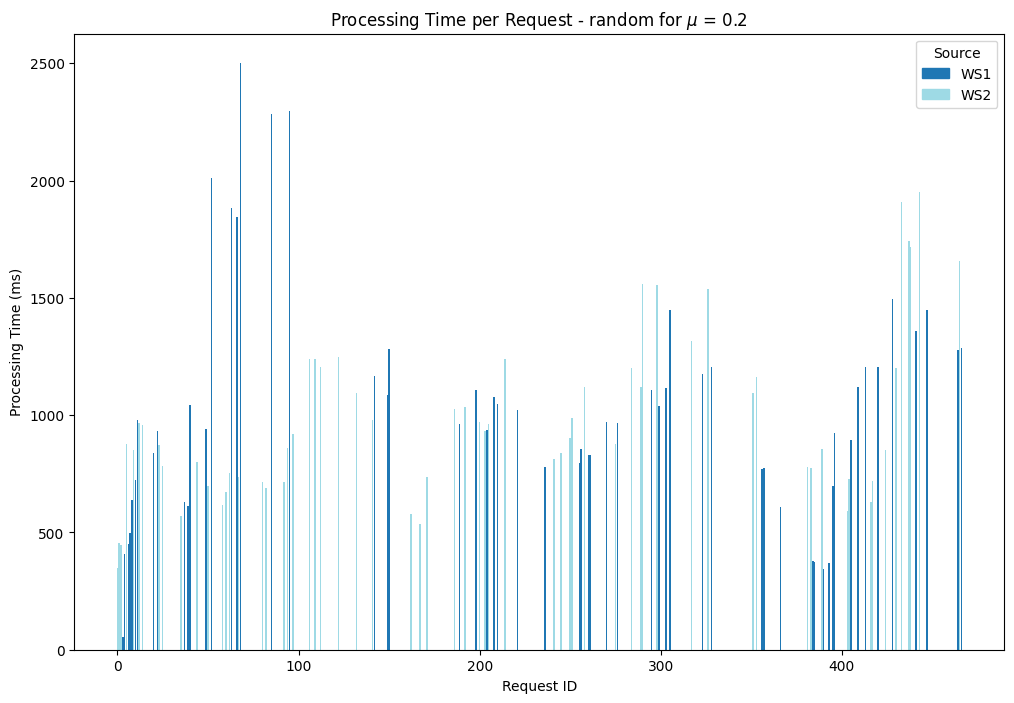

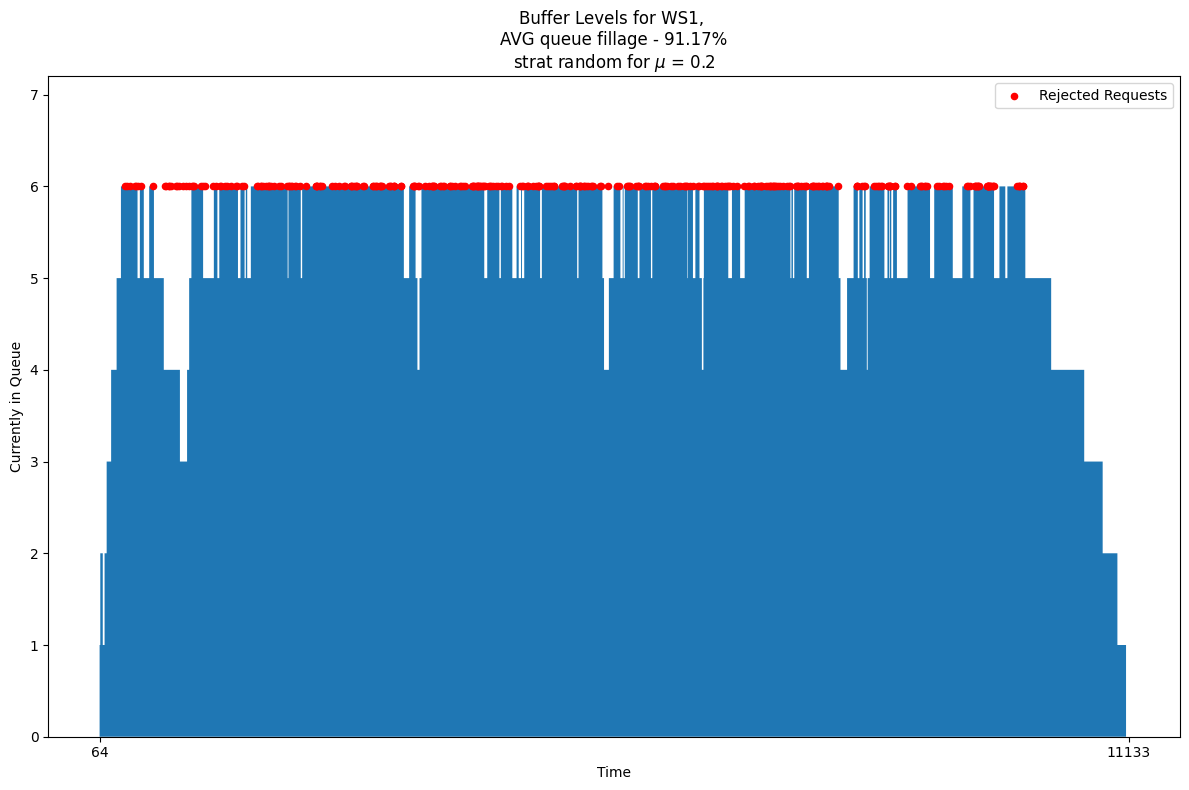

{'WS1': np.float64(91.17)}


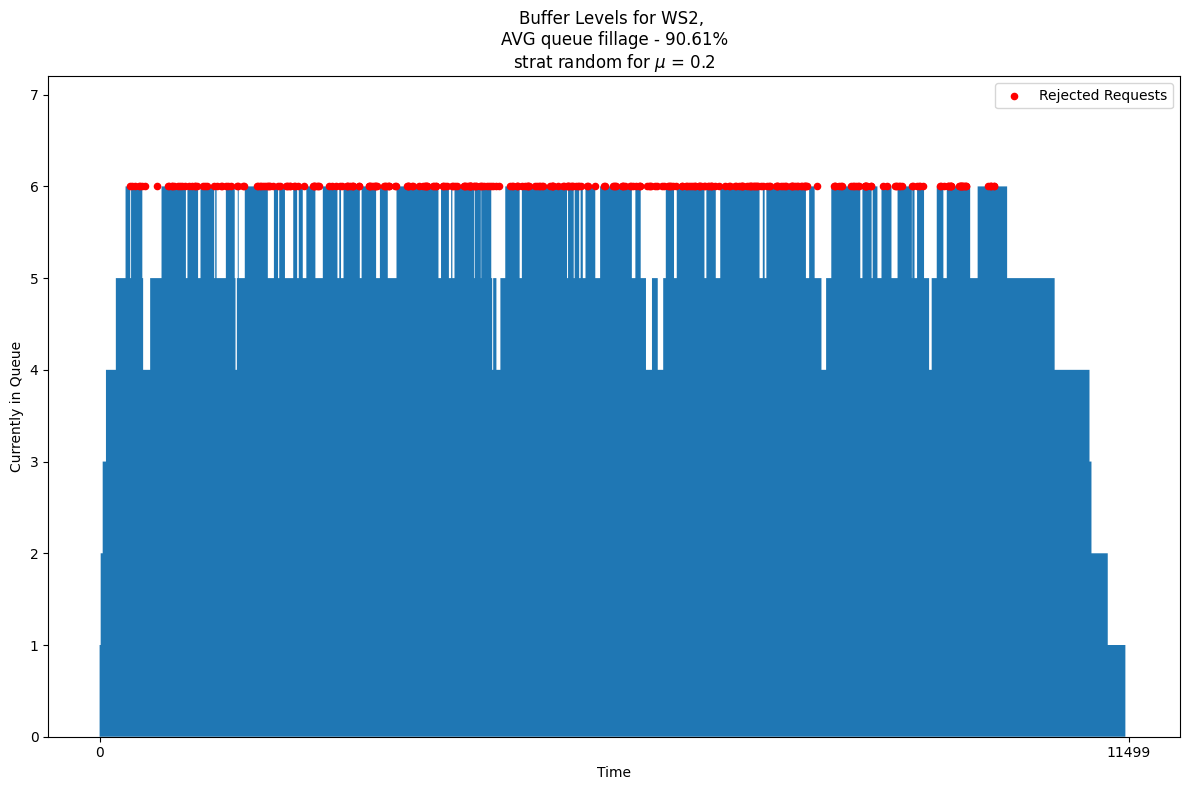

{'WS1': np.float64(91.17), 'WS2': np.float64(90.61)}


In [23]:
reject_percent = {}
avg_times = {}
avg_times_stds = {}
avg_queues_p = {}
max_buffer = 5
times = np.arange(0.01,0.21,0.01)
for start in ['shortest_queue','random']:
    for process_time in times:
        sim = await simulation_cli(num_servers=2,server_buffer_size=max_buffer,server_mu=process_time,lambda_=50,simulation_time=10,routing_fn=start, logging=False)
        reject_percent[f'{start}_{process_time}'] = sim.get('total_rejected')/(sim.get('total_processed')+sim.get('total_rejected'))
        file_path = f'.logs/route_{start}_0.json'
        data_df, result, rejects = process_queue_data(file_path)
        avg_times[f'{start}_{process_time}'],avg_times_stds[f'{start}_{process_time}'] =  plot_processing_times(result,strat = start, mu = process_time)
        avg_queues_p[f'{start}_{process_time}'] =plot_buffer_levels(data_df, rejects, max_buffer+1,strat = start, mu = process_time)
        

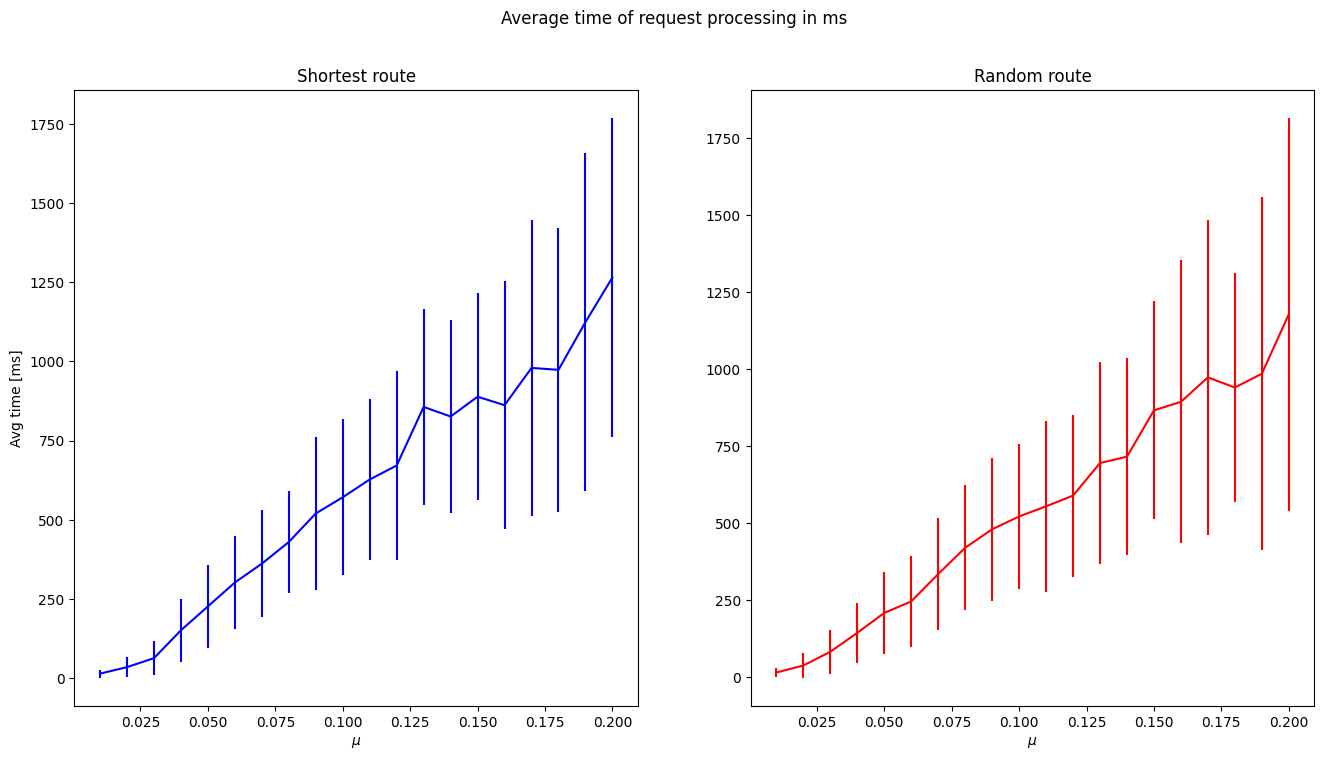

In [131]:
size = len(times)
shortest_dict = {key: val for key, val in avg_times.items() if key.startswith('short')}
shortest_dict_yerr = {key: val for key, val in avg_times_stds.items() if key.startswith('short')}

fig, ax = plt.subplots(1, 2, figsize=[16, 8])
fig.suptitle('Average time of request processing in ms')
ax[0].errorbar(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(size),yerr=pd.DataFrame.from_dict(shortest_dict_yerr)[-1:].values.reshape(size),c='blue')
ax[0].set_xlabel(r'$\mu$')
ax[0].set_ylabel('Avg time [ms]')
ax[0].set_title('Shortest route')
# fig.savefig('plots/avg_req_time_short.jpg')

size = len(times)
shortest_dict = {key: val for key, val in avg_times.items() if key.startswith('rand')}
shortest_dict_yerr = {key: val for key, val in avg_times_stds.items() if key.startswith('rand')}

ax[1].set_title('Random route')
ax[1].errorbar(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(size),yerr=pd.DataFrame.from_dict(shortest_dict_yerr)[-1:].values.reshape(size), c = 'red')
ax[1].set_xlabel(r'$\mu$')
fig.savefig('plots/avg_req_time_comp.jpg')

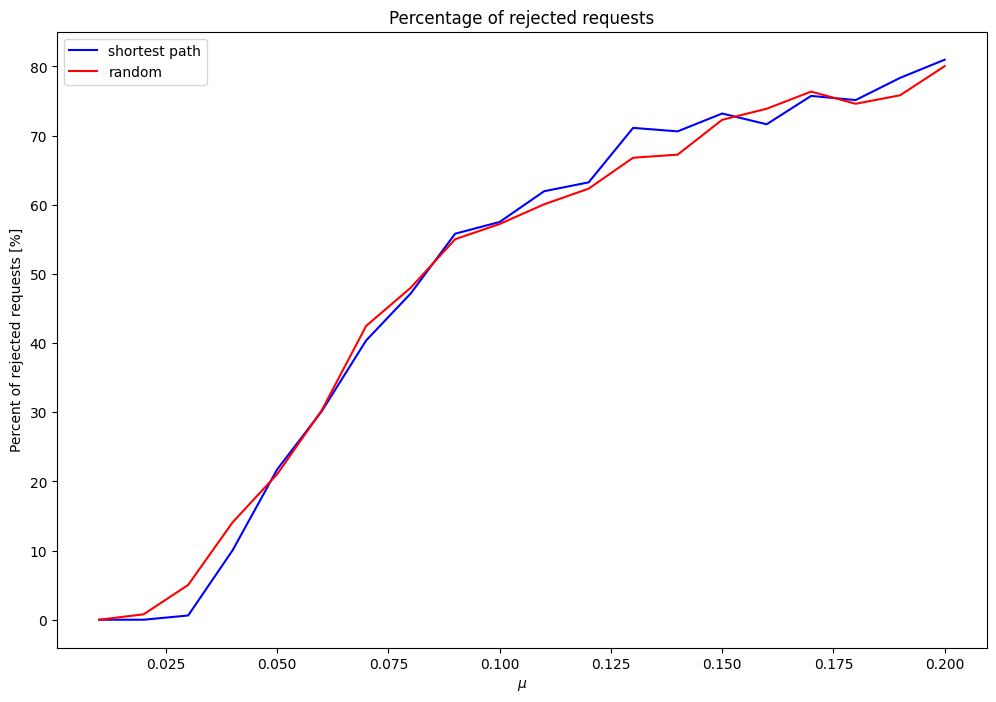

In [132]:
size = len(times)
shortest_dict = {key: val for key, val in reject_percent.items() if key.startswith('short')}
fig = plt.figure(figsize=[12,8])
plt.plot(times,np.array(list(shortest_dict.values()))*100, label = 'shortest path', c = 'blue')
plt.title('Percentage of rejected requests')
plt.xlabel(r'$\mu$')
plt.ylabel('Percent of rejected requests [%]')
# fig.savefig('plots/rejected_req_short.jpg')

shortest_dict = {key: val for key, val in reject_percent.items() if key.startswith('rand')}
# fig = plt.figure(figsize=[12,8])
plt.plot(times,np.array(list(shortest_dict.values()))*100, label= 'random', c = 'red')
plt.legend()
# plt.xlabel(r'$\mu$')
# plt.ylabel('Percent of rejected requests [%]')
fig.savefig('plots/rejected_req_comp.jpg')

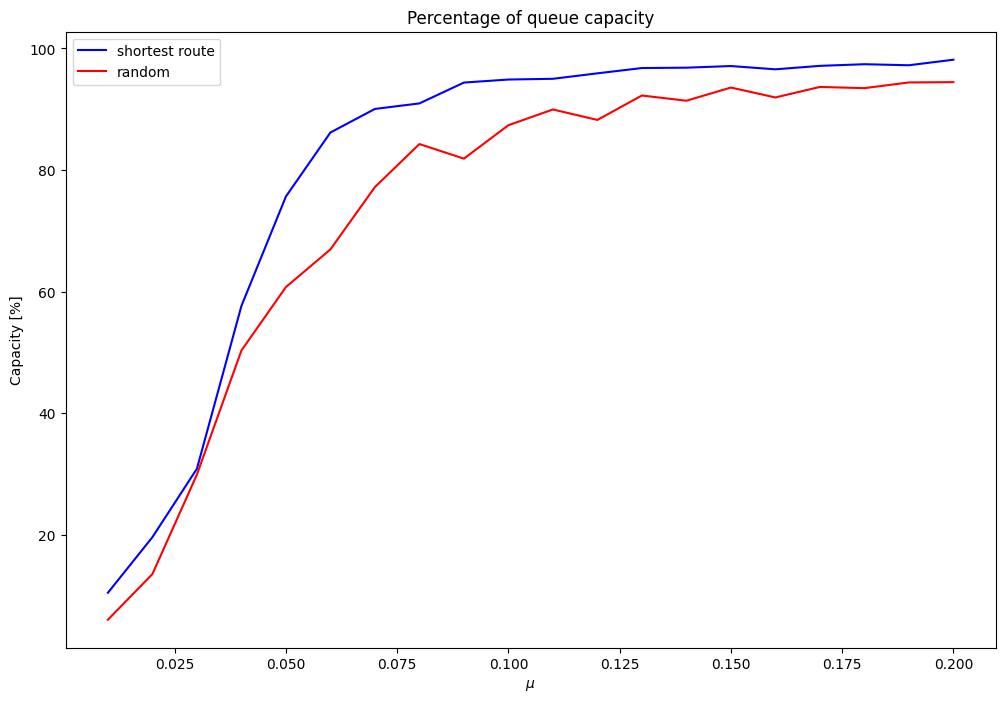

In [133]:
shortest_dict = {key: val for key, val in avg_queues_p.items() if key.startswith('short')}
fig = plt.figure(figsize=[12,8])
plt.plot(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(size), c = 'blue', label = 'shortest route')
plt.title('Percentage of queue capacity')
plt.xlabel(r'$\mu$')
plt.ylabel('Capacity [%]')
# fig.savefig('plots/rejected_time_short.jpg')

shortest_dict = {key: val for key, val in avg_queues_p.items() if key.startswith('random')}
plt.plot(times,pd.DataFrame.from_dict(shortest_dict)[-1:].values.reshape(size), c = 'red', label = 'random')
plt.legend()
# plt.title('Percentage of queue capacity - random')

fig.savefig('plots/rejected_time_comp.jpg')